# CONNECTOME ANALYSIS OF PSOa PATHWAYS

## This code is moslty based on the analyses in Walker et al. https://github.com/avdevineni/taste-connectome

### The code is organized into sections focused on PSOas, 2Ns, 3Ns, etc.,. with several types of analysis in each section.

This workflow is on the third set/cluster naming convention we came up with for the PSOas

### First, import packages and set default plotting parameters

In [1]:
#from aPhN_SA_Activation import set_1
#%pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from venn import venn
import seaborn as sns
from matplotlib.colors import LogNorm
import statsmodels.api as sm

In [3]:
# Set seaborn theme to white
sns.set_theme(style='white')

# set up matplot lib theme
andy_theme = {'axes.grid': True,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': False,
              'legend.fontsize': 14,
              'legend.title_fontsize': 14,
              'font.sans-serif':'Helvetica',
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'axes.labelsize': 12,
              'axes.titlesize': 16,
              'figure.dpi': 300}

plt.rcParams.update(andy_theme)

#Uncomment next 2 lines if matplotlib can not find Helvetica font
#plt.rcParams['font.family'] = 'DeJavu Serif'
#plt.rcParams['font.sans-serif'] = ['Arial']

## 1. FIRST ORDER ANALYSES

### Load the datasets with neurons and connections.

* This script assumes that the **CSV** files (`.csv.gz`) and **PS lists** (`_new.csv` files) are in the same folder as this notebook or script.
* These files include four CSVs containing manually curated  PSOas lists and four connectome datasets from FlyWire:
  1. **`classification.csv.gz`**
  2. **`connections.csv.gz`**
  3. **`neuropil_synapse_table.csv.gz`**
  4. **`neurons.csv.gz`**
* **Axon lists** were curated manually as described in the paper.
* **Connectome datasets** were downloaded from the FlyWire website using **snapshot 783** (previous snapshot 630).
* We focus on putative sensory axons from the Drosophila **apharyngeal nerve** in this analysis.


In [4]:
# Connections dataset and additional data sets

# Load the connections dataset
# columns: pre_root_id, post_root_id, neuropil, syn_count, nt_type
connections = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/connections.csv.gz')

# Neuropil synapses
# columns: root_id, input synapses, input partners, output synapses, output partners, etc
# Keep only root_id, input syanapses, output synapses
neuropil_synapse = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/neuropil_synapse_table.csv.gz')[['root_id','input synapses','output synapses']]

# Rename with underscores
neuropil_synapse.rename(columns={'input synapses': 'input_synapses','output synapses': 'output_synapses'}, inplace=True)

# Load classification table
# columns: root_id, flow, super_class, side, etc
# Keep only root_id and side
classification = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz')[['root_id','side']]
classification_other = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/classification.csv.gz')[['root_id','super_class', 'class']]

# Load data about each neuron
# columns: root_id, group, nt_type, etc
# Keep only root_id, nt_type
neurons = pd.read_csv('/Users/yaolab/Library/CloudStorage/OneDrive-UniversityofFlorida/YaoLabUF/YaoLab/Drosophila_brain_model/neurons.csv.gz')[['root_id','nt_type']]

# Merging additional data in one data set
neurons_data = pd.merge(neurons, pd.merge(classification, neuropil_synapse, on='root_id',how= 'outer'), on='root_id',how='outer')

# Load putative aPSA lists
set_1 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_1.csv')
set_2 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_2.csv')
set_3 = pd.read_csv('/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_v3/set_3.csv')

### Find downstream connections of PSOas
- includes all neurons downstream of PSOas - we will filter out set-set connections later
- minimum of 5 synapses between the two neurons

In [5]:
# Define function to get outputs of PSOas
def neuronal_outputs(phn_sa):
    # Merge the phn_sa DataFrame with the 'connections' data, filtering out any connections
    # that have fewer than 5 synapses
    connectivity = pd.merge(
        phn_sa['root_id'],
        connections[['pre_root_id','post_root_id','neuropil','syn_count','nt_type']],
        left_on='root_id',
        right_on='pre_root_id',
        how='inner'
    ).query("syn_count >= 5")

    # Remove the temporary 'root_id' column that came from the phn_sa DataFrame
    connectivity = connectivity.drop(columns='root_id')

    # Define function to categorize connection location
    def projection(neuropil):
        if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R', 'CAN']:  # Example SEZ-related regions
            return 'local'
        else:
            return 'outside_SEZ'

    # Apply the projection categorization to each row in 'connectivity'
    connectivity['location_of_connection'] = connectivity['neuropil'].apply(projection)

    return connectivity

In [6]:
# Get the outputs for each set of PSOas
set_1_outputs = neuronal_outputs(set_1)
set_2_outputs = neuronal_outputs(set_2)
set_3_outputs = neuronal_outputs(set_3)

### Quantifying PSOa to PSOa communication
# This creates a heatmap showing the # of synapses between each set of apharyngeal sensory axons.

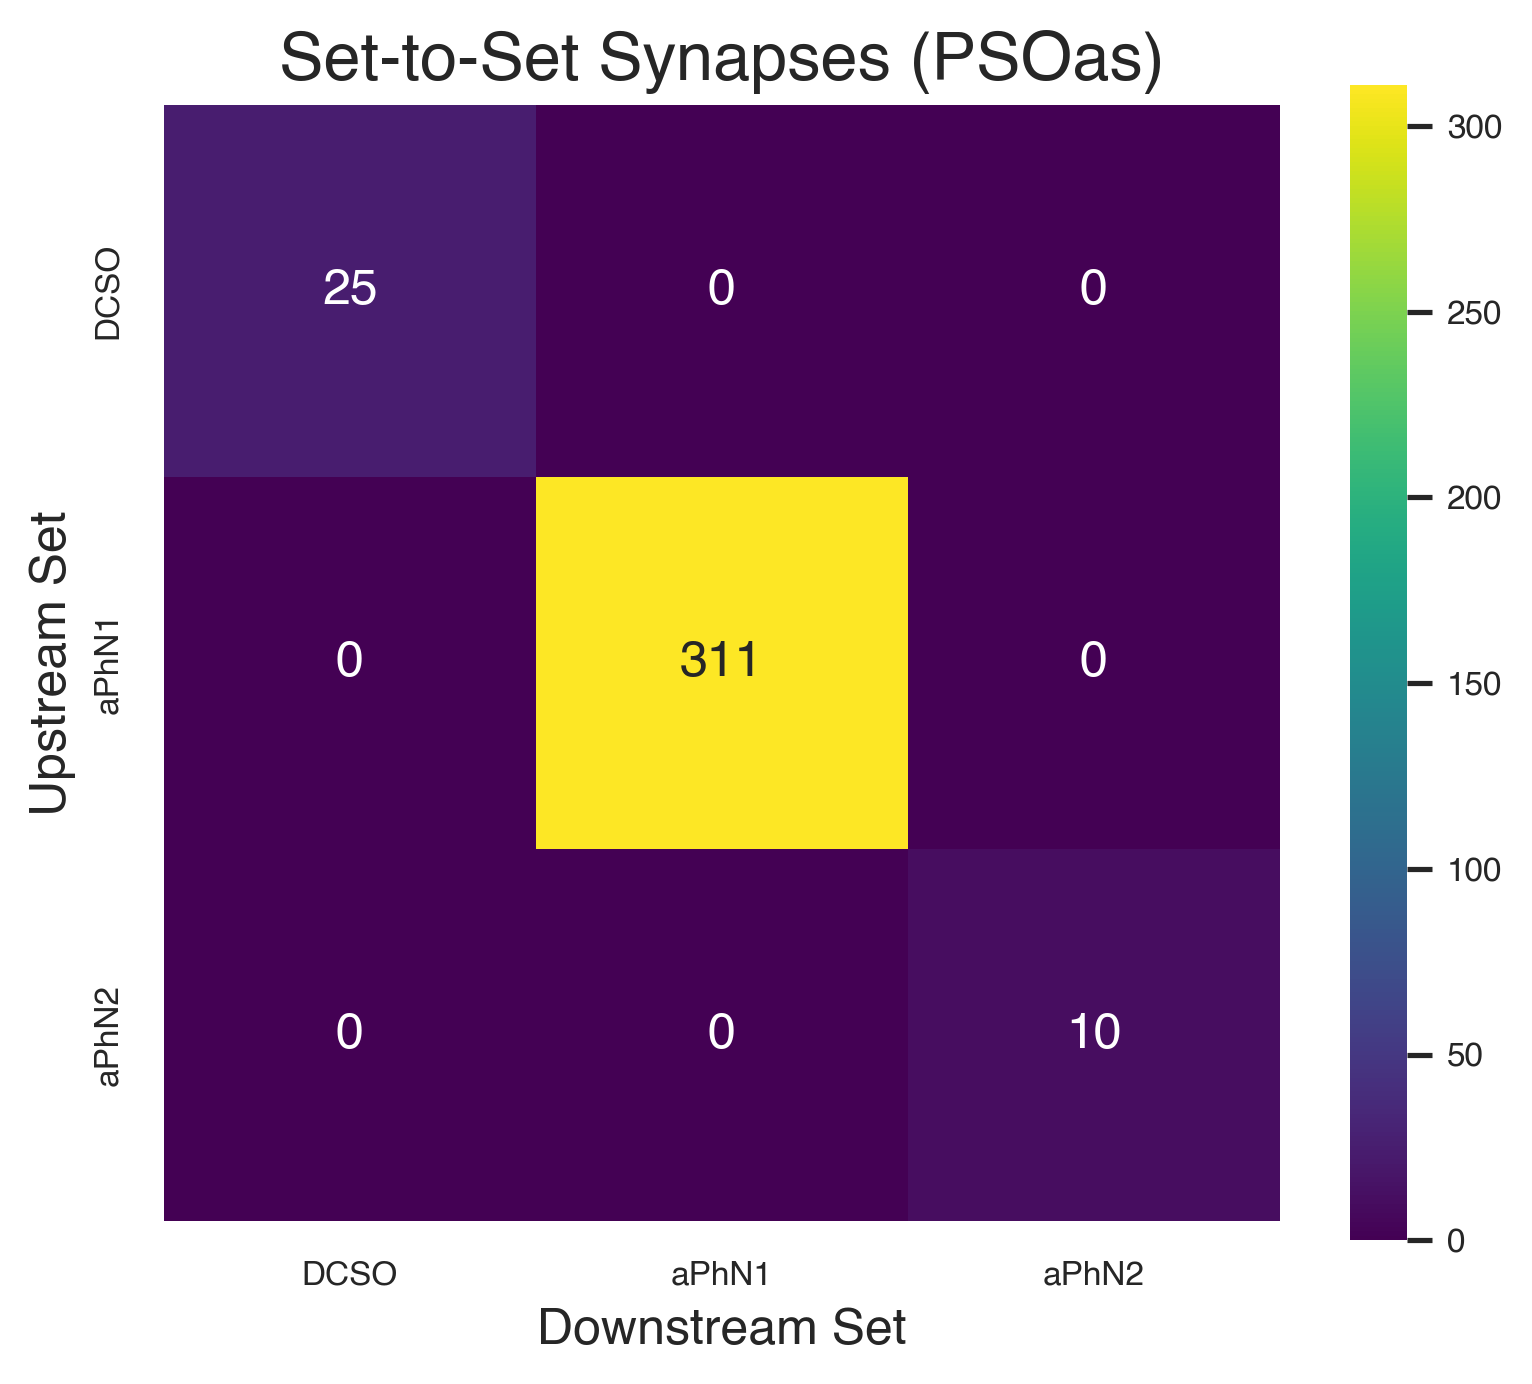

In [7]:
def phn_sa_heatmap_matrix(outputs_list, sets_list):
    """
    Given a list of DataFrames representing the outputs of each PSOa set
    (e.g., set_1_outputs, set_2_outputs, etc.) and a list of DataFrames of the
    actual sets (e.g., set_1, set_2, ...), return an NxN matrix where
    matrix[i, j] is the sum of 'syn_count' from set i to set j.

    Parameters
    ----------
    outputs_list : list of pd.DataFrame
        [set_1_outputs, set_2_outputs_outputs, ...]
    sets_list : list of pd.DataFrame
        [set_1, set_2, ...]

    Returns
    -------
    np.ndarray
        An NxN integer matrix with syn_count sums.
    """
    n = len(sets_list)
    # Initialize an NxN matrix of zeros
    syn_matrix = np.zeros((n, n), dtype=int)

    # Loop over each set's outputs (the "upstream" side)
    for i, out_df in enumerate(outputs_list):
        # For each possible downstream set
        for j, set_df in enumerate(sets_list):
            merged_df = pd.merge(
                out_df,
                set_df,
                left_on='post_root_id',  # from the outputs side
                right_on='root_id',      # from the set's root IDs
                how='inner'
            )
            # Sum all syn_count
            syn_matrix[i, j] = merged_df['syn_count'].sum()

    return syn_matrix


# We assume you already have:
# set_1, set_2, set_4, set_5, set_6
# set_1_outputs, set_2_outputs_outputs, set_4_outputs, set_5_outputs, set_6_outputs

all_sets = [set_1, set_2, set_3]
all_outputs = [set_1_outputs, set_2_outputs, set_3_outputs]


# Create the matrix of syn_counts
syn_matrix = phn_sa_heatmap_matrix(all_outputs, all_sets)

# Provide labels for rows (upstream sets) and columns (downstream sets)
row_labels = ['DCSO', 'aPhN1', 'aPhN2']
col_labels = ['DCSO', 'aPhN1', 'aPhN2']

# Plot the heatmap
plt.figure(figsize=(6,5))  # optional figure size
sns.heatmap(
    syn_matrix,
    cmap='viridis',
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,
    vmin=0
)

plt.title("Set-to-Set Synapses (PSOas)")
plt.ylabel("Upstream Set")
plt.xlabel("Downstream Set")
plt.show()

## 2. SECOND ORDER NEURON ANALYSES

## 2a. Identify 2Ns and their connections and organize the data

### Define and run a function to identify second order neurons (2Ns)
- neuron must be downstream of PSOas
- minimum of 5 synapses between the two neurons
- we will filter out PSOas from the list later

In [8]:
# Define function
def second_order(phn_sa, set_label):
    """
    Given a set of apharyngeal sensory axons (PSOas) with a 'root_id' column,
    this function extracts the connectivity (filtered for syn_count >= 5) and
    aggregates it to yield second-order outputs.

    Parameters:
        phn_sa : pd.DataFrame
            DataFrame containing a column 'root_id' for the PSOas.
        set_label : str
            A label (e.g., 'set_1', 'set_2', etc.) used to annotate the output columns.

    Returns:
        connectivity : pd.DataFrame
            DataFrame containing the filtered connectivity data.
        second_orders : pd.DataFrame
            Aggregated connectivity DataFrame with:
              - 'root_id': post-synaptic neuron ID,
              - 'upstream_<set_label>_PhN_SAs': count of unique upstream PSOas,
              - '<set_label>_syn_count': total synapse count,
              - 'const': constant column for OLS regression.
    """
    # Get connectivity from PSOas
    connectivity = pd.merge(
        phn_sa['root_id'],
        connections[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
        left_on='root_id',
        right_on='pre_root_id',
        how='inner'
    ).query("syn_count >= 5")

    connectivity = connectivity.drop(columns='root_id')

    # Aggregate connectivity to obtain second-order outputs
    second_orders = connectivity.groupby("post_root_id").agg({
        'pre_root_id': 'nunique',
        'syn_count': 'sum'
    }).reset_index()

    second_orders.columns = ['root_id', 'upstream_' + set_label + '_PhN_SAs', set_label + '_syn_count']
    second_orders['const'] = 1  # For OLS regression later

    return connectivity, second_orders


In [9]:
# Run function to get second-order connectivity and list of second-order outputs (2Ns) for each set
set_1_second_order_connectivity, set_1_2Ns = second_order(set_1, 'set_1')
set_2_second_order_connectivity, set_2_2Ns = second_order(set_2, 'set_2')
set_3_second_order_connectivity, set_3_2Ns = second_order(set_3, 'set_3')

In [10]:
# Take a look at set_6_2Ns as an example
set_1_2Ns

,root_id,upstream_set_1_PhN_SAs,set_1_syn_count,const
0,720575940605698080,4,63,1
1,720575940605703456,4,62,1
2,720575940606867145,4,47,1
3,720575940607472988,2,19,1
4,720575940608239371,1,5,1
...,...,...,...,...
131,720575940646156420,5,158,1
132,720575940647036980,4,220,1
133,720575940648708228,7,75,1
134,720575940649081465,4,74,1


In [11]:
# Checking how many 2Ns we have for each set
print("Set_1 2Ns:", np.unique(set_1_2Ns.root_id.values).shape)
print("Set_2 2Ns:", np.unique(set_2_2Ns.root_id.values).shape)
print("Set_3 2Ns:", np.unique(set_3_2Ns.root_id.values).shape)

Set_1 2Ns: (136,)
Set_2 2Ns: (410,)
Set_3 2Ns: (258,)


### Getting more information about 2Ns from flywire

In [12]:
# Select and merge rows from neurons_data for each set of 2Ns
# 'neurons_data' contains columns like nt_type, side, input_synapses, output_synapses
set_1_2Ns = pd.merge(set_1_2Ns, neurons_data, on='root_id', how='inner')
set_2_2Ns = pd.merge(set_2_2Ns, neurons_data, on='root_id', how='inner')
set_3_2Ns = pd.merge(set_3_2Ns, neurons_data, on='root_id', how='inner')

In [13]:

# Checking that we didn't drop neurons with the merge
print("Set_1 2Ns (after merge):", np.unique(set_1_2Ns.root_id.values).shape)
print("Set_2 2Ns (after merge):", np.unique(set_2_2Ns.root_id.values).shape)
print("Set_3 2Ns (after merge):", np.unique(set_3_2Ns.root_id.values).shape)

Set_1 2Ns (after merge): (136,)
Set_2 2Ns (after merge): (410,)
Set_3 2Ns (after merge): (258,)


### Remove PSOas from 2N lists

In [14]:
# Concatenate all sets into a single DataFrame
all_sets = pd.concat([set_1, set_2, set_3], axis=0)

# Drop 2Ns that are actually in the apharyngeal sensory axon sets
set_1_2Ns = set_1_2Ns[~set_1_2Ns['root_id'].isin(all_sets['root_id'])]
set_2_2Ns = set_2_2Ns[~set_2_2Ns['root_id'].isin(all_sets['root_id'])]
set_2_2Ns = set_2_2Ns[~set_2_2Ns['root_id'].isin(all_sets['root_id'])]

# Drop all second-order connections where post-synaptic neurons are also in the sets
set_1_second_order_connectivity = set_1_second_order_connectivity[
    ~set_1_second_order_connectivity['post_root_id'].isin(all_sets['root_id'])
]
set_2_second_order_connectivity = set_2_second_order_connectivity[
    ~set_2_second_order_connectivity['post_root_id'].isin(all_sets['root_id'])
]

set_3_second_order_connectivity = set_3_second_order_connectivity[
    ~set_3_second_order_connectivity['post_root_id'].isin(all_sets['root_id'])
]

In [15]:
# 1) Check how many 2Ns are left for each set
print("Set_1 2Ns:", np.unique(set_1_2Ns.root_id.values).shape)
print("Set_2 2Ns:", np.unique(set_2_2Ns.root_id.values).shape)
print("Set_3 2Ns:", np.unique(set_3_2Ns.root_id.values).shape)

Set_1 2Ns: (132,)
Set_2 2Ns: (397,)
Set_3 2Ns: (258,)


### Add the data from the model simulations to the 2N dataframes

This will be necessary to analyze activated vs. non-activated 2Ns.

First, import the data and add the activation status

In [16]:
import os
import pandas as pd

# Absolute path to the "simulation" folder
simulation_path = "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_simulation_v3"

# Define the sets of stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

###############################################################################
# set_1
###############################################################################
for i in rates:
    csv_file = os.path.join(simulation_path, f"set_1_{i}Hz_rates.csv")
    ids_activated = pd.read_csv(csv_file)['flyid'].values
    set_1_2Ns[f'activation_{i}Hz'] = set_1_2Ns['root_id'].apply(
        lambda x: 'activated' if x in ids_activated else 'non activated'
    )
set_1_2Ns['label'] = 'set_1'

###############################################################################
# set_2
###############################################################################
for i in rates:
    csv_file = os.path.join(simulation_path, f"set_2_{i}Hz_rates.csv")
    ids_activated = pd.read_csv(csv_file)['flyid'].values
    set_2_2Ns[f'activation_{i}Hz'] = set_2_2Ns['root_id'].apply(
        lambda x: 'activated' if x in ids_activated else 'non activated'
    )
set_2_2Ns['label'] = 'set_2'

###############################################################################
# set_3
###############################################################################
for i in rates:
    csv_file = os.path.join(simulation_path, f"set_3_{i}Hz_rates.csv")
    ids_activated = pd.read_csv(csv_file)['flyid'].values
    set_3_2Ns[f'activation_{i}Hz'] = set_3_2Ns['root_id'].apply(
        lambda x: 'activated' if x in ids_activated else 'non activated'
    )
set_3_2Ns['label'] = 'set_3'


FileNotFoundError: [Errno 2] No such file or directory: '/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_simulation_v3/set_3_10Hz_rates.csv'

In [ ]:
# 4) Make a DataFrame with data for all sets
all_2N = pd.concat([
    set_1_2Ns,
    set_2_2Ns,
    set_3_2Ns
])

# The columns to merge and sum up depend on how you named them in the 'second_order' step
# Here, we assume they're named 'set_1_syn_count', 'set_2_syn_count', etc.
cols_merge_syn = [
    'set_1_syn_count', 'set_2_syn_count', 'set_3_syn_count'
]
all_2N = all_2N.assign(
    total_syn_count=all_2N[cols_merge_syn].sum(axis=1)
).drop(cols_merge_syn, axis=1)

# Similarly for the upstream columns, if you named them 'upstream_set_1_aPhN_SAs', etc.
cols_upstream = [
    'upstream_set_1_PhN_SAs', 'upstream_set_2_PhN_SAs', 'upstream_set_3_PhN_SAs'
]
all_2N = all_2N.assign(
    total_upstream=all_2N[cols_upstream].sum(axis=1)
).drop(cols_upstream, axis=1)

# all_2N now contains a combined table of second-order neurons with:
#   - Activation status at each rate, for each set
#   - Summed total syn_count across all sets
#   - Summed total of upstream sets
#   - A 'label' column that indicates which set the neuron was originally associated with.


In [ ]:
# Inspecting the new data frame
all_2N

## 2b. Quantify how many 2Ns were activated in the simulations

Note that this does not follow the order of analyses in the paper; this analysis is shown in Figure .....

### Prepare data for plotting

In [ ]:
# For set_1: Create activation DataFrames at each rate
set_1_activation_10Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_10Hz']], axis=1)
set_1_activation_10Hz['label'] = 'activation 10Hz'
set_1_activation_15Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_15Hz']], axis=1)
set_1_activation_15Hz['label'] = 'activation 15Hz'
set_1_activation_20Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_20Hz']], axis=1)
set_1_activation_20Hz['label'] = 'activation 20Hz'
set_1_activation_25Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_25Hz']], axis=1)
set_1_activation_25Hz['label'] = 'activation 25Hz'
set_1_activation_50Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_50Hz']], axis=1)
set_1_activation_50Hz['label'] = 'activation 50Hz'
set_1_activation_75Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_75Hz']], axis=1)
set_1_activation_75Hz['label'] = 'activation 75Hz'
set_1_activation_100Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_100Hz']], axis=1)
set_1_activation_100Hz['label'] = 'activation 100Hz'
set_1_activation_125Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_125Hz']], axis=1)
set_1_activation_125Hz['label'] = 'activation 125Hz'
set_1_activation_150Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_150Hz']], axis=1)
set_1_activation_150Hz['label'] = 'activation 150Hz'
set_1_activation_175Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_175Hz']], axis=1)
set_1_activation_175Hz['label'] = 'activation 175Hz'
set_1_activation_200Hz = pd.concat([set_1_2Ns.iloc[:,0:8], set_1_2Ns['activation_200Hz']], axis=1)
set_1_activation_200Hz['label'] = 'activation 200Hz'

# Vertically stack all set_1 activation DataFrames
set_1_activation_vertically_stacked = pd.concat([
    set_1_activation_10Hz,
    set_1_activation_15Hz,
    set_1_activation_20Hz,
    set_1_activation_25Hz,
    set_1_activation_50Hz,
    set_1_activation_75Hz,
    set_1_activation_100Hz,
    set_1_activation_125Hz,
    set_1_activation_150Hz,
    set_1_activation_175Hz,
    set_1_activation_200Hz
], axis=0)

# Merge activation columns into a single 'activation' column
cols_merge_activation_level = [
    'activation_10Hz', 'activation_15Hz', 'activation_20Hz',
    'activation_25Hz', 'activation_50Hz', 'activation_75Hz',
    'activation_100Hz', 'activation_125Hz', 'activation_150Hz',
    'activation_175Hz', 'activation_200Hz'
]
set_1_activation_vertically_stacked['activation'] = (
        set_1_activation_vertically_stacked['activation_10Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_15Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_20Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_25Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_50Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_75Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_100Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_125Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_150Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_175Hz'].fillna('') +
        set_1_activation_vertically_stacked['activation_200Hz'].fillna('')
)


In [ ]:
# For set_2: Create activation DataFrames at each rate
set_2_activation_10Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_10Hz']], axis=1)
set_2_activation_10Hz['label'] = 'activation 10Hz'
set_2_activation_15Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_15Hz']], axis=1)
set_2_activation_15Hz['label'] = 'activation 15Hz'
set_2_activation_20Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_20Hz']], axis=1)
set_2_activation_20Hz['label'] = 'activation 20Hz'
set_2_activation_25Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_25Hz']], axis=1)
set_2_activation_25Hz['label'] = 'activation 25Hz'
set_2_activation_50Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_50Hz']], axis=1)
set_2_activation_50Hz['label'] = 'activation 50Hz'
set_2_activation_75Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_75Hz']], axis=1)
set_2_activation_75Hz['label'] = 'activation 75Hz'
set_2_activation_100Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_100Hz']], axis=1)
set_2_activation_100Hz['label'] = 'activation 100Hz'
set_2_activation_125Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_125Hz']], axis=1)
set_2_activation_125Hz['label'] = 'activation 125Hz'
set_2_activation_150Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_150Hz']], axis=1)
set_2_activation_150Hz['label'] = 'activation 150Hz'
set_2_activation_175Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_175Hz']], axis=1)
set_2_activation_175Hz['label'] = 'activation 175Hz'
set_2_activation_200Hz = pd.concat([set_2_2Ns.iloc[:,0:8], set_2_2Ns['activation_200Hz']], axis=1)
set_2_activation_200Hz['label'] = 'activation 200Hz'

# Vertically stack all set_2 activation DataFrames
set_2_activation_vertically_stacked = pd.concat([
    set_2_activation_10Hz,
    set_2_activation_15Hz,
    set_2_activation_20Hz,
    set_2_activation_25Hz,
    set_2_activation_50Hz,
    set_2_activation_75Hz,
    set_2_activation_100Hz,
    set_2_activation_125Hz,
    set_2_activation_150Hz,
    set_2_activation_175Hz,
    set_2_activation_200Hz
], axis=0)

# Merge activation columns into a single 'activation' column
set_2_activation_vertically_stacked['activation'] = (
        set_2_activation_vertically_stacked['activation_10Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_15Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_20Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_25Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_50Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_75Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_100Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_125Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_150Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_175Hz'].fillna('') +
        set_2_activation_vertically_stacked['activation_200Hz'].fillna('')
)


In [ ]:
# For set_3: Create activation DataFrames at each rate
set_3_activation_10Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_10Hz']], axis=1)
set_3_activation_10Hz['label'] = 'activation 10Hz'
set_3_activation_15Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_15Hz']], axis=1)
set_3_activation_15Hz['label'] = 'activation 15Hz'
set_3_activation_20Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_20Hz']], axis=1)
set_3_activation_20Hz['label'] = 'activation 20Hz'
set_3_activation_25Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_25Hz']], axis=1)
set_3_activation_25Hz['label'] = 'activation 25Hz'
set_3_activation_50Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_50Hz']], axis=1)
set_3_activation_50Hz['label'] = 'activation 50Hz'
set_3_activation_75Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_75Hz']], axis=1)
set_3_activation_75Hz['label'] = 'activation 75Hz'
set_3_activation_100Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_100Hz']], axis=1)
set_3_activation_100Hz['label'] = 'activation 100Hz'
set_3_activation_125Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_125Hz']], axis=1)
set_3_activation_125Hz['label'] = 'activation 125Hz'
set_3_activation_150Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_150Hz']], axis=1)
set_3_activation_150Hz['label'] = 'activation 150Hz'
set_3_activation_175Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_175Hz']], axis=1)
set_3_activation_175Hz['label'] = 'activation 175Hz'
set_3_activation_200Hz = pd.concat([set_3_2Ns.iloc[:,0:8], set_3_2Ns['activation_200Hz']], axis=1)
set_3_activation_200Hz['label'] = 'activation 200Hz'

# Vertically stack all set_3 activation DataFrames
set_3_activation_vertically_stacked = pd.concat([
    set_3_activation_10Hz,
    set_3_activation_15Hz,
    set_3_activation_20Hz,
    set_3_activation_25Hz,
    set_3_activation_50Hz,
    set_3_activation_75Hz,
    set_3_activation_100Hz,
    set_3_activation_125Hz,
    set_3_activation_150Hz,
    set_3_activation_175Hz,
    set_3_activation_200Hz
], axis=0)

# Merge activation columns into a single 'activation' column
set_3_activation_vertically_stacked['activation'] = (
        set_3_activation_vertically_stacked['activation_10Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_15Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_20Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_25Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_50Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_75Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_100Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_125Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_150Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_175Hz'].fillna('') +
        set_3_activation_vertically_stacked['activation_200Hz'].fillna('')
)


In [ ]:
# inspect dataframe (set_1 as an example)
set_1_activation_vertically_stacked

### Get basic stats on how many overall neurons and 2Ns were activated

First prepare the data by counting the # of neurons activated.

In [ ]:
set_1_df_activation = pd.concat([
    pd.DataFrame(set_1_activation_10Hz['activation_10Hz'].value_counts()),
    pd.DataFrame(set_1_activation_15Hz['activation_15Hz'].value_counts()),
    pd.DataFrame(set_1_activation_20Hz['activation_20Hz'].value_counts()),
    pd.DataFrame(set_1_activation_25Hz['activation_25Hz'].value_counts()),
    pd.DataFrame(set_1_activation_50Hz['activation_50Hz'].value_counts()),
    pd.DataFrame(set_1_activation_75Hz['activation_75Hz'].value_counts()),
    pd.DataFrame(set_1_activation_100Hz['activation_100Hz'].value_counts()),
    pd.DataFrame(set_1_activation_125Hz['activation_125Hz'].value_counts()),
    pd.DataFrame(set_1_activation_150Hz['activation_150Hz'].value_counts()),
    pd.DataFrame(set_1_activation_175Hz['activation_175Hz'].value_counts()),
    pd.DataFrame(set_1_activation_200Hz['activation_200Hz'].value_counts())
], axis=1)

set_2_df_activation = pd.concat([
    pd.DataFrame(set_2_activation_10Hz['activation_10Hz'].value_counts()),
    pd.DataFrame(set_2_activation_15Hz['activation_15Hz'].value_counts()),
    pd.DataFrame(set_2_activation_20Hz['activation_20Hz'].value_counts()),
    pd.DataFrame(set_2_activation_25Hz['activation_25Hz'].value_counts()),
    pd.DataFrame(set_2_activation_50Hz['activation_50Hz'].value_counts()),
    pd.DataFrame(set_2_activation_75Hz['activation_75Hz'].value_counts()),
    pd.DataFrame(set_2_activation_100Hz['activation_100Hz'].value_counts()),
    pd.DataFrame(set_2_activation_125Hz['activation_125Hz'].value_counts()),
    pd.DataFrame(set_2_activation_150Hz['activation_150Hz'].value_counts()),
    pd.DataFrame(set_2_activation_175Hz['activation_175Hz'].value_counts()),
    pd.DataFrame(set_2_activation_200Hz['activation_200Hz'].value_counts())
], axis=1)





In [ ]:
set_3_df_activation = pd.concat([
    pd.DataFrame(set_3_activation_10Hz['activation_10Hz'].value_counts()),
    pd.DataFrame(set_3_activation_15Hz['activation_15Hz'].value_counts()),
    pd.DataFrame(set_3_activation_20Hz['activation_20Hz'].value_counts()),
    pd.DataFrame(set_3_activation_25Hz['activation_25Hz'].value_counts()),
    pd.DataFrame(set_3_activation_50Hz['activation_50Hz'].value_counts()),
    pd.DataFrame(set_3_activation_75Hz['activation_75Hz'].value_counts()),
    pd.DataFrame(set_3_activation_100Hz['activation_100Hz'].value_counts()),
    pd.DataFrame(set_3_activation_125Hz['activation_125Hz'].value_counts()),
    pd.DataFrame(set_3_activation_150Hz['activation_150Hz'].value_counts()),
    pd.DataFrame(set_3_activation_175Hz['activation_175Hz'].value_counts()),
    pd.DataFrame(set_3_activation_200Hz['activation_200Hz'].value_counts())
], axis=1)

### Plot how many 2Ns were activated by PSOa stimulation

In [ ]:
# Define the stimulation intensities
input_intensity = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Calculate the proportion of activated neurons for each set.
# Note: df_activation indexing assumes:
#   row 0 => "non activated"
#   row 1 => "activated"
# If your DataFrame is indexed differently, adjust accordingly.

y_set_1 = set_1_df_activation.values[1, :] / (set_1_df_activation.values[0, :] + set_1_df_activation.values[1, :])
y_set_2 = set_2_df_activation.values[1, :] / (set_2_df_activation.values[0, :] + set_2_df_activation.values[1, :])
y_set_3 = set_3_df_activation.values[1, :] / (set_3_df_activation.values[0, :] + set_3_df_activation.values[1, :])

# Combine them in a list for plotting
y_sets = [y_set_1, y_set_2, y_set_3]

# Label each set
labels = ["set_1", "set_2", "set_3"]

# Define a color palette with six distinct colors
colors = [
    "#cf4848",  # red
    "orange",
    "#3489eb",  # blue
    "purple",
    "green",
    "gray"
]

# Initialize the figure
sns.set(style="white")
fig, ax = plt.subplots(figsize=(5, 4))

# Plot each set as a separate line
for i, label in enumerate(labels):
    ax.plot(
        input_intensity,
        y_sets[i],
        label=label,
        color=colors[i],
        linewidth=2
    )

# Configure axes and legend
ax.set_xlabel("Stim Intensity (Hz)", size=16)
ax.set_ylabel("Proportion Activated", size=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax.set_yticks(np.arange(0, 1.1, 0.2))  # 0, 0.2, 0.4, 0.6, 0.8, 1.0
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.title("Proportion of 2Ns Activated by Each Set", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Print arrays for proportion of 2Ns activated in each set
print("Proportion of 2Ns activated in set_1:", y_set_1)
print("Proportion of 2Ns activated in set_2:", y_set_2)
print("Proportion of 2Ns activated in set_3:", y_set_3)

### Plot how many neurons in the entire brain were activated by PSOa stimulation

In [ ]:
set_1_total_activation = set_1_df_activation.iloc[1, :].sum()
set_2_total_activation = set_2_df_activation.iloc[1, :].sum()
set_3_total_activation = set_3_df_activation.iloc[1, :].sum()

In [ ]:
# Get numbers for proportion of activated neurons in each set
print("set_1_total_activation:", set_1_total_activation)
print("set_2_total_activation:", set_2_total_activation)
print("set_3_total_activation:", set_3_total_activation)

### Print out the median synapse values for activated vs. non-activated neurons in each modality

In [ ]:
# look at median synapse values for set_1
set_1_activation_vertically_stacked.groupby(['label','activation'])['set_1_syn_count'].median()

In [ ]:
# look at median synapse values for set_2
set_2_activation_vertically_stacked.groupby(['label','activation'])['set_2_syn_count'].median()

In [ ]:
# look at median synapse values for set_2
set_3_activation_vertically_stacked.groupby(['label','activation'])['set_3_syn_count'].median()

### Make boxplots of activation vs. synapse count for each modality

For each modality and each stimulation rate, we are separating the 2Ns into 2 groups: those that were activated and those that weren't. We are then plotting the median # of input PSOa synapses for each of those groups.

In [ ]:

sns.set(style="white")

###############################################################################
# Set 1 Boxplot
###############################################################################
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_1_activation_vertically_stacked,
    x="set_1_syn_count",
    y="label",
    hue="activation",
    hue_order=["activated", "non activated"],
    flierprops={"marker": "o", "markersize": 3, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel("# Input Synapses (Set 1)", fontsize=14)
ax.set_ylabel("Activation Intensity", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
###############################################################################
# Set 2 Boxplot
###############################################################################
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked,
    x="set_2_syn_count",
    y="label",
    hue="activation",
    hue_order=["activated", "non activated"],
    flierprops={"marker": "o", "markersize": 3, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel("# Input Synapses (Set 2)", fontsize=14)
ax.set_ylabel("Activation Intensity", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 2c. Analyze 2N inputs/outputs and convergence/interactions across modalities

In [ ]:
# Convert each set of 2Ns to a Python set of strings
set_1_list = {str(value) for value in set_1_2Ns['root_id'].unique()}
set_1_dict = {'DCSO 2Ns': set_1_list}

set_2_list = {str(value) for value in set_2_2Ns['root_id'].unique()}
set_2_dict = {'aPhN1 2Ns': set_2_list}

set_3_list = {str(value) for value in set_3_2Ns['root_id'].unique()}
set_3_dict = {'aPhN2 2Ns': set_3_list}


# Combine them into one dictionary
crossover = {**set_1_dict, **set_2_dict, **set_3_dict}

# Define color palette for three sets
colors = ['#cf4848','orange','#3489eb','purple','green','gray']
plt.figure(figsize=(8, 8))

venn(crossover, cmap=ListedColormap(colors), fontsize=14)
plt.title("Intersection of 2Ns Among PSOas")
plt.show()


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarnings from upsetplot
from upsetplot import UpSet, from_contents

# Build dictionary from your three sets of 2Ns
contents = {
    'DCSO': {str(x) for x in set_1_2Ns['root_id'].unique()},
    'aPhN1': {str(x) for x in set_2_2Ns['root_id'].unique()},
    'aPhN2': {str(x) for x in set_3_2Ns['root_id'].unique()}
}

# Convert the dictionary into an UpSet-compatible data structure
upset_data = from_contents(contents)

# Create and plot the UpSet plot
upset = UpSet(upset_data, subset_size='count', show_counts=True, element_size=30)
upset.plot()  # No 'style' keyword here
plt.title("Intersections of 2Ns Across PSOas 2N Sets")
plt.show()


### Get downstream connections of 2Ns in order to assess 2N-2N and 2N-PSOa connectivity
- minimum of 5 synapses for a connection
- all connections are counted, even if they are connections to PSOa or other 2Ns

### Make a Venn diagram to analyze convergence of different PSOa sets onto 2Ns

In [ ]:
# Get outputs of each 2N population using the same "neuronal_outputs" function defined earlier for PSOas
# columns: pre_root_id, post_root_id, neuropil, syn_count, nt_type, location_of_connection
# Example: 2N outputs for each set
set_1_2N_outputs = neuronal_outputs(set_1_2Ns)
set_2_2N_outputs = neuronal_outputs(set_2_2Ns)
set_3_2N_outputs = neuronal_outputs(set_3_2Ns)

# Put them in a list
outputs_list = [
    set_1_2N_outputs,
    set_2_2N_outputs,
    set_3_2N_outputs,
]

# Put the sets themselves in a list
sets_list = [
    set_1_2Ns,
    set_2_2Ns,
    set_3_2Ns,
]

### Plot heatmap of all 2N to 2N synapses

In [ ]:
# Define function to get data for heatmaps
def _2N_heatmap(twone_outputs, sets_list):
    """
    Given a DataFrame 'twone_outputs' containing 2N connectivity (e.g. from neuronal_outputs),
    merge with each set in 'sets_list' to find connections that end in that set's 2Ns.
    Returns the sum of 'syn_count' for each intersection.
    """
    # For each set in sets_list, compute total syn_count where post_root_id is in that set
    sums = []
    for target_set in sets_list:
        merged = pd.merge(
            twone_outputs,
            target_set,
            left_on='post_root_id',
            right_on='root_id',
            how='inner'
        )
        sums.append(merged['syn_count'].sum())
    return sums

In [ ]:
import seaborn as sns

matrix_2Ns = []
for outputs_df in outputs_list:
    row_sums = _2N_heatmap(outputs_df, sets_list)
    matrix_2Ns.append(row_sums)

# Convert to a 2D array
matrix_2Ns = np.array(matrix_2Ns)

# Create labels
row_labels = ['DCSO', 'aPhN1', 'aPhN2']
col_labels =  ['DCSO', 'aPhN1', 'aPhN2']

# Plot the heatmap
sns.heatmap(
    matrix_2Ns,
    cmap="viridis",
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,
    vmin=0
)
plt.title("2N to 2N Synapses")
plt.ylabel("Upstream 2Ns")
plt.xlabel("Downstream 2Ns")
plt.show()


### Plot heatmap of excitatory 2N to 2N synapses

In [ ]:
# For excitatory synapses, select only those with nt_type == 'ACH'
# df is a list of all six 2N DataFrames
df = [set_1_2Ns, set_2_2Ns, set_3_2Ns]

heatmap_2Ns_exc = [
    _2N_heatmap(set_1_2N_outputs.query("nt_type == 'ACH'"), df),
    _2N_heatmap(set_2_2N_outputs.query("nt_type == 'ACH'"), df),
    _2N_heatmap(set_3_2N_outputs.query("nt_type == 'ACH'"), df),
]

row_labels =  ['DCSO', 'aPhN1', 'aPhN2']
col_labels =  ['DCSO', 'aPhN1', 'aPhN2']

sns.heatmap(heatmap_2Ns_exc, cmap='viridis', annot=True, fmt="d",
            xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("Excitatory 2N to 2N Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()


### Plot heatmap of inhibitory 2N to 2N synapses

In [ ]:
# For inhibitory synapses, select only those with nt_type in ['GABA', 'GLUT']
df = [set_1_2Ns, set_2_2Ns, set_3_2Ns]

heatmap_2Ns_inh = [
    _2N_heatmap(set_1_2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
    _2N_heatmap(set_2_2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
    _2N_heatmap(set_3_2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df)
]

row_labels =  ['DCSO', 'aPhN1', 'aPhN2']
col_labels =  ['DCSO', 'aPhN1', 'aPhN2']

sns.heatmap(heatmap_2Ns_inh, cmap='viridis', annot=True, fmt="d",
            xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("Inhibitory 2N to 2N Synapses")
plt.ylabel("Upstream Cells")
plt.xlabel("Downstream Cells")
plt.show()

In [ ]:
# Now let df be the list of PSOa populations.
df = [set_1, set_2, set_3]

heatmap_2Ns_GRNs = [
    _2N_heatmap(set_1_2N_outputs, df),
    _2N_heatmap(set_2_2N_outputs, df),
    _2N_heatmap(set_3_2N_outputs, df)
]

row_labels = ['DCSO', 'aPhN1', 'aPhN2']
col_labels = ['DCSO', 'aPhN1', 'aPhN2']

# … compute heatmap_2Ns_GRNs, row_labels, col_labels as before …

# Create a square figure
fig, ax = plt.subplots(figsize=(6, 6))    # 6×6 inches, you can adjust the size as you like

# Draw the heatmap with square cells
sns.heatmap(
    heatmap_2Ns_GRNs,
    cmap='viridis',
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,        # force each cell to be square
    cbar_kws={'shrink': .8},  # optional: shrink the colorbar so it fits
    ax=ax
)

# Make absolutely sure the axes are equal
ax.set_aspect('equal')

ax.set_title("2N to PSOa Synapses")
ax.set_ylabel("Upstream 2N Cells")
ax.set_xlabel("Downstream PSOa Cells")

plt.tight_layout()
plt.show()

### Plot heatmap of all 2N to PSOa synapses

In [ ]:
# Now let df be the list of PSOa populations.
df = [set_1, set_2, set_3]

heatmap_2Ns_PhNSA = [
    _2N_heatmap(set_1_2N_outputs, df),
    _2N_heatmap(set_2_2N_outputs, df),
    _2N_heatmap(set_3_2N_outputs, df),
]

row_labels =  ['DCSO', 'aPhN1', 'aPhN2']
col_labels =  ['DCSO', 'aPhN1', 'aPhN2']

sns.heatmap(heatmap_2Ns_PhNSA, cmap='viridis', annot=True, fmt="d",
            xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("2N to PSOa Synapses")
plt.ylabel("Upstream 2N Cells")
plt.xlabel("Downstream PSOa Cells")
plt.show()


### Plot heatmap of excitatory 2N to PSOas synapses

In [ ]:
# For excitatory synapses, select only those with nt_type == 'ACH'
df = [set_1, set_2, set_3]
heatmap_2Ns_PhNSA_exc = [
    _2N_heatmap(set_1_2N_outputs.query("nt_type == 'ACH'"), df),
    _2N_heatmap(set_2_2N_outputs.query("nt_type == 'ACH'"), df),
    _2N_heatmap(set_3_2N_outputs.query("nt_type == 'ACH'"), df)
]

sns.heatmap(heatmap_2Ns_PhNSA_exc, cmap='viridis', annot=True, fmt="d",
            xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("Excitatory 2N to PSOa Synapses")
plt.ylabel("Upstream 2N Cells")
plt.xlabel("Downstream PSOa Cells")
plt.show()


### Plot heatmap of inhibitory 2N to PSOas synapses

In [ ]:
# For inhibitory synapses, select only those with nt_type in ['GABA','GLUT']
df = [set_1, set_2, set_3]
heatmap_2Ns_PhNSA_inh = [
    _2N_heatmap(set_1_2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
    _2N_heatmap(set_2_2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
    _2N_heatmap(set_3_2N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df)
]

row_labels = ['DCSO', 'aPhN1', 'aPhN2']
col_labels = ['DCSO', 'aPhN1', 'aPhN2']

sns.heatmap(heatmap_2Ns_PhNSA_inh, cmap='viridis', annot=True, fmt="d",
            xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("Inhibitory 2N to PSOa Synapses")
plt.ylabel("Upstream 2N Cells")
plt.xlabel("Downstream PSOa Cells")
plt.show()

# --- Manual fallback (if needed):
# If you wish to manually supply data, uncomment and replace the placeholder values below with your computed numbers.
# manual_heatmap_2Ns_PhNSA_inh = [
#     [100, 200, 150, 120, 90, 80],
#     [210, 180, 160, 140, 130, 110],
#     [95, 205, 175, 165, 155, 145],
#     [80, 100, 120, 140, 160, 180],
#     [70, 75, 80, 85, 90, 95],
#     [60, 65, 70, 75, 80, 85]
# ]
#
# sns.heatmap(manual_heatmap_2Ns_PhNSA_inh, cmap='viridis', annot=True, fmt="d",
#             xticklabels=col_labels, yticklabels=row_labels,
#             square=True, vmin=0)
# plt.title("Inhibitory 2N to PSOa Synapses (Manual)")
# plt.ylabel("Upstream 2N Cells")
# plt.xlabel("Downstream PSOa Cells")
# plt.show()


In [ ]:
# Concatenate connectivity data from all DCSO-SA sets
heatmap_data = pd.concat([
    set_1_second_order_connectivity,
    set_2_second_order_connectivity,
    set_3_second_order_connectivity,

], axis=0)

# Group by postsynaptic neuron – this is to later sort the columns.
# For each post_root_id, determine which DCSO-SA set(s) it belongs to.
heatmap_data['post_root_id_group'] = ' '
for entry in heatmap_data['post_root_id']:
    group = ''
    if entry in set_1_2Ns['root_id'].values:
        group += 'set1'
    if entry in set_2_2Ns['root_id'].values:
        group += 'set2'
    if entry in set_3_2Ns['root_id'].values:
        group += 'set3'
    if group:
        heatmap_data.loc[heatmap_data['post_root_id'] == entry, 'post_root_id_group'] = group

# Group by presynaptic neuron – assign each entry a group based on which DCSO-SA set it belongs to.
heatmap_data['pre_root_id_group'] = ' '
for entry in heatmap_data['pre_root_id']:
    if entry in set_1['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'set1'
    elif entry in set_2['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'set2'
    elif entry in set_3['root_id'].values:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'set3'
    else:
        heatmap_data.loc[heatmap_data['pre_root_id'] == entry, 'pre_root_id_group'] = 'other'

# Define desired ordering for the postsynaptic and presynaptic groups.
custom_order = ['set1', 'set2', 'set3']
custom_order2 = ['set1', 'set2', 'set3']
heatmap_data['post_root_id_group'] = pd.Categorical(heatmap_data['post_root_id_group'], categories=custom_order, ordered=True)
heatmap_data['pre_root_id_group'] = pd.Categorical(heatmap_data['pre_root_id_group'], categories=custom_order2, ordered=True)
df_sorted = heatmap_data.sort_values(by='post_root_id_group')

# Pivot the DataFrame into a matrix showing connectivity (sum of syn_count) from each presynaptic group to each unique postsynaptic neuron.
heatmap_matrix = df_sorted.pivot_table(index='pre_root_id_group',
                                       columns='post_root_id',
                                       values='syn_count',
                                       aggfunc='sum',
                                       fill_value=0)
desired_column_order = df_sorted['post_root_id'].unique()
heatmap_matrix = heatmap_matrix[desired_column_order]

# Plot the heatmap using a logarithmic normalization
sns.heatmap(heatmap_matrix, norm=LogNorm(), cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=False)
plt.title('PSOa to 2N Connectivity')
plt.xlabel('Second Order Neurons')
plt.ylabel('PSOa Cells')
plt.show()


In [ ]:
labels = ['DCSO','aPhN1','aPhN2']    # same length as # of rows

ax = sns.heatmap(
    heatmap_matrix,
    norm=LogNorm(),
    cmap=sns.cubehelix_palette(as_cmap=True),
    xticklabels=False,
    yticklabels=labels
)
ax.set_xlabel('Second Order Neurons')
ax.set_ylabel('PSOa Cells')
plt.title('PSOa to 2N Connectivity')
plt.show()


### Make a heatmap to see connectivity from PSOa to individual 2Ns

We will plot each individual 2N as a different column and each PSOa modality as a different row, then make a heatmap where the color indicates the # of input synapses from each set of PSOa onto each 2N.

 PSOas## 2d. Analyze 2N inputs within a modality

### First, add columns with % input coming from  PSOas and average of upstream synapses from  PSOas.

In [ ]:
# Compute % input to each 2N from PSOas (as a % of total input the 2N receives)
set_1_2Ns['%_set1_input'] = set_1_2Ns['set_1_syn_count'] / set_1_2Ns['input_synapses'] * 100
set_2_2Ns['%_set2_input'] = set_2_2Ns['set_2_syn_count'] / set_2_2Ns['input_synapses'] * 100
set_3_2Ns['%_set3_input'] = set_3_2Ns['set_3_syn_count'] / set_3_2Ns['input_synapses'] * 100

In [ ]:
# Average # of synapses each 2N receives per  PSOa, considering only  PSOas of the same modality
# This is used in the scatter plots below
# Average # of synapses each 2N receives per PSOa, considering only PSOas of the same set
set_1_2Ns['avg_upstream_synapses'] = set_1_2Ns['set_1_syn_count'] / set_1_2Ns['upstream_set_1_PhN_SAs']
set_2_2Ns['avg_upstream_synapses'] = set_2_2Ns['set_2_syn_count'] / set_2_2Ns['upstream_set_2_PhN_SAs']
set_3_2Ns['avg_upstream_synapses'] = set_3_2Ns['set_3_syn_count'] / set_3_2Ns['upstream_set_3_PhN_SAs']

### Compare the # PSOa input cells and the average # synapses per input cell for each 2N

    # First we will make scatter plots comparing these variables for each set.
    # Then we will use ordinary least squares (OLS) regression to determine the r-squared value and p-value.
    # We will also report the median # of input PSOas and the median # of synapses provided.


In [ ]:
# Define a function to plot a scatter plot of # input PSOas versus # synapses per input cell,
# and fit a line to the data.
def synapse_scatter_2Ns(phnsa_2Ns, set_label, color, title):
    # x = # of PSOa inputs; y = avg synapses per PSOa
    x = phnsa_2Ns['upstream_' + set_label + '_PhN_SAs'].astype('int')
    y = phnsa_2Ns['avg_upstream_synapses']

    def objective(x, a, b):
        return a * x + b
    popt, _ = curve_fit(objective, x, y)
    a, b = popt

    fig, ax = plt.subplots(figsize=(4,3))
    sns.scatterplot(data=phnsa_2Ns, x='upstream_' + set_label + '_PhN_SAs', y="avg_upstream_synapses", color=color)
    x_line = np.arange(1, max(x)+1, 1)
    y_line = objective(x_line, a, b)
    ax.plot(x_line, y_line, '--', color='black')
    #ax.set_xticks(np.arange(0, max(x) + 2, step=2))
    ax.set_yticks(np.arange(0, max(y) + 3, step=20))
    ax.set_xlabel('# Input SoAs', size=18)
    ax.set_ylabel('# Syn per SoA', size=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

    formula = ('y = %.5f * x + %.5f' % (a, b))
    return fig, ax, formula

In [ ]:
# Scatter plots and OLS for each set:
# Set 1
fig, ax, formula = synapse_scatter_2Ns(set_1_2Ns, 'set_1', '#cf4848', 'Set 1')

In [ ]:
# OLS regression for set_1
set_1_model = sm.OLS(set_1_2Ns['avg_upstream_synapses'], set_1_2Ns[['const','upstream_set_1_PhN_SAs']]).fit()
set_1_model.summary()

In [ ]:
#the p-value of the t-test for the slope of the OLS where the null hypothesis is that the slope is 0
print("Set 1 slope p-value:", set_1_model.pvalues[1])

print("Median # of input PSOas (Set 1):", np.median(set_1_2Ns['upstream_set_1_PhN_SAs']))

print("Median # of synapses (Set 1):", np.median(set_1_2Ns['set_1_syn_count']))

In [ ]:
# Set 2
synapse_scatter_2Ns(set_2_2Ns, 'set_2', 'orange', 'Set 2')

In [ ]:
# OLS regression for set_2
set_2_model = sm.OLS(set_2_2Ns['avg_upstream_synapses'], set_2_2Ns[['const','upstream_set_2_PhN_SAs']]).fit()
print("Set 2 slope p-value:", set_2_model.pvalues[1])
set_2_model.summary()

In [ ]:
print("Set 2 slope p-value:", set_2_model.pvalues[1])
print("Median # of input PSOas (Set 2):", np.median(set_2_2Ns['upstream_set_2_PhN_SAs']))
print("Median # of synapses (Set 2):", np.median(set_2_2Ns['set_2_syn_count']))

In [ ]:
# Scatter plots and OLS for each set:
# Set 1
fig, ax, formula = synapse_scatter_2Ns(set_3_2Ns, 'set_3', '#3489eb', 'Set 3')

In [ ]:
# OLS regression for set_3
set_3_model = sm.OLS(set_3_2Ns['avg_upstream_synapses'], set_3_2Ns[['const','upstream_set_3_PhN_SAs']]).fit()
set_3_model.summary()

In [ ]:
#the p-value of the t-test for the slope of the OLS where the null hypothesis is that the slope is 0
print("Set 3 slope p-value:", set_3_model.pvalues[1])
print("Median # of input PSOas (Set 3):", np.median(set_3_2Ns['upstream_set_3_PhN_SAs']))
print("Median # of synapses (Set 3):", np.median(set_3_2Ns['set_3_syn_count']))

### Plot distribution of PSOa-2N connection strength

We are quantifying the total # of PSOa input synapses that each 2N receives, and looking at the distribution across all 2Ns.

In [ ]:
bins = np.linspace(0, 200, 15)


def synapse_distribution_2Ns(phnsa_2Ns, set_label):
    data = phnsa_2Ns[set_label + '_syn_count']
    frequencies, bin_edges = np.histogram(np.clip(data, 0, 200), bins)  # Clipping data at 200
    bin_labels = bins[1:]
    df = pd.DataFrame({'labels': bin_labels, 'frequencies': frequencies})
    return df


# Calculate synapse distribution for each set
set1_synapse_distribution = synapse_distribution_2Ns(set_1_2Ns, 'set_1')
set2_synapse_distribution = synapse_distribution_2Ns(set_2_2Ns, 'set_2')
set3_synapse_distribution = synapse_distribution_2Ns(set_3_2Ns, 'set_3')

# Organize data and parameters for plotting
dataframes = [set1_synapse_distribution, set2_synapse_distribution, set3_synapse_distribution
              ]
labels = ['DCSO', 'aPhN1', 'aPhN2']
colors = ['#cf4848', 'orange', '#3489eb', 'purple', 'green', 'gray']

plt.figure(figsize=(4, 3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

xticks = [0, 25, 50, 75, 100, 125, 150, 175, 200]
xlabels = ['0', '25', '50', '75', '100', '125', '150', '175', '200+']
plt.xticks(xticks, xlabels)
plt.xlabel('# of PSOa Input Synapses')
plt.ylabel('# of 2Ns')
plt.title('Distribution of 2N Connection Strengths')
plt.legend(frameon=False)
plt.show()


## 2e. Classifying 2Ns by their anatomical and functional properties

### First, we will define 2Ns as local vs. projection neurons.
- Local neurons have output connections only in the SEZ (defined as including GNG, PRW, SAD, FLA, CAN)
- Projection neurons have at least one output connection (comprising at least 5 synapses) in another brain region

In [ ]:
def classify_neurons(neurons):
    # Get 2Ns connectivity data from PSOa inputs
    neurons_classified = pd.merge(neurons[['root_id']],
                                  connections[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
                                  left_on='root_id', right_on='pre_root_id', how='inner').query("syn_count >= 5")

    # Define whether connections are only in the SEZ
    def projection(neuropil):
        if neuropil in ['GNG', 'PRW', 'SAD', 'FLA_L', 'FLA_R', 'CAN']:
            return 'local'
        else:
            return 'outside_SEZ'

    neurons_classified['location_of_connection'] = neurons_classified['neuropil'].apply(projection)
    classifications = []
    for entry in neurons_classified['pre_root_id'].unique():
        if entry in neurons_classified.query("location_of_connection != 'local'")['pre_root_id'].unique():
            classification = pd.DataFrame({
                'root_id': [entry],
                'neuron_type': ['projection'],
                '#_projection_synapses': [
                    neurons_classified.query(f"pre_root_id == {entry} & location_of_connection != 'local'")[
                        'syn_count'].sum()]
            })
            classifications.append(classification)
        else:
            classification = pd.DataFrame({
                'root_id': [entry],
                'neuron_type': ['local'],
                '#_projection_synapses': [
                    neurons_classified.query(f"pre_root_id == {entry} & location_of_connection != 'local'")[
                        'syn_count'].sum()]
            })
            classifications.append(classification)
    result = pd.concat(classifications, ignore_index=True)
    return result


In [ ]:
set_1_2Ns = pd.merge(set_1_2Ns, classify_neurons(set_1_2Ns), on='root_id')
set_2_2Ns = pd.merge(set_2_2Ns, classify_neurons(set_2_2Ns), on='root_id')
set_3_2Ns = pd.merge(set_3_2Ns, classify_neurons(set_3_2Ns), on='root_id')

In [ ]:
set_1_2Ns.to_csv('set_1_2Ns.csv', index=False)
set_2_2Ns.to_csv('set_2_2Ns.csv', index=False)
set_3_2Ns.to_csv('set_3_2Ns.csv', index=False)

### Comparing the # of local vs. projection 2Ns across modalities

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) your three categories and corresponding DataFrames
categories = ['DCSO', 'aPhN1', 'aPhN2']
datasets   = [set_1_2Ns,   set_2_2Ns,   set_3_2Ns]

# 2) count local vs. projection in each
local_neurons      = []
projection_neurons = []
for df in datasets:
    local_neurons.append(     len(df[df['neuron_type'] == 'local']) )
    projection_neurons.append(len(df[df['neuron_type'] == 'projection']))

# 3) bar positions and width
bar_pos   = np.arange(len(categories))    # array([0,1,2])
bar_width = 0.6

# 4) plot
fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(bar_pos, local_neurons,      bar_width, label='Local',      color='#CCD27F')
ax.bar(bar_pos, projection_neurons, bar_width,
       bottom=local_neurons,        label='Projection', color='#54873A')

# 5) labels, ticks, legend
ax.set_xticks(bar_pos)
ax.set_xticklabels(categories, fontsize=16)
ax.set_ylabel('# Cells', fontsize=18)
ax.legend(frameon=False, fontsize=14, bbox_to_anchor=(1.6,1.1))

# 6) y-limit and style
max_height = np.array(local_neurons) + np.array(projection_neurons)
ax.set_ylim(0, max_height.max() * 1.1)
ax.tick_params(axis='y', labelsize=16)

#plt.tight_layout()
plt.show()

# 7) print out the raw numbers
print("Local neurons per set:",      local_neurons)
print("Projection neurons per set:", projection_neurons)

In [ ]:
# Show numbers of local and projection neurons
print(local_neurons)
print(projection_neurons)

### Comparing the # of 2N output synapses within versus outside the SEZ across modalities

We are using the "2N_outputs" lists that were defined earlier, which could include synapses to PSOa or other 2Ns.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define categories and datasets for three sets.
categories = ['DCSO', 'aPhN1', 'aPhN2']
datasets   = [set_1_2N_outputs, set_2_2N_outputs, set_3_2N_outputs]

local_synapses      = []
projection_synapses = []

# Calculate total local vs. outside-SEZ synapses for each set
for ds in datasets:
    local_synapses.append(     ds.query("location_of_connection == 'local'")['syn_count'].sum() )
    projection_synapses.append(ds.query("location_of_connection == 'outside_SEZ'")['syn_count'].sum() )

# Plot
fig, ax = plt.subplots(figsize=(4, 3))
bar_pos   = np.arange(len(categories)) + 1  # [1, 2, 3]
bar_width = 0.6

ax.bar(bar_pos, local_synapses,      bar_width, color='#CCD27F', label='SEZ')
ax.bar(bar_pos, projection_synapses, bar_width,
       bottom=local_synapses,        color='#54873A', label='Non-SEZ')

# Formatting
ax.set_ylabel('# Synapses', fontsize=18)
ax.set_xticks(bar_pos)
ax.set_xticklabels(categories, fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(frameon=False, fontsize=14, bbox_to_anchor=(1.6,1.1))
#plt.tight_layout()
plt.show()

# Print out the numbers
print("Local synapses per set:     ", local_synapses)
print("Projection synapses per set:", projection_synapses)


In [ ]:
# Show numbers of local and projection outputs
print(local_synapses)
print(projection_synapses)

### Identify 2N superclasses

There are 9 superclasses defined in the connectome, based on gross anatomy. These include neurons that are intrinsic to the brain (central brain neurons, optic lobe neurons, and neurons connecting the optic lobes and central brain), neurons that have connections outside the brain (sensory, motor, ascending, descending), and endocrine neurons. See connectome papers (Dorkenwald et al. and Schlegel et al., 2024) for specific definitions.

In [ ]:
# get classifications for 2Ns
set_1_2Ns_classified = pd.merge(
    pd.DataFrame({'root_id': set_1_2Ns.root_id.unique()}),
    classification_other,
    on='root_id'
)
set_2_2Ns_classified = pd.merge(
    pd.DataFrame({'root_id': set_2_2Ns.root_id.unique()}),
    classification_other,
    on='root_id'
)
set_3_2Ns_classified = pd.merge(
    pd.DataFrame({'root_id': set_3_2Ns.root_id.unique()}),
    classification_other,
    on='root_id'
)

In [ ]:
# Get unique superclass categories from the classification_other dataset
categories = classification_other.super_class.dropna().unique()
print("Superclasses found:", categories)

In [ ]:
# Reorder the superclasses in the desired order.
categories = ['sensory', 'ascending', 'central',
              'descending', 'motor', 'endocrine',
              'optic', 'visual_projection', 'visual_centrifugal']
print("Ordered superclasses:", categories)

In [ ]:
# assume you already have these three:
# set_1_2Ns_classified, set_2_2Ns_classified, set_3_2Ns_classified

datasets = [
    set_1_2Ns_classified,
    set_2_2Ns_classified,
    set_3_2Ns_classified
]

# count superclasses in each dataset
datasets_counts = [ds['super_class'].dropna().value_counts() for ds in datasets]

# the 9 superclasses, in your desired plotting order
categories = [
    'sensory',
    'ascending',
    'central',
    'descending',
    'motor',
    'endocrine',
    'optic',
    'visual_projection',
    'visual_centrifugal'
]

# build an array_plot of shape (9 superclasses × 3 sets)
array_plot = []
for superclass in categories:
    row_counts = [ ds_counts.get(superclass, 0) for ds_counts in datasets_counts ]
    array_plot.append(np.array(row_counts))
array_plot = np.vstack(array_plot)  # shape (9, 3)

# set labels for the three sets
set_labels = ["DCSO", "aPhN1", "aPhN2"]
bar_positions = np.arange(len(set_labels)) + 1  # [1,2,3]
bar_width = 0.6

# choose 9 distinct colors
palette = [
    '#dc143c',  # sensory
    '#ffa500',  # ascending
    'green',    # central
    '#069af3',  # descending
    '#0000ff',  # motor
    '#9a0eea',  # endocrine
    '#c79fef',  # optic
    '#ffc0cb',  # visual_projection
    '#ff81c0'   # visual_centrifugal
]

fig, ax = plt.subplots(figsize=(5,3))

# first layer
ax.bar(bar_positions, array_plot[0], width=bar_width, color=palette[0])
stack_totals = array_plot[0].copy()

# stack the rest
for i in range(1, len(categories)):
    ax.bar(
        bar_positions,
        array_plot[i],
        bottom=stack_totals,
        width=bar_width,
        color=palette[i]
    )
    stack_totals += array_plot[i]

ax.set_title('Superclasses of 2Ns', fontsize=16)
ax.set_ylabel('# 2Ns', fontsize=16)

# legend outside
ax.legend(
    categories,
    loc='upper left',
    bbox_to_anchor=(1,1.1),
    frameon=False,
    fontsize=12
)

plt.xticks(bar_positions, set_labels, fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, stack_totals.max() * 1.1)
plt.tight_layout()
plt.show()

In [ ]:
# Convert raw counts to proportions (column-wise)
# array_plot has shape (9,6) => 9 superclasses, 
col_sums = array_plot.sum(axis=0)  # sum over rows => shape (6,)
array_plot_prop = (array_plot / col_sums) * 100.0  # percentage

print("Proportions (as %):")
print(array_plot_prop)

# Then you can plot array_plot_prop the same way you plotted array_plot,
# just changing the bar heights and the y-axis label to "% 2Ns".


In [ ]:
# Once you have array_plot (counts) or array_plot_prop (percentages),
# you can look at them directly:

print("array_plot (raw counts)\n", array_plot)
print("\narray_plot_prop (percent):\n", array_plot_prop)


In [ ]:
# Get values for proportion of each type
array_plot/np.sum(array_plot, axis=0)

### Plot proportions of ascending and descending neurons

This figure is not included in the paper as it is redundant with the superclass figure above.

In [ ]:
# Identify ascending and descending neurons for each of the three sets
datasets = [
    set_1_2Ns_classified,
    set_2_2Ns_classified,
    set_3_2Ns_classified
]

num_ANs_2Ns = []
num_DNs_2Ns = []
perc_ANs_2Ns = []
perc_DNs_2Ns = []

for ds in datasets:
    # Count how many 2Ns have super_class == 'ascending'
    num_ANs = (ds['super_class'] == 'ascending').sum()
    # Count how many 2Ns have super_class == 'descending'
    num_DNs = (ds['super_class'] == 'descending').sum()

    num_ANs_2Ns.append(num_ANs)
    num_DNs_2Ns.append(num_DNs)

    # Calculate proportions with respect to the total 2Ns in each set
    total = len(ds)
    perc_ANs_2Ns.append(num_ANs / total if total else 0)
    perc_DNs_2Ns.append(num_DNs / total if total else 0)

print('# Ascending neurons (ANs):', num_ANs_2Ns)
print('# Descending neurons (DNs):', num_DNs_2Ns)
print('% Ascending neurons:', perc_ANs_2Ns)
print('% Descending neurons:', perc_DNs_2Ns)

In [ ]:
# Assuming perc_ANs_2Ns and perc_DNs_2Ns are now length-3 lists (one entry per set)

set_labels = ['DCSO', 'aPhN1', 'aPhN2']
x = np.arange(len(set_labels))
bar_width = 0.35

plt.figure(figsize=(4,3))

# Plot ascending proportions
plt.bar(x,              perc_ANs_2Ns, width=bar_width, label="Ascending",  color='#c79fef')
# Plot descending proportions next to them
plt.bar(x + bar_width, perc_DNs_2Ns, width=bar_width, label="Descending", color='#800080')

plt.ylabel('Proportion of 2Ns', size=18)
plt.xticks(x + bar_width/2, set_labels, fontsize=10)
plt.yticks(fontsize=14)
plt.ylim(0, max(max(perc_ANs_2Ns), max(perc_DNs_2Ns)) * 1.1)
plt.legend(frameon=False, fontsize=12, bbox_to_anchor=(1,1))
#plt.tight_layout()
plt.show()


### Identify 2N classes

"Class" is a much more specific category than "superclass" and refers to groupings of neurons that have been characterized in the literature. Less than 50% of all central neurons have been assigned a class, so many neurons will not be represented in these analyses.

See Schlegel et al. (2024) for more information about classes. Be aware that some of the class annotations have changed in newer versions of the connectome dataset.

In [ ]:
# Classes are already annotated in the *_2Ns_classified dataframes.

# 1. Construct a master list of all classes found across the three sets
categories = np.unique([
    *set_1_2Ns_classified['class'].dropna().unique(),
    *set_2_2Ns_classified['class'].dropna().unique(),
    *set_3_2Ns_classified['class'].dropna().unique(),
])

# 2. Create a list of DataFrames, each containing .value_counts() of classes
datasets = [
    set_1_2Ns_classified,
    set_2_2Ns_classified,
    set_3_2Ns_classified,
]
datasets_counts = [ds['class'].dropna().value_counts() for ds in datasets]

# 3. Compile data into a list of arrays, one array per class, length=6 for each of the 3 sets
array_plot = []
for class_name in categories:
    counts_per_dataset = []
    for ds_count in datasets_counts:
        # If class_name not present in this dataset, add 0
        counts_per_dataset.append(ds_count.get(class_name, 0))
    array_plot.append(np.array(counts_per_dataset))

# 4. (Optional) Filter out classes that have very small numbers of neurons
#    Here, we keep everything, so set a threshold=1 and keep classes that appear at least once.
thresh = 1
array_plot_2 = [arr for arr in array_plot if np.count_nonzero(arr >= thresh) > 0]
categories_2 = []
for i, arr in enumerate(array_plot):
    if np.count_nonzero(arr >= thresh) > 0:
        categories_2.append(categories[i])

print('# of classes after filtering:', len(categories_2))
print('Fraction of inputs covered (total):', np.concatenate(array_plot_2).sum() / np.concatenate(array_plot).sum())

# Compute total and covered inputs per set
total_inputs_per_set = np.sum(array_plot, axis=0)
covered_inputs_per_set = np.sum(array_plot_2, axis=0)

# Safely compute fractions, avoiding division by zero
fraction_covered = np.divide(
    covered_inputs_per_set, total_inputs_per_set,
    out=np.zeros_like(covered_inputs_per_set, dtype=float),  # Fallback value (0)
    where=(total_inputs_per_set != 0)  # Only divide where total is non-zero
)

print('Total inputs per set:', total_inputs_per_set)
print('Covered inputs per set:', covered_inputs_per_set)
print('Fraction of inputs covered by set:', fraction_covered)
print('Classes kept:', categories_2)

In [ ]:
# 5. Reorder the classes in the order you want them to appear
categories_sorted = ['gustatory', 'AN', 'DN', 'ALPN']  # ← adapt these to your actual class names

# 6. Rebuild array_plot_sorted for all three sets
#    datasets_counts is a list of three pd.Series (one per set)
array_plot_sorted = []
for class_name in categories_sorted:
    counts = [
        ds_count.get(class_name, 0)
        for ds_count in datasets_counts  # now contains 3 elements
    ]
    array_plot_sorted.append(np.array(counts))

# 7. Compute the “unknown” bucket by subtracting known from the total # of 2Ns in each set
num_2Ns = [
    len(set_1_2Ns),
    len(set_2_2Ns),
    len(set_3_2Ns)
]
sum_known = np.sum(array_plot_sorted, axis=0)   # sums along the list axis to shape (3,)
num_unknown = np.array(num_2Ns) - sum_known

# append the unknown‐class row
array_plot_sorted.append(num_unknown)

# Now array_plot_sorted is a list of len(categories_sorted)+1 arrays, each of length 3.


In [ ]:
# Labels for all three sets
set_labels = ['DCSO', 'aPhN1', 'aPhN2']

# X positions for three bars
bar_l = np.arange(1, len(set_labels) + 1)  # array([1, 2, 3])
bar_width = 0.6

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1,1,1)

# Make sure your palette has one color per category (including 'unknown')
palette = ['#8c000f', '#ffd700', '#069af3', '#9a0eea', '#91928E']
cat_legend = ['gustatory', 'AN (ascending)', 'DN (descending)', 'ALPN', 'unknown']

# Plot the first category
stack_tot = array_plot_sorted[0].copy()  # this is length-3
ax.bar(bar_l, stack_tot, width=bar_width, color=palette[0])

# Stack the remaining categories
for i in range(1, len(array_plot_sorted)):
    ax.bar(
        bar_l,
        array_plot_sorted[i],
        bottom=stack_tot,
        width=bar_width,
        color=palette[i]
    )
    stack_tot += array_plot_sorted[i]

ax.set_title('Classes of 2Ns', fontsize=16)
ax.set_ylabel('# of Input Neurons', fontsize=16)

# Legend on the side
ax.legend(cat_legend, loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=13)

plt.xticks(bar_l, set_labels, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Get values for proportion of each type
proportions = array_plot_sorted/np.sum(array_plot_sorted, axis=0)
proportions

In [ ]:
# Define the column names for the three sets.
modalities = ['DCSO', 'aPhN1', 'aPhN2']

# Define the legend for classes.
categories_legend = ['gustatory', 'AN (ascending)', 'DN (descending)', 'ALPN', 'unknown']

# Create DataFrames for saving proportions and raw counts.
_2N_classes = pd.DataFrame(proportions, columns=modalities, index=categories_legend)
_2N_classes_raw = pd.DataFrame(array_plot_sorted, columns=modalities, index=categories_legend)

# Save the DataFrames to CSV files.
_2N_classes.to_csv('2N_class_proportions.csv', index=True)
_2N_classes_raw.to_csv('2N_class_numbers.csv', index=True)

# Confirm by printing the DataFrames.
print(_2N_classes)
print(_2N_classes_raw)


### Quantify the neurotransmitter types for local and projection 2N outputs across modalities

We are only including ACH, GABA, GLUT neurotransmitter types here, which represent the vast majority of 2N synapses.

Note that this analysis quantifies 2N outputs by the # of connections, not synapses.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ——— helper functions ———
def count_NTs_local(datasets, nts):
    """
    Return a list of NumPy arrays (one per NT type) giving the total synapse counts
    for local outputs in each dataset.
    """
    counts = {nt: [] for nt in nts}
    for ds in datasets:
        local_subset = ds.query("location_of_connection == 'local' and nt_type in @nts")
        for nt in nts:
            counts[nt].append(local_subset.query("nt_type == @nt")['syn_count'].sum())
    return [np.array(counts[nt]) for nt in nts]

def count_neurons_local(datasets, nts):
    """
    Return a list of NumPy arrays (one per NT type) giving the # of unique neurons
    (pre_root_id) for local outputs in each dataset.
    """
    neurons = {nt: [] for nt in nts}
    for ds in datasets:
        local_subset = ds.query("location_of_connection == 'local' and nt_type in @nts")
        for nt in nts:
            neurons[nt].append(local_subset.query("nt_type == @nt")['pre_root_id'].nunique())
    return [np.array(neurons[nt]) for nt in nts]

# ——— your data ———
NTs = ['ACH', 'GABA', 'GLUT']
modalities = ['DCSO', 'aPhN1', 'aPhN2']
datasets   = [set_1_2N_outputs, set_2_2N_outputs, set_3_2N_outputs]

# ——— compute ———
variables = count_NTs_local(datasets, NTs)
neurons   = count_neurons_local(datasets, NTs)

# ——— plot ———
fig, ax = plt.subplots(figsize=(6,4))
bar_l     = np.arange(len(modalities))
bar_width = 0.6

p1 = ax.bar(
    bar_l,
    variables[0],
    width=bar_width,
    label=NTs[0],
    color='orange'          # <- use `color=`, not `mcolor=`
)
p2 = ax.bar(
    bar_l,
    variables[1],
    bottom=variables[0],
    width=bar_width,
    label=NTs[1],
    color='#1f77b4'         # your custom hex
)
p3 = ax.bar(
    bar_l,
    variables[2],
    bottom=variables[0] + variables[1],
    width=bar_width,
    label=NTs[2],
    color='#67afdb'
)

ax.set_xlabel('PSOa Sets', fontsize=14)
ax.set_ylabel('# of Connections', fontsize=14)
ax.set_title('NT Types for 2N Local Outputs', fontsize=16)
ax.set_xticks(bar_l)
ax.set_xticklabels(modalities, fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# annotate neuron counts
for i in range(len(modalities)):
    ax.text(bar_l[i],                    0,             neurons[0][i], ha='center', va='bottom', fontsize=10)
    ax.text(bar_l[i],           variables[0][i],         neurons[1][i], ha='center', va='bottom', fontsize=10)
    ax.text(bar_l[i], variables[0][i]+variables[1][i],   neurons[2][i], ha='center', va='bottom', fontsize=10)

ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.3 ,1.1))
#plt.tight_layout()
plt.show()


In [ ]:
# NT types and set labels
NTs = ['ACH', 'GABA', 'GLUT']
categories = ['Set 1', 'Set 2', 'Set 3']

# Count connections and neurons
variables = count_NTs_local(datasets, NTs)
neurons = count_neurons_local(datasets, NTs)

fig, ax = plt.subplots(figsize=(6,4))

bar_l = np.arange(len(categories))  # Correctly set positions for 
bar_width = 0.6

# Plot the stacked bars
ax1 = ax.bar(bar_l, variables[0], width=bar_width, color='orange')
ax2 = ax.bar(bar_l, variables[1], bottom=variables[0], width=bar_width, color='#1f77b4')
ax3 = ax.bar(bar_l, variables[2], bottom=variables[0] + variables[1], width=bar_width, color='#67afdb')

ax.set_ylabel('# of Connections', fontsize=14)
ax.set_xlabel('PSOa Sets', fontsize=14)
ax.set_title('NT Types for 2N Local Outputs', fontsize=16)

# Set ticks and labels correctly
ax.set_xticks(bar_l)
ax.set_xticklabels(categories, fontsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.legend(NTs, fontsize=12, frameon=False,  bbox_to_anchor=(1.25, 1.1))

# Annotate each stacked bar with the # of unique neurons
for idx in range(len(bar_l)):
    ax.text(bar_l[idx], 0, neurons[0][idx], ha="center", va="bottom", color="black", fontsize=10)
    ax.text(bar_l[idx], variables[0][idx], neurons[1][idx], ha="center", va="bottom", color="black", fontsize=10)
    ax.text(bar_l[idx], variables[0][idx] + variables[1][idx], neurons[2][idx], ha="center", va="bottom", color="black", fontsize=10)

ax.set_xticks(bar_l)
ax.set_xticklabels(categories, fontsize=12)

#plt.tight_layout()
plt.show()


In [ ]:
# Show numbers of outputs for each NT type
variables

In [ ]:
# NT types
NTs = ['ACH', 'GABA', 'GLUT']

# Three sets as x-axis labels
categories = ['DCSO', 'aPhN1', 'aPhN2']

# datasets ()
datasets = [
    set_1_2N_outputs,
    set_2_2N_outputs,
    set_3_2N_outputs,
]

# Count NTs and neurons
def count_NTs_local(datasets_array, NTs_array):
    ACH_list, GABA_list, GLUT_list = [], [], []
    for dataset in datasets_array:
        ACH_list.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs_array[0]")))
        GABA_list.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs_array[1]")))
        GLUT_list.append(len(dataset.query("location_of_connection == 'local' and nt_type == @NTs_array[2]")))
    return np.array(ACH_list), np.array(GABA_list), np.array(GLUT_list)

def count_neurons_local(datasets_array, NTs_array):
    ACH_list, GABA_list, GLUT_list = [], [], []
    for dataset in datasets_array:
        ACH_list.append(dataset.query("location_of_connection == 'local' and nt_type == @NTs_array[0]")['pre_root_id'].nunique())
        GABA_list.append(dataset.query("location_of_connection == 'local' and nt_type == @NTs_array[1]")['pre_root_id'].nunique())
        GLUT_list.append(dataset.query("location_of_connection == 'local' and nt_type == @NTs_array[2]")['pre_root_id'].nunique())
    return np.array(ACH_list), np.array(GABA_list), np.array(GLUT_list)

variables = count_NTs_local(datasets, NTs)
neurons = count_neurons_local(datasets, NTs)

fig, ax = plt.subplots(figsize=(6,4))

bar_l = np.arange(len(categories))
bar_width = 0.6

ax1 = ax.bar(bar_l, variables[0], width=bar_width, color='orange')
ax2 = ax.bar(bar_l, variables[1], width=bar_width, bottom=variables[0], color='#1f77b4')
ax3 = ax.bar(bar_l, variables[2], width=bar_width, bottom=variables[0]+variables[1], color='#67afdb')

ax.set_ylabel('# of Connections', fontsize=14)
ax.set_xlabel('PSOa Sets', fontsize=14)
ax.set_title('NT Types for 2N Local Outputs', fontsize=14)
ax.legend(NTs, fontsize=12, frameon=False, bbox_to_anchor=(1.25, 1.1))

# Annotation
for idx in range(len(bar_l)):
    ax.text(bar_l[idx], 0, neurons[0][idx], ha="center", va="bottom", fontsize=10)
    ax.text(bar_l[idx], variables[0][idx], neurons[1][idx], ha="center", va="bottom", fontsize=10)
    ax.text(bar_l[idx], variables[0][idx] + variables[1][idx], neurons[2][idx], ha="center", va="bottom", fontsize=10)

ax.set_xticks(bar_l)
ax.set_xticklabels(categories, fontsize=12)

#plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

# Adjust for 3 PSOa sets
bar_l = np.arange(len(categories))
bar_width = 0.6

# Stacked bar chart for ACH, GABA, and GLUT NT types
ax1 = ax.bar(bar_l, variables[0], width=bar_width, color='orange')                # ACH
ax2 = ax.bar(bar_l, variables[1], bottom=variables[0], width=bar_width, color='#1f77b4')  # GABA
ax3 = ax.bar(bar_l, variables[2], bottom=variables[0]+variables[1],
             width=bar_width, color='#67afdb')                                   # GLUT

# Formatting
ax.set_ylabel('# Outputs', fontsize=18)
ax.set_title('NT Types for 2N Projection Outputs', fontsize=16)

ax.set_xticks(bar_l)
ax.set_xticklabels(['DCSO', 'aPhN1', 'aPhN2'], fontsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.show()


In [ ]:
# Show numbers of outputs for each NT type
variables

### Quantifying ipsilateral vs. contralateral 2N outputs across modalities

In [ ]:
# Define left vs. right sides as ipsilateral vs. contralateral
def bilateral(neuropil):
    if neuropil.endswith('_L'):
        return 'ipsilateral'
    elif neuropil.endswith('_R'):
        return 'contralateral'
    else:
        return 'central'

In [ ]:
# Classify ipsi vs. contra side for each output in PSOa sets
set_1_2N_outputs['hemisphere'] = set_1_2N_outputs['neuropil'].apply(bilateral)
set_2_2N_outputs['hemisphere'] = set_2_2N_outputs['neuropil'].apply(bilateral)
set_3_2N_outputs['hemisphere'] = set_3_2N_outputs['neuropil'].apply(bilateral)

In [ ]:
print("Set1:", set_1_2N_outputs['hemisphere'].value_counts())
print("Set2:", set_2_2N_outputs['hemisphere'].value_counts())
print("Set3:", set_3_2N_outputs['hemisphere'].value_counts())

In [ ]:
# Ensure your third output DataFrame has been processed with `hemisphere`
# set_3_2N_outputs['hemisphere'] = set_3_2N_outputs['neuropil'].apply(bilateral)

# Plot # of ipsilateral vs. contralateral output synapses for PSOas
second_order_outputs = [
    set_1_2N_outputs,
    set_2_2N_outputs,
    set_3_2N_outputs,    # ← added
]

ipsilateral = []
contralateral = []

for df in second_order_outputs:
    ipsilateral.append(df.query("hemisphere == 'ipsilateral'")['syn_count'].sum())
    contralateral.append(df.query("hemisphere == 'contralateral'")['syn_count'].sum())

categories = ['DCSO', 'aPhN1', 'aPhN2']  # ← include Set 3
brain_hemisphere = ['Ipsilateral', 'Contralateral']

bar_width = 0.6
plt.figure(figsize=(4, 3))
plt.bar(categories, ipsilateral,
        color='#9cbbd6', width=bar_width)
plt.bar(categories, contralateral,
        bottom=ipsilateral,
        color='#426a8c', width=bar_width)

plt.title('PSOa to 2Ns: Ipsilateral vs. Contralateral Projections')
plt.ylabel('# Synapses', fontsize=18)
plt.legend(brain_hemisphere,
           frameon=False, fontsize=14,
           bbox_to_anchor=(1.0, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.tight_layout()
plt.show()


In [ ]:
# Show numbers of ipsi vs. contra synapses
print(ipsilateral)
print(contralateral)

### Quantify 2N projections to each brain region

Start by consolidating bilateral brain regions for second order outputs.

In [ ]:
# Creates a new column with region names excluding side
original_neuropil_list = connections['neuropil'].unique()
region_mapping = {}
for neuropil in original_neuropil_list:
    if neuropil.endswith('_L') or neuropil.endswith('_R'):
        prefix = neuropil[:-2]
        region_mapping[neuropil] = prefix
    else:
        region_mapping[neuropil] = neuropil

In [ ]:
# Apply the function above for neuropil remapping in PSOa sets
set_1_2N_outputs['neuropil_remap'] = set_1_2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
set_2_2N_outputs['neuropil_remap'] = set_2_2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
set_3_2N_outputs['neuropil_remap'] = set_3_2N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))

### Create bar graphs of non-SEZ brain regions with 2N outputs

In [ ]:
# First, determine the top 12 non-SEZ brain regions for 2N outputs for each PSOa set

def get_top12_regions(outputs):

    # Sum over neuropil remap
    synapses_by_region = outputs.groupby('neuropil_remap')['syn_count'].sum()

    # Exclude SEZ regions
    synapses_by_region = synapses_by_region.drop(['GNG', 'PRW', 'SAD', 'FLA', 'CAN'], errors='ignore')

    # Take the top 12 regions with highest synaptic counts
    top12 = list(synapses_by_region.sort_values().index[-12:])

    return top12

all_sets = {
    'Set 1': set_1_2N_outputs,
    'Set 2': set_2_2N_outputs,
    'Set 3': set_3_2N_outputs,
}

top12_by_set = {name: get_top12_regions(df) for name, df in all_sets.items()}

for name, regions in top12_by_set.items():
    print(f"{name} top12:", regions)


In [ ]:
# Get the top 12 non-SEZ brain regions for 2N outputs for each PSOa set

def get_top12_regions(outputs):

    # Sum over neuropil remap
    synapses_by_region = outputs.groupby('neuropil_remap')['syn_count'].sum()

    # Exclude SEZ regions
    synapses_by_region = synapses_by_region.drop(['GNG', 'PRW', 'SAD', 'FLA', 'CAN'], errors='ignore')

    # Take the top 12 regions with highest synaptic counts
    top12 = list(synapses_by_region.sort_values().index[-12:])

    return top12

# Apply the function to each PSOa set
set_1_top12 = get_top12_regions(set_1_2N_outputs)
set_2_top12 = get_top12_regions(set_2_2N_outputs)

# 1. Get top-12 for Set 3
set_3_top12 = get_top12_regions(set_3_2N_outputs)

# 2. Take the bottom 6 (i.e. the highest six‐ranked) of each
top6_1 = set_1_top12[-6:]
top6_2 = set_2_top12[-6:]
top6_3 = set_3_top12[-6:]

# 3. Union and turn back into a list (or sort, if you like)
all_regions_aPhNSA = list(set(top6_1) | set(top6_2) | set(top6_3))
# Optional: to have them in alphabetical order:
# all_regions_aPhNSA = sorted(all_regions_aPhNSA)

print(all_regions_aPhNSA)



In [ ]:
# Define custom order for PSOa brain regions
categories_aPhNSA = ['SCL', 'AL', 'PVLP', 'SIP', 'AVLP', 'CRE', 'LH', 'SMP', 'SLP']

# Define NT types to plot separately
NTs_aPhNSA = ['ACH', 'GABA', 'GLUT', 'DA', 'SER']


In [ ]:
# Define function to count output synapses by NT type in each PSOa brain region

def count_NTs_aPhNSA_brainregions(datasets_array, NTs_array):
    ACH_connections = []
    GABA_connections = []
    GLUT_connections = []
    Other_connections = []  # DA + SER combined

    for dataset in datasets_array:
        ACH_connections.append(dataset.query("nt_type == @NTs_array[0]")['syn_count'].sum())  # ACh
        GABA_connections.append(dataset.query("nt_type == @NTs_array[1]")['syn_count'].sum())  # GABA
        GLUT_connections.append(dataset.query("nt_type == @NTs_array[2]")['syn_count'].sum())  # Glutamate
        Other_connections.append(
            dataset.query("nt_type == @NTs_array[3]")['syn_count'].sum() +
            dataset.query("nt_type == @NTs_array[4]")['syn_count'].sum()
        )  # DA + SER combined

    return (
        np.array(ACH_connections),
        np.array(GABA_connections),
        np.array(GLUT_connections),
        np.array(Other_connections)
    )


In [ ]:
# Make bar graph showing outputs of set_1_2Ns, colored by NT type
datasets = []
for category in categories_aPhNSA:
    # Filter set_1_2N_outputs by each brain region category
    region_subset = set_1_2N_outputs[ set_1_2N_outputs['neuropil_remap'] == category ]
    datasets.append(region_subset)

# 'variables' holds the counts for each NT type in each region
# We assume you've defined count_NTs_PhNSA_brainregions(datasets_array, NTs_array)
variables = count_NTs_aPhNSA_brainregions(datasets, NTs_aPhNSA)

# We chose not to show the "other" NT (DA+SER) because they're tiny.
# If you want to show them, uncomment in the bar plot below.

plt.figure(figsize=(6, 2.5))

# ACh
plt.bar(categories_aPhNSA, variables[0], color='orange', width=0.5)
# GABA
plt.bar(categories_aPhNSA, variables[1],
        bottom=variables[0],
        color='#1f77b4', width=0.5)
# Glu
plt.bar(categories_aPhNSA, variables[2],
        bottom=variables[0] + variables[1],
        color='#67afdb', width=0.5)
# # If you want to plot DA+SER (the "other" category) as well:
plt.bar(categories_aPhNSA, variables[3],
         bottom=variables[0] + variables[1] + variables[2],
         color='gray', width=0.5)

plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('# Synapses', fontsize=16)

plt.title('DCSO 2Ns: Locations of Axonal Projection Outputs')
# Optionally add a legend if desired:
plt.legend(NTs_aPhNSA, frameon=False)

plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.show()


In [ ]:
# Quantify how many of the projection synapses we're capturing in Set 1 PSOa 2Ns
captured_projection_synapses = sum(sum(variables)) / set_1_2N_outputs[
    set_1_2N_outputs['location_of_connection'] == 'outside_SEZ'
    ]['syn_count'].sum()

captured_projection_synapses


In [ ]:
# Define custom order for PSOa brain regions
categories_aPhNSA = ['AOTU', 'PVLP', 'AVLP', 'PLP', 'VES', 'SIP', 'MB_CA', 'SCL', 'AL', 'LH', 'SMP', 'SLP']

# Define NT types to plot separately
NTs_aPhNSA = ['ACH', 'GABA', 'GLUT', 'DA', 'SER']


In [ ]:
# Make bar graph showing outputs of set_2_2Ns, colored by NT type
datasets = []
for category in categories_aPhNSA:
    # Filter set_2_2N_outputs by each brain region category
    region_subset = set_2_2N_outputs[ set_2_2N_outputs['neuropil_remap'] == category ]
    datasets.append(region_subset)

# 'variables' holds the counts for each NT type in each region
variables = count_NTs_aPhNSA_brainregions(datasets, NTs_aPhNSA)

# We chose not to show "other" NTs (DA+SER) since they represent a tiny fraction
plt.figure(figsize=(6, 2.5))

# ACh
plt.bar(categories_aPhNSA, variables[0], color='orange', width=0.5)
# GABA
plt.bar(categories_aPhNSA, variables[1],
        bottom=variables[0],
        color='#1f77b4', width=0.5)
# Glu
plt.bar(categories_aPhNSA, variables[2],
        bottom=variables[0] + variables[1],
        color='#67afdb', width=0.5)
# # Uncomment to plot DA+SER if desired:
plt.bar(categories_aPhNSA, variables[3],
        bottom=variables[0] + variables[1] + variables[2],
        color='gray', width=0.5)

plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('# Synapses', fontsize=16)
#plt.ylim(0, 2500)
plt.title('aPhN1 2Ns: Locations of Axonal Projection Outputs')
# Optionally add a legend if desired:
plt.legend(NTs_aPhNSA, frameon=False)

plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.show()

In [ ]:
# Quantify how many of the projection synapses we're capturing in PSOa 2Ns
captured_projection_synapses = sum(sum(variables)) / set_2_2N_outputs[
    set_2_2N_outputs['location_of_connection'] == 'outside_SEZ'
    ]['syn_count'].sum()

captured_projection_synapses


In [ ]:
# Define custom order for PSOa brain regions
categories_aPhNSA = ['SMP', 'SLP']

# Define NT types to plot separately
NTs_aPhNSA = ['ACH', 'GABA', 'GLUT', 'DA', 'SER']


In [ ]:
# Make bar graph showing outputs of set_3_2Ns, colored by NT type
datasets = []
for category in categories_aPhNSA:
    # Filter set_3_2N_outputs by each brain region category
    region_subset = set_3_2N_outputs[ set_3_2N_outputs['neuropil_remap'] == category ]
    datasets.append(region_subset)

# 'variables' holds the counts for each NT type in each region
variables = count_NTs_aPhNSA_brainregions(datasets, NTs_aPhNSA)

# We chose not to show "other" NTs (DA+SER) since they represent a tiny fraction
plt.figure(figsize=(6, 2.5))

# ACh
plt.bar(categories_aPhNSA, variables[0], color='orange', width=0.5)
# GABA
plt.bar(categories_aPhNSA, variables[1],
        bottom=variables[0],
        color='#1f77b4', width=0.5)
# Glu
plt.bar(categories_aPhNSA, variables[2],
        bottom=variables[0] + variables[1],
        color='#67afdb', width=0.5)
# # Uncomment to plot DA+SER if desired:
plt.bar(categories_aPhNSA, variables[3],
        bottom=variables[0] + variables[1] + variables[2],
        color='gray', width=0.5)

plt.xlabel('Brain Region', fontsize=16)
plt.ylabel('# Synapses', fontsize=16)
#plt.ylim(0, 2500)
plt.title('aPhN2 2Ns: Locations of Axonal Projection Outputs')
# Optionally add a legend if desired:
plt.legend(NTs_aPhNSA, frameon=False)

plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.show()


In [ ]:
# Quantify how many of the projection synapses we're capturing for DCSO-SA 2Ns
sum(sum(variables)) / set_3_2N_outputs[set_3_2N_outputs['location_of_connection'] == 'outside_SEZ']['syn_count'].sum()

## 3. THIRD ORDER NEURON ANALYSES

PSOa## 3a. Identify 3Ns and their connections and organize the data

### Define a function to identify third order neurons (3Ns)
- must be downstream of 2Ns and not a
- minimum of 10 synapses from PSOa to 2N
- minimum of 10 synapses from 2N to 3N

Note that these criteria use a more stringent threshold (10 synapses) than for 2Ns.

In [ ]:
# Function to define DCSO-SA 2N-3N connectivity and get lists of 3Ns
def third_order(PhNSA_second_order_connectivity, set_name, PhNSA_second_orders):
    connectivity = pd.merge(
        PhNSA_second_order_connectivity.query("syn_count >= 10")['post_root_id'],
        connections[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
        left_on='post_root_id', right_on='pre_root_id', how='inner'
    ).query("syn_count >= 10")

    connectivity = connectivity.drop(columns='post_root_id_x')
    connectivity.rename(columns={'post_root_id_y': 'post_root_id'}, inplace=True)

    # Drop DCSO-SAs from both pre- and postsynaptic columns
    PhN_GRNs = pd.concat([set_1['root_id'], set_2['root_id'], set_3['root_id']])
    connectivity = connectivity[~connectivity['pre_root_id'].isin(PhN_GRNs)]
    connectivity = connectivity[~connectivity['post_root_id'].isin(PhN_GRNs)]

    # Drop if postsynaptic neuron is another DCSO-SA 2N
    connectivity = connectivity[~connectivity['post_root_id'].isin(PhNSA_second_orders['root_id'])]

    connectivity = connectivity.drop_duplicates()
    third_orders = connectivity.groupby("post_root_id").agg({'pre_root_id': 'nunique', 'syn_count': 'sum'}).reset_index()
    third_orders.columns = ['root_id', 'upstream_' + set_name + '_2Ns', set_name + '_syn_count']
    third_orders['const'] = 1  # For OLS regression

    return connectivity, third_orders


In [ ]:
# Get DCSO-SA 2N-3N connectivity and 3N lists for each set
set_1_third_order_connectivity, set_1_3Ns = third_order(set_1_second_order_connectivity, 'set_1', set_1_2Ns)
set_2_third_order_connectivity, set_2_3Ns = third_order(set_2_second_order_connectivity, 'set_2', set_2_2Ns)
set_3_third_order_connectivity, set_3_3Ns = third_order(set_3_second_order_connectivity, 'set_3', set_3_2Ns)

In [ ]:
# inspect connectivity dataframe
set_1_third_order_connectivity

In [ ]:
# List how many 3Ns we have
print(np.unique(set_1_3Ns.root_id.values).shape)
print(np.unique(set_2_3Ns.root_id.values).shape)
print(np.unique(set_3_3Ns.root_id.values).shape)

# Inspect list of 3Ns for set_1
set_1_3Ns


In [ ]:
# Select and merge rows from neurons_data for each set of 3Ns
set_1_3Ns = pd.merge(set_1_3Ns, neurons_data, on='root_id', how='inner')
set_2_3Ns = pd.merge(set_2_3Ns, neurons_data, on='root_id', how='inner')
set_3_3Ns = pd.merge(set_3_3Ns, neurons_data, on='root_id', how='inner')

In [ ]:
# inspect dataframe
set_1_3Ns

### Getting more information about 3Ns from Flywire's data repository
Again we are using files from snapshot 630.

## 3b. Analyzing convergence of excitatory vs. inhibitory 2N inputs onto 3Ns

We are comparing the observed proportion of excitatory or inhibitory convergence to the proportion expected by chance.

### Transform the 2N-3N connectivity data so that each row is a unique 2N-3N pair

This is necessary because the 2N-3N connectivity data may include the same 2N-3N pair multiple times if they connect in multiple regions.

We also want to label NT type for each 2N-3N synapse using the "neurons" dataset; otherwise the synapse labels for the same 2N-3N pair sometimes conflict. Note that this is different from other analyses that just use synapse labels.

In [ ]:
# Define a function that transforms 2N-3N connectivity as described above
def get_3N_inputs(third_order_connectivity):

    # Drop neuropil and NT type
    toc = third_order_connectivity.drop(['neuropil','nt_type'], axis=1)

    # Join nt_type from neurons_data
    toc = toc.join(neurons_data.set_index('root_id')['nt_type'], on='pre_root_id')

    # Drop all neurons for which NT type is null in original neurons dataset
    toc = toc[~toc['nt_type'].isnull()]

    # Drop neurons that are not Ach, GABA, Glut
    toc = toc[toc['nt_type'].isin(['GABA','ACH','GLUT'])]

    # Replace NT labels with "E" (excitatory) or "I" (inhibitory)
    toc['nt_type'] = toc['nt_type'].replace(
        {'GABA': 'I', 'ACH': 'E', 'GLUT': 'I'})

    # Aggregate duplicate connections
    toc = toc.groupby(
        ['pre_root_id', 'post_root_id', 'nt_type']
    )['syn_count'].sum().reset_index()

    return toc

# Run the function for each DCSO-SA set
set_1_toc = get_3N_inputs(set_1_third_order_connectivity)
set_2_toc = get_3N_inputs(set_2_third_order_connectivity)
set_3_toc = get_3N_inputs(set_3_third_order_connectivity)


In [ ]:
# Show the new connectivity dataframe - has fewer connections than original because of drops
set_1_toc

### First, analyze 3Ns with exactly two 2N inputs

Consider 3Ns with exactly two 2N inputs. We calculate the rate of inputs being both excitatory (EE), both inhibitory (II), or different (EI or IE) by probability rules, based on knowing the frequency of excitatory and inhibitory inputs for that dataset.

Ex: If 2N inputs to this set of 3Ns are 70% inhibitory and 30% inhibitory:

Chance of both inputs being excitatory (EE) is 0.3\*0.3

Chance of both inputs being inhibitory (II) is 0.7\*0.7

Chance of having one excitatory and one inhibitory input (EI or IE) is (0.3\*0.7) + (0.7\*0.3) = 2\*(0.3\*0.7).

Then, we compare this chance rate for congruent vs. incongruent inputs to the actual rates.

In [ ]:
# Quantify the expected and actual # of 3Ns in each category above
# (Note that in the code below, EI refers to either EI or IE)

def get_probs_connectivity_2input (toc):

    # calculate # of 3Ns receiving EE, EI, or II inputs
    n_inputs = toc.groupby(['post_root_id','nt_type']).size().unstack().fillna(0).astype(int)
    n_neurons_for_each_EI = n_inputs.groupby(['E', 'I']).size().unstack().fillna(0).astype(int)
    number_EE = n_neurons_for_each_EI.loc[2].loc[0]
    number_II = n_neurons_for_each_EI.loc[0].loc[2]
    number_EI = n_neurons_for_each_EI.loc[1].loc[1]

    # calculate the # of excitatory, inhibitory, and total 2N input connections for 3Ns in this dataset
    number_excit = number_EE*2 + number_EI
    number_inhib = number_II*2 + number_EI
    number_tot  = number_excit + number_inhib

    # calculate the probabilities expected by random chance
    prob_EE_chance = (number_excit/number_tot)**2
    prob_II_chance = (number_inhib/number_tot)**2
    prob_EI_chance = 2*(number_excit/number_tot)*(number_inhib/number_tot)

    # calculate the actual proportions of EE, EI, or II in the dataset
    # note that dividing number_tot by 2 gives you the # of 3Ns since each 3N gets two input connections
    prob_EE_actual = number_EE/ (number_tot/2)
    prob_EI_actual = number_EI/ (number_tot/2)
    prob_II_actual = number_II/ (number_tot/2)

    # make sure the proportions sum to 1
    tot_chance = prob_EE_chance + prob_EI_chance + prob_II_chance
    tot_actual = prob_EE_actual + prob_EI_actual + prob_II_actual
    if round(tot_chance,6) != 1.0 or round(tot_actual,6) != 1.0:
        print ('probs not summ 1')
        print(tot_chance )

    # print comparison
    print ('''probability of two excitatory synapses by random chance is {} while the found frequency is {}
    probability of two inhibitory synapses by random chance is {} while the found frequency is {}
    probability of one inhibitory synapses and one excitatory synapse by random chance is {} while the found frequency is {}
                                              '''.format(round(prob_EE_chance,3), round(prob_EE_actual,3) , round(prob_II_chance,3),round(prob_II_actual,3),round(prob_EI_chance,3),round(prob_EI_actual,3)))

    # print values
    print('probability EE:', prob_EE_chance)
    print('probability II:', prob_II_chance)
    print('probability EI:', prob_EI_chance)
    print('actual number EE:', number_EE)
    print('actual number II:', number_II)
    print('actual number EI:', number_EI)

In [ ]:
def get_probs_connectivity_2input(toc):
    # Calculate # of 3Ns receiving EE, EI, or II inputs
    n_inputs = toc.groupby(['post_root_id', 'nt_type']).size().unstack().fillna(0).astype(int)
    n_inputs = n_inputs.reset_index(drop=True)
    # Create tuples (E, I) for each 3N
    combos = n_inputs.apply(lambda row: (row.get('E', 0), row.get('I', 0)), axis=1)
    from collections import Counter
    combo_counts = Counter(combos)
    n_neurons_for_each_EI = pd.DataFrame.from_dict(combo_counts, orient='index', columns=['count'])
    n_neurons_for_each_EI.index = pd.MultiIndex.from_tuples(n_neurons_for_each_EI.index, names=['E', 'I'])

    # Safely extract counts for each combination
    number_EE = n_neurons_for_each_EI.loc[(2, 0), 'count'] if (2, 0) in n_neurons_for_each_EI.index else 0
    number_II = n_neurons_for_each_EI.loc[(0, 2), 'count'] if (0, 2) in n_neurons_for_each_EI.index else 0
    number_EI = n_neurons_for_each_EI.loc[(1, 1), 'count'] if (1, 1) in n_neurons_for_each_EI.index else 0

    # Calculate total excitatory and inhibitory inputs
    number_excit = number_EE * 2 + number_EI
    number_inhib = number_II * 2 + number_EI
    number_tot = number_excit + number_inhib

    # Check for division by zero
    if number_tot == 0:
        print("Total synaptic inputs is zero; cannot compute probabilities.")
        return None

    # Expected probabilities by chance
    prob_EE_chance = (number_excit / number_tot) ** 2
    prob_II_chance = (number_inhib / number_tot) ** 2
    prob_EI_chance = 2 * (number_excit / number_tot) * (number_inhib / number_tot)

    # Actual observed frequencies (each 3N gets two inputs)
    prob_EE_actual = number_EE / (number_tot / 2)
    prob_EI_actual = number_EI / (number_tot / 2)
    prob_II_actual = number_II / (number_tot / 2)

    tot_chance = prob_EE_chance + prob_EI_chance + prob_II_chance
    tot_actual = prob_EE_actual + prob_EI_actual + prob_II_actual
    if round(tot_chance, 6) != 1.0 or round(tot_actual, 6) != 1.0:
        print('Probs do not sum to 1; tot_chance:', tot_chance)

    print(f'''Probability of two excitatory synapses by random chance: {round(prob_EE_chance,3)}; found frequency: {round(prob_EE_actual,3)}
Probability of two inhibitory synapses by random chance: {round(prob_II_chance,3)}; found frequency: {round(prob_II_actual,3)}
Probability of one inhibitory and one excitatory synapse by random chance: {round(prob_EI_chance,3)}; found frequency: {round(prob_EI_actual,3)}
    ''')
    print('probability EE:', prob_EE_chance)
    print('probability II:', prob_II_chance)
    print('probability EI:', prob_EI_chance)
    print('actual number EE:', number_EE)
    print('actual number II:', number_II)
    print('actual number EI:', number_EI)

# Example usage:
get_probs_connectivity_2input(set_1_toc)
get_probs_connectivity_2input(set_2_toc)
get_probs_connectivity_2input(set_3_toc)

In [ ]:
# run function for set_1_toc
get_probs_connectivity_2input(set_1_toc)

In [ ]:
# run function for set_2_toc
get_probs_connectivity_2input(set_2_toc)

In [ ]:
# run function for set_3_toc
get_probs_connectivity_2input(set_3_toc)

### Analyze 3Ns with exactly three 2N inputs

Consider 3Ns with exactly three 2N inputs. We use probability rules to calculate the rate of inputs being all excitatory (EEE), all inhibitory (III), 2 excitatory 1 inhibitory (EEI, EIE, IEE), or 2 inhibitory 1 excitatory (IIE, IEI, EII), based on knowing the frequency of excitatory and inhibitory inputs for that dataset.

Ex: If 2N inputs to this set of 3Ns are 70% inhibitory and 30% inhibitory:

Chance of all inputs being excitatory (EEE) is 0.3\*0.3\*0.3.

Chance of all inputs being inhibitory (III) is 0.7\*0.7\*0.7.

Chance of two excitatory inputs and one inhibitory input (EEI, EIE, IEE) is 3\*(0.3\*0.3\*0.7) because there are 3 ways to get it.

Chance of two inhibitory inputs and one excitatory input (IIE, IEI, EII) is 3\*(0.7\*0.7\*0.3) because there are 3 ways to get it.

Again, compare the chance rate for congruent vs. incongruent inputs to the actual rates.

In [ ]:
# Quantify the expected and actual # of 3Ns in each category above
# (Note that here by EEI we also mean EIE or IEE, and by EII we also mean IEI and IIE)

def get_probs_connectivity_3input (toc):

    # calculate # of 3Ns receiving EE, EI, or II inputs
    n_inputs = toc.groupby(['post_root_id','nt_type']).size().unstack().fillna(0).astype(int)
    n_neurons_for_each_EI = n_inputs.groupby(['E', 'I']).size().unstack()
    n_neurons_for_each_EI = n_neurons_for_each_EI.reindex(range(4)).reindex(range(4), axis=1)
    n_neurons_for_each_EI = n_neurons_for_each_EI.fillna(0).astype(int)
    number_EEE = n_neurons_for_each_EI.loc[3].loc[0]
    number_III = n_neurons_for_each_EI.loc[0].loc[3]
    number_EEI = n_neurons_for_each_EI.loc[2].loc[1]
    number_EII = n_neurons_for_each_EI.loc[1].loc[2]

    # calculate the # of excitatory, inhibitory, and total input connections for 3Ns in this dataset
    number_excit = number_EEE*3 + number_EEI*2 + number_EII
    number_inhib = number_III*3 + number_EII*2 + number_EEI
    number_tot  = number_excit + number_inhib

    # calculate the probabilities expected by random chance
    prob_EEE_chance = (number_excit/number_tot)**3
    prob_EEI_chance = 3*(number_inhib/number_tot)*((number_excit/number_tot)**2)
    prob_EII_chance = 3*(number_excit/number_tot)*((number_inhib/number_tot)**2)
    prob_III_chance = (number_inhib/number_tot)**3

    # calculate the actual proportions of each category in the dataset
    # note that dividing number_tot by 3 gives you the # of 3Ns since each 3N gets 3 input connections
    prob_EEE_actual = number_EEE/ (number_tot/3)
    prob_EEI_actual = number_EEI/ (number_tot/3)
    prob_EII_actual = number_EII/ (number_tot/3)
    prob_III_actual = number_III/ (number_tot/3)

    # make sure the proportions/probabilities sum to 1
    tot_chance = prob_EEE_chance + prob_EEI_chance + prob_EII_chance + prob_III_chance
    tot_actual = prob_EEE_actual + prob_EEI_actual + prob_EII_actual + prob_III_actual
    if round(tot_chance,6) != 1.0 or round(tot_actual,6) != 1.0:
        print ('probs not summ 1')
        print(tot_chance)

    # print comparison
    print ('''probability of three excitatory synapses by random chance is {} while the found frequency is {}
probability of three inhibitory synapses by random chance is {} while the found frequency is {}
probability of two excitatory synapse and one inhibitory synapse by random chance is {} while the found frequency is {}
probability of one excitatory synapse and two inhibitory synapse by random chance is {} while the found frequency is {}
                                              '''.format(round(prob_EEE_chance,4), round(prob_EEE_actual,4) , round(prob_III_chance,4),round(prob_III_actual,4),round(prob_EEI_chance,4),round(prob_EEI_actual,4),round(prob_EII_chance,4),round(prob_EII_actual,4)))

    # print values
    print('probability EEE:', prob_EEE_chance)
    print('probability III:', prob_III_chance)
    print('probability EEI:', prob_EEI_chance)
    print('probability EII:', prob_EII_chance)
    print('actual number EEE:', number_EEE)
    print('actual number III:', number_III)
    print('actual number EEI:', number_EEI)
    print('actual number EII:', number_EII)

In [ ]:
def get_probs_connectivity_3input(toc):
    # Calculate # of 3Ns receiving each combination of inputs
    n_inputs = toc.groupby(['post_root_id', 'nt_type']).size().unstack().fillna(0).astype(int)
    n_inputs = n_inputs.reset_index(drop=True)

    # Create a Counter of (E, I) combinations for each 3N
    combos = n_inputs.apply(lambda row: (row.get('E', 0), row.get('I', 0)), axis=1)
    from collections import Counter
    combo_counts = Counter(combos)

    # Safely extract counts for each combination using dict.get with default 0
    number_EEE = combo_counts.get((3, 0), 0)
    number_III = combo_counts.get((0, 3), 0)
    number_EEI = combo_counts.get((2, 1), 0)
    number_EII = combo_counts.get((1, 2), 0)

    # Calculate the total # of excitatory and inhibitory inputs across all 3Ns
    number_excit = number_EEE * 3 + number_EEI * 2 + number_EII * 1
    number_inhib = number_III * 3 + number_EII * 2 + number_EEI * 1
    number_tot = number_excit + number_inhib

    # Check if total is zero to avoid division by zero
    if number_tot == 0:
        print("Total synaptic inputs is zero; cannot compute probabilities.")
        return

    # Expected probabilities by random chance (each 3N gets 3 inputs)
    prob_EEE_chance = (number_excit / number_tot) ** 3
    prob_III_chance = (number_inhib / number_tot) ** 3
    prob_EEI_chance = 3 * (number_inhib / number_tot) * ((number_excit / number_tot) ** 2)
    prob_EII_chance = 3 * (number_excit / number_tot) * ((number_inhib / number_tot) ** 2)

    # Actual proportions: each 3N receives 3 inputs, so total # of 3Ns = number_tot/3
    prob_EEE_actual = number_EEE / (number_tot / 3)
    prob_EEI_actual = number_EEI / (number_tot / 3)
    prob_EII_actual = number_EII / (number_tot / 3)
    prob_III_actual = number_III / (number_tot / 3)

    tot_chance = prob_EEE_chance + prob_EEI_chance + prob_EII_chance + prob_III_chance
    tot_actual = prob_EEE_actual + prob_EEI_actual + prob_EII_actual + prob_III_actual
    if round(tot_chance, 6) != 1.0 or round(tot_actual, 6) != 1.0:
        print('Probabilities do not sum to 1; tot_chance:', tot_chance)

    print(f'''Probability of three excitatory synapses by random chance: {round(prob_EEE_chance,4)}; found frequency: {round(prob_EEE_actual,4)}
Probability of three inhibitory synapses by random chance: {round(prob_III_chance,4)}; found frequency: {round(prob_III_actual,4)}
Probability of two excitatory and one inhibitory synapse by random chance: {round(prob_EEI_chance,4)}; found frequency: {round(prob_EEI_actual,4)}
Probability of one excitatory and two inhibitory synapses by random chance: {round(prob_EII_chance,4)}; found frequency: {round(prob_EII_actual,4)}
''')
    print('probability EEE:', prob_EEE_chance)
    print('probability III:', prob_III_chance)
    print('probability EEI:', prob_EEI_chance)
    print('probability EII:', prob_EII_chance)
    print('actual number EEE:', number_EEE)
    print('actual number III:', number_III)
    print('actual number EEI:', number_EEI)
    print('actual number EII:', number_EII)


In [ ]:
get_probs_connectivity_3input(set_1_toc) #set_1 neurons

In [ ]:
get_probs_connectivity_3input(set_2_toc) #set_2_toc

get_probs_connectivity_3input(set_3_toc) #set_3_toc

In [ ]:
### Calculate # of excitatory and inhibitory 2Ns and 2N synapses onto each 3N

In [ ]:
# First, calculate # of excitatory and inhibitory 2Ns and 2N synapses onto each 3N
# Add these columns to the 3N neuron dataframes

def get_number_exc_inh(_3Ns, toc):

    new_3Ns = _3Ns.copy()

    # Calculate # of excitatory and inhibitory input cells for each 3N
    n_inputs = toc.groupby(['post_root_id','nt_type']).size().unstack().fillna(0).astype(int)
    n_inputs = n_inputs.rename(columns={'E': 'excitatory_number_upstream_neurons', 'I': 'inhibitory_number_upstream_neurons'})

    # Calculate the total # of excitatory and inhibitory input synapses onto each 3N
    n_synapses = toc.groupby(['post_root_id','nt_type'])['syn_count'].sum().unstack('nt_type').fillna(0).astype(int)
    n_synapses = n_synapses.rename(columns={'E': 'excitatory_number_input_synapse', 'I': 'inhibitory_number_input_synapse'})

    # join on the 3N dataframe
    new_3Ns = new_3Ns.join(n_inputs, on='root_id')
    new_3Ns = new_3Ns.join(n_synapses, on='root_id')

    # Fill nulls with zeros (presumably 3Ns that get inputs that are not Ach, GABA, Glut)
    new_3Ns['excitatory_number_upstream_neurons'] = new_3Ns['excitatory_number_upstream_neurons'].fillna(0).astype(int)
    new_3Ns['inhibitory_number_upstream_neurons'] = new_3Ns['inhibitory_number_upstream_neurons'].fillna(0).astype(int)
    new_3Ns['excitatory_number_input_synapse'] = new_3Ns['excitatory_number_input_synapse'].fillna(0).astype(int)
    new_3Ns['inhibitory_number_input_synapse'] = new_3Ns['inhibitory_number_input_synapse'].fillna(0).astype(int)

    new_3Ns['excitatory - inhibitory_number_input_synapse'] = (
        new_3Ns['excitatory_number_input_synapse'] - new_3Ns['inhibitory_number_input_synapse'])

    return new_3Ns

In [ ]:
# Apply the function to 3 DCSO-SA sets
set_1_3Ns = get_number_exc_inh(set_1_3Ns, set_1_toc)
set_2_3Ns = get_number_exc_inh(set_2_3Ns, set_2_toc)
set_3_3Ns = get_number_exc_inh(set_3_3Ns, set_3_toc)

In [ ]:
# inspect new dataframe
set_1_3Ns


### Add data from the simulations to the 3N dataframes

In [ ]:
# Absolute path to the "simulation" folder
simulation_path = "/Users/yaolab/Downloads/taste-connectome-main/aPhN-SA_simulation_v3"

# Define the sets of stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

###############################################################################
# set_1 (3Ns)
###############################################################################
for i in rates:
    csv_file = os.path.join(simulation_path, f"set_1_{i}Hz_rates.csv")
    ids_activated = pd.read_csv(csv_file)['flyid'].values
    set_1_3Ns[f'activation_{i}Hz'] = set_1_3Ns['root_id'].apply(
        lambda x: 'activated' if x in ids_activated else 'non activated'
    )
set_1_3Ns['label'] = 'set_1'

###############################################################################
# set_2 (3Ns)
###############################################################################
for i in rates:
    csv_file = os.path.join(simulation_path, f"set_2_{i}Hz_rates.csv")
    ids_activated = pd.read_csv(csv_file)['flyid'].values
    set_2_3Ns[f'activation_{i}Hz'] = set_2_3Ns['root_id'].apply(
        lambda x: 'activated' if x in ids_activated else 'non activated'
    )
set_2_3Ns['label'] = 'set_2'

###############################################################################
# set_3 (3Ns)
###############################################################################
#for i in rates:
#    csv_file = os.path.join(simulation_path, f"set_3_{i}Hz_rates.csv")
#    ids_activated = pd.read_csv(csv_file)['flyid'].values
#    set_3_3Ns[f'activation_{i}Hz'] = set_3_3Ns['root_id'].apply(
#        lambda x: 'activated' if x in ids_activated else 'non activated'
#    )
#set_3_3Ns['label'] = 'set_3'

### Make a dataframe for all modalities

In [ ]:
# Concatenate all 3Ns into a single DataFrame
all_3N = pd.concat([
    set_1_3Ns,
    set_2_3Ns,
    set_3_3Ns,
])

# Columns for synapse counts from each set
cols_merge_syn_2N_input = [
    'set_1_syn_count',
    'set_2_syn_count',
    'set_3_syn_count',
]

# Sum all 2N syn counts into one column (_2N_syn_count),
# then drop the individual columns
all_3N = all_3N.assign(
    _2N_syn_count=all_3N[cols_merge_syn_2N_input].sum(axis=1)
).drop(columns=cols_merge_syn_2N_input)

# Columns for the # of upstream 2Ns from each set
cols_2_merge_upstream_2N = [
    'upstream_set_1_2Ns',
    'upstream_set_2_2Ns',
    'upstream_set_3_2Ns',
]

# Sum all upstream 2N counts into one column (upstream_2N),
# then drop the individual columns
all_3N = all_3N.assign(
    upstream_2N=all_3N[cols_2_merge_upstream_2N].sum(axis=1)
).drop(columns=cols_2_merge_upstream_2N)

all_3N


In [ ]:
# List how many unique 3Ns we have in each set
print(f"Set 1 3Ns: {np.unique(set_1_3Ns.root_id.values).shape}")
print(f"Set 2 3Ns: {np.unique(set_2_3Ns.root_id.values).shape}")
print(f"Set 3 3Ns: {np.unique(set_3_3Ns.root_id.values).shape}")

# Inspect one of the sets to ensure it looks correct
set_1_3Ns.head()

In [ ]:
# inspect the dataframe
all_3N

### Make boxplots comparing # of 2N inputs for activated vs. non-activated 3Ns
There are n plots per modality, quantifying the following metrics for activated vs. nonactivated 3Ns at each stimulation intensity:
* # of total 2N synapses
* # of excitatory 2N neurons
* # of inhibitory 2N neurons
* # of excitatory 2N synapses
* # of inhibitory 2N synapses
* net 2N excitation (# excitatory - # inhibitory synapses)

Only plots of total synapses, excitatory synapses, and net excitation are shown in the paper.

### Set_1 plots

In [ ]:
import pandas as pd

# Define stimulation rates to include (10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200)
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Dictionary mapping set labels to their corresponding 3N DataFrame
sets_3Ns = {
    'set_1': set_1_3Ns,
    'set_2': set_2_3Ns,
    'set_3': set_3_3Ns
}

# Create a list to hold the activation DataFrames for each set and each rate
all_activation_3Ns_list = []

# For each PSOa set and each stimulation rate, create a temporary DataFrame
# containing the base columns, the activation column, and the difference column.
for set_label, df in sets_3Ns.items():
    for rate in rates:
        temp = pd.concat([
            df.iloc[:, 0:12],
            df[f'activation_{rate}Hz'],
            df['excitatory - inhibitory_number_input_synapse']
        ], axis=1)
        temp['label'] = f'{set_label} activation {rate}Hz'
        all_activation_3Ns_list.append(temp)

# Concatenate all the temporary DataFrames vertically
all_activation_vertically_stacked_3N = pd.concat(all_activation_3Ns_list, axis=0)

# Optionally, combine the individual activation columns into a single 'activation' column.
# This example concatenates the strings (if that’s what you intended).
# (If you want to use a different aggregation, adjust as needed.)
# Here we assume that each row has only one non-empty activation column.
cols_merge_activation_level = [f'activation_{r}Hz' for r in rates]

# We create a new column 'activation' by concatenating the activation columns across the row.
# This assumes that for a given row only one activation column is non-empty.
all_activation_vertically_stacked_3N['activation'] = (
    all_activation_vertically_stacked_3N[cols_merge_activation_level]
    .fillna('')
    .apply(lambda row: ''.join(row.values.astype(str)), axis=1)
)

# Display the final vertically stacked DataFrame
all_activation_vertically_stacked_3N.head()


In [ ]:
import pandas as pd

# Define the stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Create a list to hold activation DataFrames for set_1 3Ns
set_1_activation_list_3N = []

for rate in rates:
    # Concatenate the first 12 columns, the activation column for this rate, and the net input column
    temp = pd.concat([
        set_1_3Ns.iloc[:, 0:12],
        set_1_3Ns[f'activation_{rate}Hz'],
        set_1_3Ns['excitatory - inhibitory_number_input_synapse']
    ], axis=1)
    # Label the DataFrame with the current stimulation rate
    temp['label'] = f'activation {rate}Hz'
    set_1_activation_list_3N.append(temp)

# Concatenate all the temporary DataFrames vertically
set_1_activation_vertically_stacked_3N = pd.concat(set_1_activation_list_3N, axis=0)

# Define a list of the activation column names for all rates
cols_merge_activation_level = [f'activation_{rate}Hz' for rate in rates]

# Create a new column 'activation' by concatenating the activation columns for each row.
# (Assumes that for each row, only one activation column is non-empty.)
set_1_activation_vertically_stacked_3N['activation'] = (
    set_1_activation_vertically_stacked_3N[cols_merge_activation_level]
    .fillna('')
    .apply(lambda row: ''.join(row.values.astype(str)), axis=1)
)

# Display the head of the final DataFrame for verification
set_1_activation_vertically_stacked_3N.head()


In [ ]:
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_1_activation_vertically_stacked_3N,
    x="set_1_syn_count",      # use the appropriate column name for Set 1
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
# For excitatory upstream neurons (Set 1)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_1_activation_vertically_stacked_3N,
    x="excitatory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For inhibitory upstream neurons (Set 1)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_1_activation_vertically_stacked_3N,
    x="inhibitory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
# For excitatory input synapses (Set 1)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_1_activation_vertically_stacked_3N,
    x="excitatory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For inhibitory input synapses (Set 1)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_1_activation_vertically_stacked_3N,
    x="inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
# For net excitatory input (Set 1)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_1_activation_vertically_stacked_3N,
    x="excitatory - inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('Net Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

### Set_2 plots

In [ ]:
import pandas as pd

# Define the stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Create a list to hold activation DataFrames for set_2 3Ns
set_2_activation_list_3N = []

for rate in rates:
    # Concatenate the first 12 columns, the activation column for this rate, and the net input column
    temp = pd.concat([
        set_2_3Ns.iloc[:, 0:12],
        set_2_3Ns[f'activation_{rate}Hz'],
        set_2_3Ns['excitatory - inhibitory_number_input_synapse']
    ], axis=1)
    # Label the DataFrame with the current stimulation rate
    temp['label'] = f'activation {rate}Hz'
    set_2_activation_list_3N.append(temp)

# Concatenate all the temporary DataFrames vertically
set_2_activation_vertically_stacked_3N = pd.concat(set_2_activation_list_3N, axis=0)

# Define a list of the activation column names for all rates
cols_merge_activation_level = [f'activation_{rate}Hz' for rate in rates]

# Create a new column 'activation' by concatenating the activation columns for each row.
# (Assumes that for each row, only one activation column is non-empty.)
set_2_activation_vertically_stacked_3N['activation'] = (
    set_2_activation_vertically_stacked_3N[cols_merge_activation_level]
    .fillna('')
    .apply(lambda row: ''.join(row.values.astype(str)), axis=1)
)

# Display the head of the final DataFrame for verification
set_2_activation_vertically_stacked_3N.head()


In [ ]:
# For Set 2: Plot boxplot for total 2N inputs
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="set_2_syn_count",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 2: Plot boxplot for excitatory upstream 2N input cells
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="excitatory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 2: Plot boxplot for inhibitory upstream 2N input cells
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="inhibitory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
# For Set 2: Plot boxplot for excitatory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="excitatory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 2: Plot boxplot for inhibitory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 2: Plot boxplot for net excitatory inputs (excitatory minus inhibitory)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="excitatory - inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('Net Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_2_activation_vertically_stacked_3N,
    x="excitatory - inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=["activated", "non activated"],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel("Net Excitatory Inputs", fontsize=18)
ax.set_ylabel("Activation intensity", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


### Set_3 plots

In [ ]:
import pandas as pd

# Define the stimulation rates
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Create a list to hold activation DataFrames for set_3 3Ns
set_3_activation_list_3N = []

for rate in rates:
    # Concatenate the first 12 columns, the activation column for this rate, and the net input column
    temp = pd.concat([
        set_3_3Ns.iloc[:, 0:12],
        set_3_3Ns[f'activation_{rate}Hz'],
        set_3_3Ns['excitatory - inhibitory_number_input_synapse']
    ], axis=1)
    # Label the DataFrame with the current stimulation rate
    temp['label'] = f'activation {rate}Hz'
    set_3_activation_list_3N.append(temp)

# Concatenate all the temporary DataFrames vertically
set_3_activation_vertically_stacked_3N = pd.concat(set_3_activation_list_3N, axis=0)

# Define a list of the activation column names for all rates
cols_merge_activation_level = [f'activation_{rate}Hz' for rate in rates]

# Create a new column 'activation' by concatenating the activation columns for each row.
# (Assumes that for each row, only one activation column is non-empty.)
set_3_activation_vertically_stacked_3N['activation'] = (
    set_3_activation_vertically_stacked_3N[cols_merge_activation_level]
    .fillna('')
    .apply(lambda row: ''.join(row.values.astype(str)), axis=1)
)

# Display the head of the final DataFrame for verification
set_3_activation_vertically_stacked_3N.head()


In [ ]:
# For Set 3: Plot boxplot for total 2N inputs
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_3_activation_vertically_stacked_3N,
    x="set_3_syn_count",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 3: Plot boxplot for excitatory upstream 2N input cells
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_3_activation_vertically_stacked_3N,
    x="excitatory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 3: Plot boxplot for inhibitory upstream 2N input cells
plt.subplots(figsize=(4, 3))
ax = sns.boxplot(
    data=set_3_activation_vertically_stacked_3N,
    x="inhibitory_number_upstream_neurons",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Input Cells', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
# For Set 3: Plot boxplot for excitatory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_3_activation_vertically_stacked_3N,
    x="excitatory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 3: Plot boxplot for inhibitory input synapses
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_3_activation_vertically_stacked_3N,
    x="inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('# 2N Inhibitory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
# For Set 3: Plot boxplot for net excitatory inputs (excitatory minus inhibitory)
plt.subplots(figsize=(4,3))
ax = sns.boxplot(
    data=set_3_activation_vertically_stacked_3N,
    x="excitatory - inhibitory_number_input_synapse",
    y="label",
    hue="activation",
    hue_order=['activated', 'non activated'],
    flierprops={"marker": "o", "markersize": 2, "markerfacecolor": "grey"}
)
ax.get_legend().set_visible(False)
ax.set_xlabel('Net Excitatory Inputs', fontsize=18)
ax.set_ylabel('Activation intensity', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=14)
plt.show()

### Print median excitatory synapse values

In [ ]:
print('Set 1:', set_1_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory_number_input_synapse'].median())
print('Set 2:', set_2_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory_number_input_synapse'].median())
print('Set 3:', set_3_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory_number_input_synapse'].median())

### Print median net excitation values

In [ ]:
print('Set 1:', set_1_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory - inhibitory_number_input_synapse'].median())
print('Set 2:', set_2_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory - inhibitory_number_input_synapse'].median())
print('Set 3:', set_3_activation_vertically_stacked_3N.groupby(['activation','label'])['excitatory - inhibitory_number_input_synapse'].median())

### Plot how many 3Ns were activated by PSOas stimulation

In [ ]:
import pandas as pd

# Define the stimulation rates (including 10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200)
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# For each set, create a DataFrame of activation counts across all stimulation rates.
set_1_df_activation_3N = pd.concat([
    pd.DataFrame(set_1_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)

set_2_df_activation_3N = pd.concat([
    pd.DataFrame(set_2_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)

set_3_df_activation_3N = pd.concat([
    pd.DataFrame(set_3_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)

# Optionally, display one for verification
print(set_1_df_activation_3N.head())


In [ ]:
import pandas as pd

# Define the stimulation rates (including 10, 15, 20 Hz)
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Create a DataFrame for activation counts across all stimulation rates for Set 3
set_3_df_activation_3N = pd.concat([
    pd.DataFrame(set_3_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)

# Optionally, rename the columns to indicate the stimulation rate
set_3_df_activation_3N.columns = [f'{rate}Hz' for rate in rates]

# Display the head of the final DataFrame for verification
set_3_df_activation_3N.head()


In [ ]:
import pandas as pd

# Define the stimulation rates (including 10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200 Hz)
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# For Set 1: create a DataFrame of activation counts across all stimulation rates.
set_1_df_activation_3N = pd.concat([
    pd.DataFrame(set_1_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)
set_1_df_activation_3N.columns = [f'{rate}Hz' for rate in rates]

# For Set 2:
set_2_df_activation_3N = pd.concat([
    pd.DataFrame(set_2_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)
set_2_df_activation_3N.columns = [f'{rate}Hz' for rate in rates]

# For Set 3:
set_3_df_activation_3N = pd.concat([
    pd.DataFrame(set_3_activation_vertically_stacked_3N[f'activation_{rate}Hz'].value_counts())
    for rate in rates
], axis=1)
set_3_df_activation_3N.columns = [f'{rate}Hz' for rate in rates]

# Optionally, display the head of one DataFrame for verification:
print(set_1_df_activation_3N.head())


In [ ]:
import pandas as pd

# Define the stimulation rates (including 10, 15, and 20 Hz)
rates = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# For Set 1:
set_1_df_activation_3N = pd.concat([
    pd.DataFrame(set_1_activation_vertically_stacked_3N[f'activation_{r}Hz'].value_counts())
    for r in rates
], axis=1)
set_1_df_activation_3N.columns = [f'{r}Hz' for r in rates]

# For Set 2:
set_2_df_activation_3N = pd.concat([
    pd.DataFrame(set_2_activation_vertically_stacked_3N[f'activation_{r}Hz'].value_counts())
    for r in rates
], axis=1)
set_2_df_activation_3N.columns = [f'{r}Hz' for r in rates]

# For Set 3:
set_3_df_activation_3N = pd.concat([
    pd.DataFrame(set_3_activation_vertically_stacked_3N[f'activation_{r}Hz'].value_counts())
    for r in rates
], axis=1)
set_3_df_activation_3N.columns = [f'{r}Hz' for r in rates]


# Display the head of one DataFrame for verification
print(set_1_df_activation_3N.head())


In [ ]:
# Define input intensity levels
input_intensity = [10, 15, 20, 25, 50, 75, 100, 125, 150, 175, 200]

# Calculate proportions for each set
y_set_1_3N = set_1_df_activation_3N.values[1, :] / (set_1_df_activation_3N.values[0, :] + set_1_df_activation_3N.values[1, :])
y_set_2_3N = set_2_df_activation_3N.values[1, :] / (set_2_df_activation_3N.values[0, :] + set_2_df_activation_3N.values[1, :])
y_set_3_3N = set_3_df_activation_3N.values[1, :] / (set_3_df_activation_3N.values[0, :] + set_3_df_activation_3N.values[1, :])

# Combine into a list
y_modalities_3N = [y_set_1_3N, y_set_2_3N, y_set_3_3N]

# Labels for each set
labels_3N = ["Set 1", "Set 2", "Set 3"]

# Create plot
fig, ax = plt.subplots(figsize=(4, 3))

# Define a color palette
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#33a02c', '#6a3d9a']

# Plot each set
for i, label in enumerate(labels_3N):
    ax.plot(input_intensity, np.nan_to_num(y_modalities_3N[i]), label=label, color=colors[i], linewidth=2)

# Labels and formatting
ax.set_xlabel("Stim Intensity (Hz)", size=18)
ax.set_ylabel("Proportion", size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_yticks(np.arange(0, 0.6, step=0.2))
# ax.legend(frameon=False, fontsize=14, loc='upper left')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=12)
# Display plot
plt.show()


In [ ]:
# Print proportion values for each set
print("Set 1 Activation Proportions:", np.nan_to_num(y_set_1_3N))
print("Set 2 Activation Proportions:", np.nan_to_num(y_set_2_3N))
print("Set 3 Activation Proportions:", np.nan_to_num(y_set_3_3N))

## 3d. Analyze 3N inputs and convergence across modalities


### Venn diagram to visualize convergence of 2N modalities onto 3Ns

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarnings from upsetplot
from upsetplot import UpSet, from_contents

# Build dictionary from your three sets of 3Ns
contents = {
    'DCSO 3Ns': {str(x) for x in set_1_3Ns['root_id'].unique()},
    'aPhN1 3Ns': {str(x) for x in set_2_3Ns['root_id'].unique()},
    'aPhN2 3Ns': {str(x) for x in set_3_3Ns['root_id'].unique()},
}

# Convert the dictionary into an UpSet-compatible data structure
upset_data = from_contents(contents)

# Create and plot the UpSet plot
upset = UpSet(
    upset_data,
    subset_size='count',
    show_counts=True,
    element_size=30
)
upset.plot()
plt.title("Intersections of 3Ns Across ")

# Get the current figure (plt.gcf() returns the current Figure)
fig = plt.gcf()

# Define your palette for the three sets (from previous messages)
palette = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', '#ffcc00']

# In the UpSet plot, the intersection bars are drawn on one of the axes.
# Often, the first axis in the figure is used for intersections.
# We'll loop over its patches and assign colors cyclically from our palette.
if fig.axes:
    intersection_ax = fig.axes[0]  # Adjust if necessary
    for i, patch in enumerate(intersection_ax.patches):
        # Use modulo to cycle through the palette
        patch.set_facecolor(palette[i % len(palette)])

plt.show()


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress FutureWarnings from upsetplot
from upsetplot import UpSet, from_contents

# Build dictionary from your three sets of 3Ns
contents = {
    'DCSO 3Ns': {str(x) for x in set_1_3Ns['root_id'].unique()},
    'aPhN1 3Ns': {str(x) for x in set_2_3Ns['root_id'].unique()},
    'aPhN2 3Ns': {str(x) for x in set_3_3Ns['root_id'].unique()},
}

# Convert the dictionary into an UpSet-compatible data structure
upset_data = from_contents(contents)

# Create and plot the UpSet plot
upset = UpSet(
    upset_data,
    subset_size='count',
    show_counts=True,
    element_size=30
)
upset.plot()
plt.title("Intersections of 3Ns Across PSOas 3N Sets")
plt.show()


### Make heatmap to see 2N-3N connectivity to individual 3Ns

We will plot each individual 3N as a different column and each 2N modality as a different row, then make a heatmap where the color indicates the # of input synapses from each set of 2Ns onto each 3N. Note that the same 2N cells may be represented in multiple categories (rows).

In [ ]:
# Concatenate 2Nto3N connectivity matrices from three sets
heatmap_data = pd.concat(
    [
        set_1_third_order_connectivity,
        set_2_third_order_connectivity,
        set_3_third_order_connectivity,
    ],
    keys=["set_1", "set_2", "set_3"],
    names=["set_name", "row_id"],
    axis=0
)

# Aggregate synaptic counts over set_name and post_root_id
syn_count_by_set = (
    heatmap_data
    .groupby(["set_name", "post_root_id"])["syn_count"]
    .sum()
    .unstack(fill_value=0)    # pivot so each 3N is a column
    .astype(int)
)

# Determine a display order so columns with more nonzeros come first
# Here we sort by set_3, then set_2, then set_1
is_zero = syn_count_by_set == 0
display_order_3Ns = (
    is_zero.T
    .sort_values(by=["set_1", "set_2", "set_3"][::-1], ascending=False)
    .index
)

# Reorder rows (the sets) and columns (the 3Ns)
syn_count_by_set = syn_count_by_set.loc[
    ["set_1", "set_2", "set_3"],
    display_order_3Ns
]

set_labels = ["DCSO", "aPhN1", "aPhN2"]

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(
    syn_count_by_set,
    norm=LogNorm(),
    cmap=sns.cubehelix_palette(as_cmap=True),
    xticklabels=False,
    yticklabels=set_labels
)
ax.set_title("2N to 3N Connectivity", fontsize=16)
ax.set_xlabel("3Ns", fontsize=14)
ax.set_ylabel("PSOa Set", fontsize=14)
plt.tight_layout()
plt.show()


## 3e. Analyze 2N-3N inputs within a modality

### Add a column for # 2N input synapses and % of total input coming from 2Ns

In [ ]:
# % input to each 3N from 2Ns (as a % of total input the 3N receives)

set_1_3Ns['%_set_1_input'] = set_1_3Ns['set_1_syn_count'] / set_1_3Ns['input_synapses'] * 100
set_2_3Ns['%_set_2_input'] = set_2_3Ns['set_2_syn_count'] / set_2_3Ns['input_synapses'] * 100
set_3_3Ns['%_set_3_input'] = set_3_3Ns['set_3_syn_count'] / set_3_3Ns['input_synapses'] * 100

In [ ]:
# Average # of synapses each 3N receives per 2N, considering only 2Ns of the same set
# This is used in the scatter plots below

set_1_3Ns['avg_upstream_synapses'] = set_1_3Ns['set_1_syn_count'] / set_1_3Ns['upstream_set_1_2Ns']
set_2_3Ns['avg_upstream_synapses'] = set_2_3Ns['set_2_syn_count'] / set_2_3Ns['upstream_set_2_2Ns']
set_3_3Ns['avg_upstream_synapses'] = set_3_3Ns['set_3_syn_count'] / set_3_3Ns['upstream_set_3_2Ns']

In [ ]:
# inspect dataframe
set_1_3Ns

### Comparing the # input cells and the # synapses per input cell for each 3N (within a modality)

First we will make scatter plots comparing these variables for each modality.

Then we will use ordinary least squares (OLS) regression to determine the r-squared value and p-value.

We will also report the median # of 2N input synapses and 2N input cells per 3N.

In [ ]:
# define a function to plot a scatter plot of # input 2Ns versus # synapses per 2N
# the function also fits a line to the data
def synapse_scatter_3Ns(threeN_df, set_label, color, title):
    """
    Plots a scatter plot of # input 2Ns (x) vs. # synapses per 2N (y).
    Also fits a line to the data using curve_fit.

    Parameters:
        threeN_df (pd.DataFrame): DataFrame containing 3Ns with columns:
            - 'upstream_<set_label>_2Ns': # of input 2Ns from this set
            - 'avg_upstream_synapses': average synapses per input 2N
        set_label (str): e.g. "set_1", "set_2", etc.
        color (str): color for the scatter points.
        title (str): optional title or descriptor for plotting.

    Returns:
        formula (str): The best-fit line in the form "y = a * x + b"
    """

    # Define x and y data
    x = threeN_df[f'upstream_{set_label}_2Ns']
    y = threeN_df['avg_upstream_synapses']

    # Define line to be fit
    def objective(x, a, b):
        return a * x + b

    # Fit the curve
    popt, _ = curve_fit(objective, x, y, maxfev=10000)  # maxfev to prevent early termination on bigger data
    a, b = popt

    # Create plot
    fig, ax = plt.subplots(figsize=(4, 3))

    # Scatter
    sns.scatterplot(
        data=threeN_df,
        x=f'upstream_{set_label}_2Ns',
        y="avg_upstream_synapses",
        color=color
    )

    # Best-fit line
    x_line = np.arange(0, max(x) + 1, 1)
    y_line = objective(x_line, a, b)
    ax.plot(x_line, y_line, '--', color='black')

    # Axis ticks and labels
    ax.set_xticks(np.arange(0, max(x) + 1.5, step=5))
    ax.set_yticks(np.arange(0, max(y) + 5, step=50))
    ax.set_xlabel('# Input 2Ns', fontsize=18)
    ax.set_ylabel('# Synapses per 2N', fontsize=18)
    # Optionally add a title:
    # ax.set_title(f'{title} (Set: {set_label})')

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

    # Create the formula text
    formula = f'y = {a:.5f} * x + {b:.5f}'
    return formula


In [ ]:
# Updated call for Set 1
synapse_scatter_3Ns(set_1_3Ns, 'set_1', '#cf4848', 'Set 1')

In [ ]:
# Add a constant column for OLS regression
set_1_3Ns = set_1_3Ns.copy()  # Ensure no SettingWithCopyWarning
set_1_3Ns['const'] = 1

# OLS regression for Set 1
set_1_model = sm.OLS(set_1_3Ns['avg_upstream_synapses'], set_1_3Ns[['const', 'upstream_set_1_2Ns']]).fit()

# Median # of Set 1 2Ns providing input to a Set 1 3N
print("Median # of Set 1 2Ns input to a Set 1 3N:", np.median(set_1_3Ns['upstream_set_1_2Ns']))

# Median # of synapses providing input to Set 1 3Ns
print("Median # of Set 1 synapses input to 3Ns:", np.median(set_1_3Ns['set_1_syn_count']))

# P-value of the t-test for the slope (null hypothesis: slope = 0)
print("P-value for slope significance:", set_1_model.pvalues[1])

# Display OLS regression summary
set_1_model.summary()


In [ ]:
# Updated call for Set 2
synapse_scatter_3Ns(set_2_3Ns, 'set_2', 'orange', 'Set 2')

In [ ]:
# Add a constant column for OLS regression
set_2_3Ns = set_2_3Ns.copy()  # Ensure no SettingWithCopyWarning
set_2_3Ns['const'] = 1

# OLS regression for Set 2
set_2_model = sm.OLS(set_2_3Ns['avg_upstream_synapses'], set_2_3Ns[['const', 'upstream_set_2_2Ns']]).fit()

# Median # of Set 2 2Ns providing input to a Set 2 3N
print("Median # of Set 2 2Ns input to a Set 2 3N:", np.median(set_2_3Ns['upstream_set_2_2Ns']))

# Median # of synapses providing input to Set 2 3Ns
print("Median # of Set 2 synapses input to 3Ns:", np.median(set_2_3Ns['set_2_syn_count']))

# P-value of the t-test for the slope (null hypothesis: slope = 0)
print("P-value for slope significance:", set_2_model.pvalues[1])

# Display OLS regression summary
set_2_model.summary()


In [ ]:
# Updated call for Set 1
synapse_scatter_3Ns(set_3_3Ns, 'set_3', 'blue', 'Set 3')

In [ ]:
# Add a constant column for OLS regression
set_3_3Ns = set_3_3Ns.copy()  # Ensure no SettingWithCopyWarning
set_3_3Ns['const'] = 1

# OLS regression for Set 1
set_3_model = sm.OLS(set_3_3Ns['avg_upstream_synapses'], set_3_3Ns[['const', 'upstream_set_3_2Ns']]).fit()

# Median # of Set 1 2Ns providing input to a Set 1 3N
print("Median # of Set 1 2Ns input to a Set 1 3N:", np.median(set_3_3Ns['upstream_set_3_2Ns']))

# Median # of synapses providing input to Set 1 3Ns
print("Median # of Set 1 synapses input to 3Ns:", np.median(set_3_3Ns['set_3_syn_count']))

# P-value of the t-test for the slope (null hypothesis: slope = 0)
print("P-value for slope significance:", set_3_model.pvalues[1])

# Display OLS regression summary
set_3_model.summary()


### Plot distribution of 2N-3N connection strength

We are quantifying the total # of 2N input synapses that each 3N receives, and looking at the distribution across all 3Ns.

In [ ]:
# Define the bins for synapse distribution
bins = np.linspace(0, 200, 15)

# Function to calculate synapse distribution for a given set
def synapse_distribution_3Ns(set_3Ns, set_name):
    data = set_3Ns[f'{set_name}_syn_count']
    # Clip anything above 200 into the last bin
    clipped = np.clip(data, bins[0], bins[-1])
    frequencies, _ = np.histogram(clipped, bins)
    # label each bin by its upper edge
    labels = bins[1:]
    return pd.DataFrame({'labels': labels, 'frequencies': frequencies})

# Calculate synapse distributions for each set
set_1_synapse_distribution = synapse_distribution_3Ns(set_1_3Ns, 'set_1')
set_2_synapse_distribution = synapse_distribution_3Ns(set_2_3Ns, 'set_2')
set_3_synapse_distribution = synapse_distribution_3Ns(set_3_3Ns, 'set_3')

# Organize data and parameters for plotting
dataframes = [
    set_1_synapse_distribution,
    set_2_synapse_distribution,
    set_3_synapse_distribution
]
labels = ['DCSO', 'aPhN1', 'aPhN2']
colors = ['#cf4848', 'orange', '#3489eb']  # one color per set

# Make the plot
plt.figure(figsize=(6, 4))
for df, lbl, col in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=lbl,
             color=col, linewidth=1.5)

plt.yticks(fontsize=13)
plt.xlabel('# of 2N Input Synapses', fontsize=15)
plt.ylabel('# of 3Ns',           fontsize=15)
plt.title('Distribution of 3N Connection Strengths', fontsize=16)
plt.legend(frameon=False, bbox_to_anchor=(1., 1.05))
#plt.tight_layout()
plt.show()


## 3f. Classifying 3Ns by their anatomical and functional properties

### Defining 3Ns as local vs. non-local neurons

Local refers to 3Ns whose output connections are entirely within the SEZ; non-local refers to 3Ns with at least one connection outside the SEZ. The code refers to non-local neurons as "projection neurons" but we changed the terminology in the paper because some non-local neurons may reside entirely outside of the SEZ rather than projecting from the SEZ to other regions.

In [ ]:
# Apply the classify_neurons function and merge it for each 3N set
set_1_3Ns_categorized = pd.merge(set_1_3Ns, classify_neurons(set_1_3Ns), on='root_id')
set_2_3Ns_categorized = pd.merge(set_2_3Ns, classify_neurons(set_2_3Ns), on='root_id')
set_3_3Ns_categorized = pd.merge(set_3_3Ns, classify_neurons(set_3_3Ns), on='root_id')

In [ ]:
# Print numbers of 3Ns that are categorized in the new dataframes
# Note that some 3Ns are excluded because they had no postsynaptic sites (mostly efferent or motor neurons)

print("Set 1:", np.unique(set_1_3Ns_categorized.root_id.values).shape)
print("Set 2:", np.unique(set_2_3Ns_categorized.root_id.values).shape)
print("Set 2:", np.unique(set_3_3Ns_categorized.root_id.values).shape)

In [ ]:
# Save all 3N lists as CSV files
set_1_3Ns.to_csv('set_1_3Ns.csv', index=False)
set_2_3Ns.to_csv('set_2_3Ns.csv', index=False)
set_3_3Ns.to_csv('set_3_3Ns.csv', index=False)

# Save categorized 3N lists that omit some 3Ns
set_1_3Ns_categorized.to_csv('set_1_3Ns_categorized.csv', index=False)
set_2_3Ns_categorized.to_csv('set_2_3Ns_categorized.csv', index=False)
set_3_3Ns_categorized.to_csv('set_3_3Ns_categorized.csv', index=False)

### Comparing the # of local vs. non-local 3Ns across modalities

In [ ]:
categories = ['DCSO', 'aPhN1', 'aPhN2']
datasets = [set_1_3Ns_categorized, set_2_3Ns_categorized, set_3_3Ns_categorized,
            ]

local_neurons = []
projection_neurons = []

# Count local and projection neurons for each dataset
for dataset in datasets:
    local_neurons.append(len(dataset.query("neuron_type == 'local'")))
    projection_neurons.append(len(dataset.query("neuron_type == 'projection'")))

# Create the bar plot
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, len(categories) + 1)  # Adjust range to fit three sets
bar_width = 0.6
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, local_neurons, width=bar_width, color='#CCD27F', label='Local')
ax2 = ax.bar(bar_l, projection_neurons, bottom=local_neurons, width=bar_width, color='#54873A', label='Non-local')

# Labels and formatting
ax.set_ylabel('# Cells', fontsize=18)
ax.legend(frameon=False, fontsize=14, bbox_to_anchor=(1.45, 1.1))
plt.ylim(0, max(local_neurons) + max(projection_neurons) + 10)  # Dynamically set the Y-limit
plt.xticks(tick_pos, categories, fontsize=14)
plt.yticks(fontsize=14)

plt.show()


In [ ]:
# Show numbers of local and projection neurons
print(local_neurons)
print(projection_neurons)

### Get output synapses of 3Ns to analyze location and NT types
- includes any outputs of a 3N
- minimum of 5 synapses
- we are not filtering out postsynaptic targets that are also PSOas, 2Ns, or 3Ns

In [ ]:
# Apply neuronal_outputs function to all three sets
set_1_3N_outputs = neuronal_outputs(set_1_3Ns)
set_2_3N_outputs = neuronal_outputs(set_2_3Ns)
set_3_3N_outputs = neuronal_outputs(set_3_3Ns)

### Comparing the # of 3N output synapses within vs. outside the SEZ across modalities

In [ ]:
categories = ['DCSO', 'aPhN1', 'aPhN2']
datasets = [set_1_3N_outputs, set_2_3N_outputs, set_3_3N_outputs]

local_synapses = []
projection_synapses = []

for dataset in datasets:
    local_synapses.append(dataset.query("location_of_connection == 'local'")['syn_count'].sum())
    projection_synapses.append(dataset.query("location_of_connection == 'outside_SEZ'")['syn_count'].sum())

# Store for potential further analysis
chi_3N_synapses = [local_synapses, projection_synapses]

# Plot
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, 4)  # Adjusted for 3 sets
bar_width = 0.6
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, local_synapses, width=bar_width, color='#CCD27F')
ax2 = ax.bar(bar_l, projection_synapses, bottom=local_synapses, width=bar_width, color='#54873A')

ax.set_ylabel('# Synapses', fontsize=18)
ax.legend(['SEZ', 'Non-SEZ'], frameon=False, fontsize=14, bbox_to_anchor=(1.45, 1.1))
#plt.ylim(0, 600000)
plt.xticks(tick_pos, categories, fontsize=15)
plt.yticks(fontsize=16)

plt.show()

In [ ]:
# Show numbers of local and non-local synapses
print(local_synapses)
print(projection_synapses)

### Identify 3N superclasses

In [ ]:
# Get classifications for all three sets of 3Ns
set_1_3Ns_classified = pd.merge(pd.DataFrame({'root_id': set_1_3Ns.root_id.unique()}), classification_other, on='root_id')
set_2_3Ns_classified = pd.merge(pd.DataFrame({'root_id': set_2_3Ns.root_id.unique()}), classification_other, on='root_id')
set_3_3Ns_classified = pd.merge(pd.DataFrame({'root_id': set_3_3Ns.root_id.unique()}), classification_other, on='root_id')

In [ ]:
# reorder the superclasses in desired order
categories = ['sensory', 'ascending', 'central',
              'descending', 'motor', 'endocrine',
              'optic', 'visual_projection', 'visual_centrifugal']
categories

In [ ]:
categories = ['DCSO', 'aPhN1', 'aPhN2']
datasets = [set_1_3N_outputs, set_2_3N_outputs, set_3_3N_outputs]

local_synapses = []
projection_synapses = []

for dataset in datasets:
    local_synapses.append(dataset.query("location_of_connection == 'local'")['syn_count'].sum())
    projection_synapses.append(dataset.query("location_of_connection == 'outside_SEZ'")['syn_count'].sum())

# Store for potential further analysis
chi_3N_synapses = [local_synapses, projection_synapses]

# Plot
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, 4)
bar_width = 0.6

tick_pos = bar_l

ax.bar(bar_l, local_synapses, width=bar_width, color='#CCD27F', label='SEZ')
ax.bar(bar_l, projection_synapses, bottom=local_synapses, width=bar_width, color='#54873A', label='Non-SEZ')

ax.set_ylabel('# Synapses', fontsize=18)
ax.legend(frameon=False, fontsize=14, bbox_to_anchor=(1.55, 1.1))
#plt.ylim(0, max(local_synapses) + max(projection_synapses) * 0.1)
plt.xticks(tick_pos, categories, fontsize=15)
plt.yticks(fontsize=16)

#plt.tight_layout()
plt.show()


In [ ]:
# Get values for proportion of each type
array_plot/np.sum(array_plot, axis=0)

### Plot proportions of ascending and descending neurons

This figure is not included in the paper as it is redundant with the superclass figure.

In [ ]:
# Identify ascending and descending neurons in all three sets

datasets = [set_1_3Ns_classified, set_2_3Ns_classified, set_3_3Ns_classified
            ]

num_ANs_3Ns = []
num_DNs_3Ns = []
perc_ANs_3Ns = []
perc_DNs_3Ns = []

for dataset in datasets:
    num_ANs = len(dataset[dataset['super_class'] == 'ascending'])
    num_DNs = len(dataset[dataset['super_class'] == 'descending'])

    num_ANs_3Ns.append(num_ANs)
    num_DNs_3Ns.append(num_DNs)
    perc_ANs_3Ns.append(num_ANs / len(dataset) if len(dataset) > 0 else 0)
    perc_DNs_3Ns.append(num_DNs / len(dataset) if len(dataset) > 0 else 0)

print('# Ascending neurons: ', num_ANs_3Ns)
print('# Descending neurons: ', num_DNs_3Ns)
print('% Ascending neurons: ', perc_ANs_3Ns)
print('% Descending neurons: ', perc_DNs_3Ns)


In [ ]:
modalities = ['DCSO', 'aPhN1', 'aPhN2']

x = range(len(modalities))
bar_width = 0.35

plt.figure(figsize=(5,3))
plt.bar(x, perc_ANs_3Ns, width=bar_width, label="Ascending", color='#c79fef')
plt.bar([i + bar_width for i in x], perc_DNs_3Ns, width=bar_width, label="Descending", color='#800080')

plt.ylabel('Proportion of 3Ns', size=18)
plt.xticks([i + bar_width / 2 for i in x], modalities, fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0, 0.1)
plt.legend(frameon=False, fontsize=14, loc='upper left')
plt.show()


### Identify 3N classes

In [ ]:
# 1) Collect all classes across the three sets
categories = np.unique([
    *set_1_3Ns_classified['class'].dropna().unique(),
    *set_2_3Ns_classified['class'].dropna().unique(),
    *set_3_3Ns_classified['class'].dropna().unique(),
])

# 2) Create a list of DataFrames for each set
datasets = [
    set_1_3Ns_classified,
    set_2_3Ns_classified,
    set_3_3Ns_classified,
]

# 3) For each set, get the value counts for the 'class' column (excluding NaNs)
datasets_counts = [df['class'].dropna().value_counts() for df in datasets]

# 4) Build a list of arrays of class counts for each unique class, filling missing ones with 0
array_plot = []
for class_name in categories:
    row_counts = []
    for val_counts in datasets_counts:
        row_counts.append(val_counts.get(class_name, 0))
    array_plot.append(np.array(row_counts))

# 5) (Optional) Filter out classes with very small counts (here thresh = 1)
thresh = 1
array_plot_2 = [arr for arr in array_plot if np.count_nonzero(arr >= thresh) > 0]
categories_2 = [categories[i] for i in range(len(array_plot)) if np.count_nonzero(array_plot[i] >= thresh) > 0]

# 6) Print summary information
print("# of classes:", len(categories_2))
print("Fraction of inputs covered (total):", np.concatenate(array_plot_2).sum() / np.concatenate(array_plot).sum())

total_per_set = np.sum(array_plot, axis=0)
sum_array_plot_2 = np.sum(array_plot_2, axis=0)

# Use np.errstate to suppress divide warnings and assign nan where total is 0.
with np.errstate(divide='ignore', invalid='ignore'):
    fraction_per_set = np.where(total_per_set == 0, np.nan, sum_array_plot_2 / total_per_set)

print("Fraction of inputs covered by set:", fraction_per_set)
print("Classes:", categories_2)


In [ ]:
# Define the desired order of categories
categories_sorted = ['gustatory', 'mechanosensory',
                     'AN', 'DN', 'motor', 'pars_intercerebralis',
                     'ALPN', 'ALIN', 'mAL', 'LHCENT', 'Kenyon_Cell']

# Initialize an empty list for sorted data
array_plot_sorted = []

# Loop through the sorted categories and extract counts from each dataset
for class_name in categories_sorted:
    row_counts = []
    for dataset_counts in datasets_counts:  # datasets_counts contains the class counts per set
        row_counts.append(dataset_counts.get(class_name, 0))  # Get the count, default to 0 if missing
    array_plot_sorted.append(np.array(row_counts))

# Calculate the # of 3Ns per set
num_3Ns = [
    len(set_1_3Ns),
    len(set_2_3Ns),
    len(set_3_3Ns)
]

# Compute the # of neurons without a class and append it as a separate category
num_unknown = np.array(num_3Ns) - np.sum(array_plot_sorted, axis=0)
array_plot_sorted.append(num_unknown)

# Add 'Unknown' category at the end
categories_sorted.append('Unknown')

# Print summary
print("Final Categories:", categories_sorted)
print("Neurons without a class:", num_unknown)


In [ ]:
categories = ['DCSO', 'aPhN1', 'aPhN2']
datasets = [set_1_3N_outputs, set_2_3N_outputs, set_3_3N_outputs]

local_synapses = []
projection_synapses = []

for dataset in datasets:
    local_synapses.append(dataset.query("location_of_connection == 'local'")['syn_count'].sum())
    projection_synapses.append(dataset.query("location_of_connection == 'outside_SEZ'")['syn_count'].sum())

# Store for potential further analysis
chi_3N_synapses = [local_synapses, projection_synapses]

# Plot
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, len(categories) + 1)
bar_width = 0.6

ax.bar(bar_l, local_synapses, width=bar_width, color='#CCD27F', label='SEZ')
ax.bar(bar_l, projection_synapses, bottom=local_synapses, width=bar_width, color='#54873A', label='Non-SEZ')


ax.set_ylabel('# Synapses', fontsize=18)
ax.legend(frameon=False, fontsize=14, bbox_to_anchor=(1.45, 1.1))
#plt.ylim(0, max(np.array(local_synapses) + np.array(projection_synapses)) * 1.1)
plt.xticks(bar_l, categories, fontsize=15)
plt.yticks(fontsize=16)

#plt.tight_layout()
plt.show()


In [ ]:
# Get values for proportion of each type
proportions = array_plot_sorted/np.sum(array_plot_sorted, axis=0)
proportions

In [ ]:
# Assuming `categories_sorted` is the list of class labels in the order you sorted,
# and it now has 12 elements (including the 'Unknown' category)
modalities = ['DCSO', 'aPhN1', 'aPhN2']
_3N_classes = pd.DataFrame(proportions, columns=modalities, index=categories_sorted)
_3N_classes.to_csv('3N_class_proportions.csv')

_3N_classes_raw = pd.DataFrame(array_plot_sorted, columns=modalities, index=categories_sorted)
_3N_classes_raw.to_csv('3N_class_numbers.csv')

### Quantify the neurotransmitter types for local and projection 3N outputs across modalities

We are only including ACH, GABA, GLUT neurotransmitter types here, which represent the vast majority of 3N synapses.

Note that this analysis quantifies 3N outputs by the # of connections, not synapses.

In [ ]:
def count_NTs_local(datasets, categories):
    """Return a list of three NumPy arrays (one for ACH, GABA, GLUT) that give the total synapse counts
    for local outputs in each dataset."""
    counts_ACH = []
    counts_GABA = []
    counts_GLUT = []
    for dataset in datasets:
        # Filter for local outputs and only the three NT types
        local_subset = dataset.query("location_of_connection == 'local' and nt_type in ['ACH', 'GABA', 'GLUT']")
        counts_ACH.append(local_subset.query("nt_type == 'ACH'")['syn_count'].sum())
        counts_GABA.append(local_subset.query("nt_type == 'GABA'")['syn_count'].sum())
        counts_GLUT.append(local_subset.query("nt_type == 'GLUT'")['syn_count'].sum())
    return [np.array(counts_ACH), np.array(counts_GABA), np.array(counts_GLUT)]

def count_neurons_local(datasets, categories):
    """Return a list of three NumPy arrays (one for ACH, GABA, GLUT) that give the # of unique neurons
    (using 'pre_root_id') for local outputs in each dataset."""
    neurons_ACH = []
    neurons_GABA = []
    neurons_GLUT = []
    for dataset in datasets:
        local_subset = dataset.query("location_of_connection == 'local' and nt_type in ['ACH', 'GABA', 'GLUT']")
        neurons_ACH.append(local_subset.query("nt_type == 'ACH'")['pre_root_id'].nunique())
        neurons_GABA.append(local_subset.query("nt_type == 'GABA'")['pre_root_id'].nunique())
        neurons_GLUT.append(local_subset.query("nt_type == 'GLUT'")['pre_root_id'].nunique())
    return [np.array(neurons_ACH), np.array(neurons_GABA), np.array(neurons_GLUT)]


In [ ]:
# 1) Define your NT types and the three sets
NTs = ['ACH', 'GABA', 'GLUT']
categories = ['DCSO', 'aPhN1', 'aPhN2']
datasets = [
    set_1_3N_outputs,
    set_2_3N_outputs,
    set_3_3N_outputs
]

# 2) Recompute variables and neurons for the three sets
variables = count_NTs_local(datasets, NTs)    # returns [array(len=3), array(len=3), array(len=3)]
neurons   = count_neurons_local(datasets, NTs)

# 3) Set up bar positions
bar_l     = np.arange(1, len(categories) + 1)  # array([1,2,3])
bar_width = 0.8

# 4) Plot
fig, ax = plt.subplots(figsize=(6,4))

# stack each NT type
ax1 = ax.bar(bar_l,                variables[0], 
             width=bar_width, color='orange',    label=NTs[0])
ax2 = ax.bar(bar_l,                variables[1],
             bottom=variables[0],  width=bar_width, color='#1f77b4', label=NTs[1])
ax3 = ax.bar(bar_l,                variables[2],
             bottom=variables[0]+variables[1],
             width=bar_width, color='#67afdb',    label=NTs[2])

# labels & legend
ax.set_xlabel('Sets', fontsize=16)
ax.set_ylabel('# of Connections', fontsize=16)
ax.set_title('NT Types for 3N Local Outputs', fontsize=16)
ax.set_xticks(bar_l)
ax.set_xticklabels(categories, fontsize=14)
ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.3,1.1))

# 5) Annotate with neuron counts
for r1, r2, r3, n1, n2, n3 in zip(ax1, ax2, ax3,
                                  neurons[0], neurons[1], neurons[2]):
    h1 = r1.get_height()
    h2 = r2.get_height()
    ax.text(r1.get_x() + r1.get_width()/2, 0,      n1,
            ha='center', va='bottom', fontweight='bold')
    ax.text(r2.get_x() + r2.get_width()/2, h1,     n2,
            ha='center', va='bottom', fontweight='bold')
    ax.text(r3.get_x() + r3.get_width()/2, h1 + h2, n3,
            ha='center', va='bottom', fontweight='bold')

#plt.tight_layout()
plt.show()


In [ ]:
# Show numbers of outputs for each NT type
variables

In [ ]:
fig = plt.figure(figsize=(6, 4))  # Adjusted figure size for three sets
ax = fig.add_subplot(1, 1, 1)
categories = ['DCSO', 'aPhN1', 'aPhN2']

# Use x-positions that match the # of categories (3)
bar_l = np.arange(1, len(categories) + 1)  # This creates [1, 2, 3]
bar_width = 0.6
tick_pos = bar_l  # tick positions match bar_l

# Stacked bar plot for neurotransmitter types
ax1 = ax.bar(bar_l, variables[0], width=bar_width, color='orange')
ax2 = ax.bar(bar_l, variables[1], bottom=variables[0], width=bar_width, color='#1f77b4')
ax3 = ax.bar(bar_l, variables[2], bottom=variables[0] + variables[1], width=bar_width, color='#67afdb')

# Titles and axis labels
ax.set_ylabel('# Outputs', fontsize=18)
ax.set_title('NT Types for 3N Local Outputs', fontsize=16)

# Adjust x and y ticks
plt.xticks(tick_pos, categories, fontsize=16)
plt.yticks(fontsize=16)

# Remove legend (if desired)
# ax.legend(NTs, frameon=False, loc='upper right')

plt.show()


In [ ]:
def count_NTs_proj(datasets, categories):
    # Initialize lists for each NT type: ACH, GABA, GLUT
    counts_ACH = []
    counts_GABA = []
    counts_GLUT = []
    for dataset in datasets:
        # Filter for the NT types of interest
        counts = dataset.query("nt_type in ['ACH', 'GABA', 'GLUT']")
        # Sum up the synapse counts for each NT type
        counts_ACH.append(counts.query("nt_type == 'ACH'")['syn_count'].sum())
        counts_GABA.append(counts.query("nt_type == 'GABA'")['syn_count'].sum())
        counts_GLUT.append(counts.query("nt_type == 'GLUT'")['syn_count'].sum())
    return [np.array(counts_ACH), np.array(counts_GABA), np.array(counts_GLUT)]


In [ ]:
def count_neurons_proj(datasets, nt_types):
    """
    For each dataset in `datasets`, count the # of unique pre_root_id neurons
    for each neurotransmitter in nt_types.
    Returns a list of NumPy arrays [counts_ACH, counts_GABA, counts_GLUT].
    """
    neurons_ACH = []
    neurons_GABA = []
    neurons_GLUT = []
    for dataset in datasets:
        subset = dataset.query("nt_type in @nt_types")
        neurons_ACH.append(subset.query("nt_type == 'ACH'")['pre_root_id'].nunique())
        neurons_GABA.append(subset.query("nt_type == 'GABA'")['pre_root_id'].nunique())
        neurons_GLUT.append(subset.query("nt_type == 'GLUT'")['pre_root_id'].nunique())
    return [np.array(neurons_ACH),
            np.array(neurons_GABA),
            np.array(neurons_GLUT)]

# Now include all three sets
NTs = ['ACH','GABA','GLUT']
categories = ['DCSO','aPhN1','aPhN2']
datasets = [
    set_1_3N_outputs,
    set_2_3N_outputs,
    set_3_3N_outputs
]

variables = count_NTs_proj(datasets, NTs)    # total synapse counts per NT
neurons   = count_neurons_proj(datasets, NTs)  # unique neuron counts per NT

# And then the plotting code you already have:
bar_l     = np.arange(1, len(categories)+1)
bar_width = 0.6

fig, ax = plt.subplots(figsize=(6,4))
ax1 = ax.bar(bar_l,                variables[0],
             width=bar_width, color='orange',    label=NTs[0])
ax2 = ax.bar(bar_l,                variables[1],
             bottom=variables[0],  width=bar_width, color='#1f77b4', label=NTs[1])
ax3 = ax.bar(bar_l,                variables[2],
             bottom=variables[0]+variables[1],
             width=bar_width, color='#67afdb',    label=NTs[2])

ax.set_ylabel('# of Connections', fontsize=16)
ax.set_xlabel('Sets',                fontsize=16)
ax.set_title('NT Types for 3N Projection Outputs', fontsize=16)
ax.set_xticks(bar_l)
ax.set_xticklabels(categories, fontsize=14)
ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.3,1.1))

# annotate with neuron counts
for r1, r2, r3, n1, n2, n3 in zip(ax1, ax2, ax3,
                                  neurons[0], neurons[1], neurons[2]):
    h1 = r1.get_height()
    h2 = r2.get_height()
    ax.text(r1.get_x()+r1.get_width()/2,      0, n1,
            ha='center', va='bottom', fontweight='bold')
    ax.text(r2.get_x()+r2.get_width()/2,     h1, n2,
            ha='center', va='bottom', fontweight='bold')
    ax.text(r3.get_x()+r3.get_width()/2, h1+h2, n3,
            ha='center', va='bottom', fontweight='bold')

#plt.tight_layout()
plt.show()


In [ ]:
# Show numbers of outputs for each NT type
variables

# Same figure as above but without labels
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(1,5)
bar_width = 0.6
tick_pos = [i for i in bar_l]

ax1 = ax.bar(bar_l, variables[0], width=bar_width,color = 'orange')
ax2 = ax.bar(bar_l, variables[1], bottom = variables[0], width=bar_width,color = '#1f77b4')
ax3= ax.bar(bar_l, variables[2], bottom= variables[0]+variables[1], width=bar_width,color = '#67afdb')
ax.set_ylabel('# Outputs', fontsize=18)
ax.set_title('NT Types for 3N Projection Outputs')
#ax.legend(NTs, frameon=False, loc = 'upper right')
ax.set_ylim([0, 5500])
plt.xticks(tick_pos, categories, fontsize=16)
plt.yticks(fontsize=16)

### Quantify ipsilateral vs. contralateral 3N outputs

In [ ]:
# Classify ipsi vs contra side for each output using the function defined in the 2N section
set_1_3N_outputs['hemisphere'] = set_1_3N_outputs['neuropil'].apply(bilateral)
set_2_3N_outputs['hemisphere'] = set_2_3N_outputs['neuropil'].apply(bilateral)
set_3_3N_outputs['hemisphere'] = set_3_3N_outputs['neuropil'].apply(bilateral)

In [ ]:
# Plot # of ipsilateral vs. contralateral output synapses for 3Ns
third_order_outputs = [set_1_3N_outputs, set_2_3N_outputs, set_3_3N_outputs]

ipsilateral = []
contralateral = []

for entry in third_order_outputs:
    ipsilateral.append(entry.query("hemisphere == 'ipsilateral'")['syn_count'].sum())
    contralateral.append(entry.query("hemisphere == 'contralateral'")['syn_count'].sum())

categories = ['DCSO', 'aPhN1', 'aPhN2']
brain_hemisphere = ['Ipsi', 'Contra']

bar_width = 0.6
plt.figure(figsize=(5,3))  # Adjusted for 
plt.bar(categories, ipsilateral, color = '#9cbbd6', width = bar_width)
plt.bar(categories, contralateral, bottom = ipsilateral, color = '#426a8c', width = bar_width)
ax = plt.gca()
#ax.set_ylim([0, max(ipsilateral) + max(contralateral) * 0.1])  # Adjust y-limit dynamically
plt.title('3Ns: Ipsilateral vs. Contralateral Projections')
plt.ylabel('# Synapses', fontsize=18)
plt.legend(brain_hemisphere, bbox_to_anchor=(1, 1.1), frameon=False, fontsize=14, loc='upper left')
plt.xticks(fontsize=15)
plt.yticks(fontsize=16)
plt.show()

In [ ]:
# Show numbers of ipsi vs. contra synapses
print(ipsilateral)
print(contralateral)

### Quantify 3N projections to each brain region
### Start by consolidating bilateral brain regions for second order outputs

In [ ]:
# Apply region remapping for all three sets
set_1_3N_outputs['neuropil_remap'] = set_1_3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
set_2_3N_outputs['neuropil_remap'] = set_2_3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))
set_3_3N_outputs['neuropil_remap'] = set_3_3N_outputs['neuropil'].map(lambda x: region_mapping.get(x, x))

### Make bar graphs of brain regions with 3N output synapses

In [ ]:
# Determine the top 12 non-SEZ brain regions for 3N outputs for each set
set_1_3N_top12 = get_top12_regions(set_1_3N_outputs)
set_2_3N_top12 = get_top12_regions(set_2_3N_outputs)
set_3_3N_top12 = get_top12_regions(set_3_3N_outputs)

# Print results for each set
print("Set 1 Top 12 Regions:", set_1_3N_top12)
print("Set 2 Top 12 Regions:", set_2_3N_top12)
print("Set 3 Top 12 Regions:", set_3_3N_top12)



In [ ]:
# Create a combined list of top 12 regions appearing in any set
all_regions_3Ns = list(
    set(set_1_3N_top12) | set(set_2_3N_top12) | set(set_2_3N_top12)
)

# Print the list of unique regions across all sets
print("All Unique Top 12 Brain Regions Across Sets:", all_regions_3Ns)


In [ ]:
# Define the custom order of brain regions from the unique top 12 regions
categories = ['MB_PED', 'SCL', 'LH', 'LAL', 'AVLP', 'VES', 'MB_ML', 'MB_CA', 'MB_VL', 'IPS', 'WED', 'AL', 'SPS', 'SMP', 'SIP', 'SLP', 'ICL', 'GOR']  # Ordered based on your unique set

# Define neurotransmitter types (NTs)
NTs = ['ACH', 'GABA', 'GLUT', 'DA', 'SER']

# Print to verify
print("Custom Brain Region Order:", categories)
print("Defined Neurotransmitters:", NTs)


In [ ]:
def count_NTs_brainregions(datasets, categories):
    ach = np.zeros(len(categories), dtype=int)
    gaba = np.zeros(len(categories), dtype=int)
    glut = np.zeros(len(categories), dtype=int)

    for i, cat in enumerate(categories):
        df = datasets[i]  # datasets should be aligned with categories
        if not df.empty:
            # Use the correct column name 'nt_type'
            ach[i] = (df['nt_type'] == 'ACH').sum()
            gaba[i] = (df['nt_type'] == 'GABA').sum()
            glut[i] = (df['nt_type'] == 'GLUT').sum()

    return ach, gaba, glut


In [ ]:
# Create bar graphs for each set's 3N outputs, colored by NT type

# List of datasets for each set (now including Set 3)
sets_3N_outputs = [
    set_1_3N_outputs,
    set_2_3N_outputs,
    set_3_3N_outputs,
]

# Corresponding labels
set_labels = ['DCSO', 'aPhN1', 'aPhN2']

# Define neurotransmitter colors (ACH, GABA, GLUT)
NT_colors = ['orange', '#1f77b4', '#67afdb']

# Loop through each set and generate a bar plot
for outputs, label in zip(sets_3N_outputs, set_labels):

    # Build a small dataset for each brain region in `categories`
    datasets = [ outputs[outputs['neuropil_remap'] == region] 
                 for region in categories ]

    # Count NT distribution per brain region
    variables = count_NTs_brainregions(datasets, categories)

    # Plot results
    plt.figure(figsize=(6, 2.5))
    plt.bar(categories, variables[0], color=NT_colors[0], width=0.5, label='ACH')
    plt.bar(categories, variables[1], bottom=variables[0], color=NT_colors[1], width=0.5, label='GABA')
    plt.bar(categories, variables[2], bottom=variables[0] + variables[1],
            color=NT_colors[2], width=0.5, label='GLUT')

    plt.xlabel('Brain Region', fontsize=16)
    plt.ylabel('# Synapses',    fontsize=16)
    plt.title(f'{label} 3Ns: Locations of Axonal Projection Outputs', fontsize=14)
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(fontsize=15)
    plt.legend(frameon=False, fontsize=14, bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()


In [ ]:
# List of datasets for each set (now including Set 3)
sets_3N_outputs = [
    set_1_3N_outputs,
    set_2_3N_outputs,
    set_3_3N_outputs,
]

# Corresponding labels
set_labels = ['DCSO', 'aPhN1', 'aPhN2']

# Initialize dictionary to store capture rates
projection_synapse_capture = {}

for outputs, label in zip(sets_3N_outputs, set_labels):
    # Build one sub‐DataFrame per brain region in `categories`
    datasets = [
        outputs[outputs['neuropil_remap'] == region]
        for region in categories
    ]

    # Count NT synapses per region (returns [ACH_counts, GABA_counts, GLUT_counts])
    variables = count_NTs_brainregions(datasets, categories)

    # Sum all the NT counts across all regions
    total_captured = sum(sum(variables))

    # Total projection synapses (outside the SEZ)
    total_projection = outputs.query("location_of_connection == 'outside_SEZ'")['syn_count'].sum()

    # Capture rate = fraction of projection synapses that fall into your listed regions
    capture_rate = total_captured / total_projection if total_projection else 0

    projection_synapse_capture[label] = capture_rate

# Print results
for label, rate in projection_synapse_capture.items():
    print(f"{label}: {rate:.2%} of projection synapses captured")


## 3g. Plotting net excitation onto each 3N

### We are quantifying net excitation onto each 3N from an individual modality
- Net excitation was already calculated above as the difference in the # of excitatory vs. inhibitory input synapses.
- In the plots, we are only including 3Ns that receive input from multiple 2Ns.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Define # of bins and bin edges
num_bins = 40
bins = np.linspace(-300, 301, num_bins + 1)

# 2) Dictionary mapping set labels to their 3N DataFrames
sets_3Ns = {
    'Set 1': set_1_3Ns,
    'Set 2': set_2_3Ns,
    'Set 3': set_3_3Ns,   # <— added here
}

# 3) Colors for each panel
colors = ['red', 'orange', '#3489eb']

# 4) Create subplots: 1 row × 3 columns
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# 5) Loop and plot
for idx, (set_label, df) in enumerate(sets_3Ns.items()):
    upstream_col = 'upstream_' + set_label.lower().replace(' ', '_') + '_2Ns'
    # drop any 3Ns with only one 2N input
    data_df = df[df[upstream_col] != 1]
    net_excitation = data_df['excitatory - inhibitory_number_input_synapse']

    # clip and histogram
    clipped = np.clip(net_excitation, bins[0], bins[-1])
    freqs, _ = np.histogram(clipped, bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    ax = axs[idx]
    ax.bar(bin_centers, freqs, width=bins[1]-bins[0], color=colors[idx], align='center')
    ax.axvline(0, color='black', linestyle='--')
    ax.set_title(f'Net Excitation onto {set_label} 3Ns', fontsize=14)
    ax.set_xlabel('Net Excitatory Synapses', fontsize=12)
    if idx == 0:
        ax.set_ylabel('# Cells', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()


### Now plot net excitation onto excitatory vs. inhibitory 3Ns separately

### For these analyses, we are including all 3Ns, not just the ones receiving input from multiple 2Ns.

The goal is to compare the distribution of the sign of input onto 3Ns that are excitatory or inhibitory. E.g. do inhibitory 3Ns tend to receive net inhibition, suggesting that their function is actually to disinhibit downstream circuits.

In [ ]:
# (1) Make sure each set’s 3N DataFrame has a column 'nt_type'. 
# For example, if you have neuron_info = DataFrame(root_id, nt_type):
# set_1_3Ns = set_1_3Ns.merge(neuron_info[['root_id','nt_type']], on='root_id', how='left')
# … same for set_2_3Ns and set_3_3Ns …

# (2) Now the plotting code:


def plot_net_excitation_histogram(df, set_label, nt_condition, title,
                                  bin_range=(-300, 300), num_bins=40,
                                  bar_color='red', bar_width=10, figsize=(4,3)):
    neurons_to_analyze = df.query(nt_condition)
    net_exc = neurons_to_analyze['excitatory - inhibitory_number_input_synapse']

    bins = np.linspace(bin_range[0], bin_range[1], num_bins+1)
    data = np.clip(net_exc, bins[0], bins[-1])

    freqs, _ = np.histogram(data, bins)
    centers = (bins[:-1] + bins[1:]) / 2

    plt.figure(figsize=figsize)
    plt.bar(centers, freqs, width=bar_width, align='center', color=bar_color)
    plt.axvline(0, color='black', ls='--')

    tick_interval = 100
    xticks = np.arange(bin_range[0], bin_range[1]+tick_interval, tick_interval)
    xlabels = [f"{x}" for x in xticks]
    xlabels[0] = f"<{bin_range[0]}"
    xlabels[-1] = f">{bin_range[1]}"

    plt.xticks(xticks, xlabels, fontsize=13)
    plt.yticks(fontsize=16)
    plt.xlabel('Net Excitatory Synapses', fontsize=18)
    plt.ylabel('# Cells', fontsize=18)
    plt.title(title, fontsize=16)
    plt.show()

# add Set 3
sets_3Ns = {
    'Set 1': set_1_3Ns,
    'Set 2': set_2_3Ns,
    'Set 3': set_3_3Ns,
}

color_mapping = {
    'Set 1': '#cf4848',
    'Set 2': 'orange',
    'Set 3': '#3489eb',
}

# excitatory 3Ns
for label, df in sets_3Ns.items():
    plot_net_excitation_histogram(
        df, label,
        "nt_type == 'ACH'",
        f'Net Excitation onto Excitatory {label} 3Ns',
        bin_range=(-300,300),
        bar_color=color_mapping[label]
    )

# inhibitory 3Ns
for label, df in sets_3Ns.items():
    plot_net_excitation_histogram(
        df, label,
        "nt_type in ['GLUT','GABA']",
        f'Net Excitation onto Inhibitory {label} 3Ns',
        bin_range=(-200,200),
        bar_color=color_mapping[label]
    )


## 3h. Proportion of excitatory vs. inhibitory 2N inputs onto excitatory vs. inhibitory 3Ns

Similar to the analyses above, this gives us an idea of whether PSOa-2N-3N circuits promote excitation or inhibition of downstream pathways (e.g. 2N inhibition onto inhibitory 3Ns should disinhibit downstream circuits, corresponding to excitation)

In [ ]:
# 1) Define the three sets
categories = ['DCSO', 'aPhN1', 'aPhN2']
datasets   = [set_1_3Ns,  set_2_3Ns,  set_3_3Ns]

# Function to count excitatory and inhibitory input synapses to excitatory 3Ns
def count_NTs_excitatory(datasets_array):
    NTs = ['ACH', 'GABA', 'GLUT']
    excitatory_synapses = []
    inhibitory_synapses = []

    for dataset in datasets_array:
        # Find excitatory 3Ns and sum up their inhibitory 2N inputs
        inhibitory_synapses.append(dataset.query("nt_type == @NTs[0]")['inhibitory_number_input_synapse'].sum())

        # Find excitatory 3Ns and sum up their excitatory 2N inputs
        excitatory_synapses.append(dataset.query("nt_type == @NTs[0]")['excitatory_number_input_synapse'].sum())

    return np.array(excitatory_synapses), np.array(inhibitory_synapses)

# Run function to get excitatory and inhibitory synapse counts
E_connections, I_connections = count_NTs_excitatory(datasets)

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
bar_l = np.arange(len(categories))
bar_width = 0.8
tick_pos = [i for i in bar_l]

# Bar plots for excitatory and inhibitory synapse inputs
ax1 = ax.bar(bar_l, E_connections, width=bar_width, color='orange', label="Excitatory synapses")
ax2 = ax.bar(bar_l, I_connections, bottom=E_connections, width=bar_width, color='#1f77b4', label="Inhibitory synapses")

# Labels and Formatting
ax.set_ylabel('# of Input Synapses', fontsize=14)
ax.set_xlabel('Set', fontsize=14)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.1), frameon=False)
ax.set_title('# of Synapses onto Excitatory 3Ns', fontsize=16)
plt.xticks(tick_pos, categories, fontsize=12)
plt.yticks(fontsize=12)

# Add count labels to the bars
for r1, r2, n1, n2 in zip(ax1, ax2, E_connections, I_connections):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., 0, int(n1), ha="center", va="bottom", color="black", fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1, int(n2), ha="center", va="bottom", color="black", fontweight="bold")

plt.show()


In [ ]:
 # 1) Define categories (sets) and datasets
categories = ['DCSO', 'aPhN1', 'aPhN2']
datasets   = [set_1_3Ns,  set_2_3Ns,  set_3_3Ns]

# 2) Function to count excitatory vs. inhibitory input synapses onto excitatory 3Ns
def count_NTs_excitatory(datasets_array):
    excitatory_synapses = []
    inhibitory_synapses = []

    for ds in datasets_array:
        # keep only the cholinergic (excitatory) 3Ns
        sub = ds.query("nt_type == 'ACH'")
        # sum up their excitatory & inhibitory inputs
        excitatory_synapses.append(sub['excitatory_number_input_synapse'].sum())
        inhibitory_synapses.append(sub['inhibitory_number_input_synapse'].sum())

    return np.array(excitatory_synapses), np.array(inhibitory_synapses)

# 3) Get the numbers
E_connections, I_connections = count_NTs_excitatory(datasets)

# 4) Plot
fig, ax = plt.subplots(figsize=(4, 3))
bar_l     = np.arange(len(categories))
bar_width = 0.6

ax1 = ax.bar(bar_l,     E_connections, width=bar_width, color='orange',  label="Excitatory inputs")
ax2 = ax.bar(bar_l,     I_connections, bottom=E_connections,
             width=bar_width, color='#1f77b4', label="Inhibitory inputs")

# Formatting
ax.set_ylabel('# 2N Inputs', fontsize=18)
ax.set_title('2N Input Types onto Excitatory 3Ns', fontsize=14)
ax.legend(loc='upper left', bbox_to_anchor=(1,1.1), frameon=False)
ax.set_xticks(bar_l)
ax.set_xticklabels(categories, fontsize=16)
ax.tick_params(axis='y', labelsize=16)

#plt.tight_layout()
plt.show()


In [ ]:
# Define categories (sets)
categories = ['Set 1', 'Set 2', 'Set 3']
datasets = [set_1_3Ns, set_2_3Ns, set_3_3Ns]

# Function to count excitatory and inhibitory 2N inputs onto inhibitory 3Ns
def count_NTs_inhibitory(datasets_array):
    excitatory_synapses = []
    inhibitory_synapses = []

    for dataset in datasets_array:
        # Find all inhibitory 3Ns (GABA or GLUT) and sum up their inhibitory 2N inputs
        inhibitory_synapses.append(
            dataset.query("nt_type == 'GABA' or nt_type == 'GLUT'")['inhibitory_number_input_synapse'].sum()
        )

        # Find all inhibitory 3Ns (GABA or GLUT) and sum up their excitatory 2N inputs
        excitatory_synapses.append(
            dataset.query("nt_type == 'GABA' or nt_type == 'GLUT'")['excitatory_number_input_synapse'].sum()
        )

    return np.array(excitatory_synapses), np.array(inhibitory_synapses)

# Run function to get excitatory and inhibitory synapse counts
E_connections, I_connections = count_NTs_inhibitory(datasets)

# Plot
fig, ax = plt.subplots(figsize=(4, 3))
bar_l = np.arange(len(categories))
bar_width = 0.6
tick_pos = [i for i in bar_l]

# Stacked Bar Chart
ax1 = ax.bar(bar_l, E_connections, width=bar_width, color='orange', label="Excitatory inputs")
ax2 = ax.bar(bar_l, I_connections, bottom=E_connections, width=bar_width, color='#1f77b4', label="Inhibitory inputs")

# Formatting
ax.set_ylabel('# 2N Inputs', fontsize=18)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.1), frameon=False)
ax.set_title('2N Input Types onto Inhibitory 3Ns', fontsize=14)
plt.xticks(tick_pos, categories, fontsize=16)
plt.yticks(fontsize=16)

plt.show()


In [ ]:
# Make the same figure but without labels
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
bar_l = np.arange(len(categories))  # Adjusting based on the length of categories
bar_width = 0.6
tick_pos = [i for i in bar_l]

# Create stacked bars
ax1 = ax.bar(bar_l, E_connections, width=bar_width, color='orange')
ax2 = ax.bar(bar_l, I_connections, bottom=E_connections, width=bar_width, color='#1f77b4')

# Remove all labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.legend([],[], frameon=False)  # Hide legend

plt.show()


## 3i. Net excitation onto 3Ns from 2Ns of different modalities

### For 3Ns receiving input from 2Ns of different modalities, analyze whether the sign of that input is correlated.

We will do this by making a scatter plot plotting net excitation from each modality and determining if there is a significant correlation.

Note that 2Ns that receive input from multiple modalities will be counted as 3N inputs for both modalities, so any positive correlations in net excitation from different modalities may partially reflect 2Ns belonging to multiple modalities, as well as correlated inputs from different 2Ns.

In [ ]:
#### 'Taste' variable names should be PSOa set names
def net_excitation_scatter_3Ns(taste_3Ns_1, taste_3Ns_2, taste_names, color, title):
    # Use the exact column name as it appears in your DataFrame.
    # (If your column name is different, please adjust the string below accordingly.)
    col_name = 'excitatory - inhibitory_number_input_synapse'

    # Get the common set of 3Ns (by their 'root_id') present in both DataFrames.
    common_neurons = set(taste_3Ns_1['root_id']).intersection(set(taste_3Ns_2['root_id']))

    # Extract net excitation values for these common neurons from both DataFrames.
    net_exc_taste1 = taste_3Ns_1[taste_3Ns_1['root_id'].isin(common_neurons)][['root_id', col_name]]
    net_exc_taste2 = taste_3Ns_2[taste_3Ns_2['root_id'].isin(common_neurons)][['root_id', col_name]]

    # Ensure that the ordering of neurons matches across the two DataFrames.
    net_exc_taste1_ordered = net_exc_taste1.set_index('root_id').reindex(net_exc_taste2['root_id']).reset_index()
    if not np.array_equal(net_exc_taste1_ordered['root_id'].values, net_exc_taste2['root_id'].values):
        print('ERROR: Reordering failed!')

    # Define x and y data based on the common neurons.
    x = net_exc_taste1_ordered[col_name].values
    y = net_exc_taste2[col_name].values

    # Filter out NaN or infinite values.
    valid_idx = ~np.isnan(x) & ~np.isnan(y) & np.isfinite(x) & np.isfinite(y)
    x = x[valid_idx]
    y = y[valid_idx]

    # Define a simple linear model for curve fitting.
    def objective(x, a, b):
        return a * x + b

    if len(x) > 1 and len(y) > 1:
        popt, _ = curve_fit(objective, x, y)
        a, b = popt
    else:
        a, b = np.nan, np.nan

    # Create scatter plot.
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.scatter(x, y, c=color, alpha=0.3)

    # Plot the fitted line if the fit was successful.
    if not np.isnan(a):
        x_line = np.linspace(np.min(x), np.max(x), 100)
        y_line = objective(x_line, a, b)
        ax.plot(x_line, y_line, '--', color='black')

    # Label the axes and set title.
    ax.set_xlabel('Net excitation from ' + taste_names[0], fontsize=15)
    # Special handling for 'lowsalt'
    y_label = taste_names[1] if taste_names[1] != 'lowsalt' else 'IR94e'
    ax.set_ylabel('Net excitation from ' + y_label, fontsize=15)
    ax.set_title(title, fontsize=15)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

    # Print fitted equation and median values.
    print(f'Equation: y = {a:.5f} * x + {b:.5f}')
    print(f'Median net excitation from {taste_names[0]}: {np.median(x):.2f}')
    print(f'Median net excitation from {taste_names[1]}: {np.median(y):.2f}')

    # Perform OLS regression to obtain p-values and summary statistics.
    # Using sm.add_constant to add an intercept.
    df_ols = net_exc_taste2.copy()
    df_ols = sm.add_constant(df_ols[[col_name]])
    model = sm.OLS(x, df_ols).fit()
    print('p value: ', model.pvalues[1])
    print(model.summary())


In [ ]:
import itertools

In [ ]:
# List of 3N DataFrames for all three sets and their labels.
sets = [set_1_3Ns, set_2_3Ns, set_3_3Ns]
labels = ['DCSO', 'aPhN1', 'aPhN2']

# Define a list of colors to use for plotting (this list will be cycled through if needed).
plot_colors = ['#fe420f', '#a9561e', '#7172db', '#bada55', '#123456', '#abcdef']

# Loop over all unique pair combinations of the three sets (15 pairs)
for (i, j) in itertools.combinations(range(len(sets)), 2):
    # Select the two datasets and corresponding labels
    df1 = sets[i]
    df2 = sets[j]
    pair_labels = [labels[i].lower(), labels[j].lower()]  # use lower case if desired for the function
    title = f'{labels[i]} - {labels[j]} convergence'

    # Choose a color from the list (cycle if more than available colors)
    color = plot_colors[(i*len(sets) + j) % len(plot_colors)]

    # Call the net_excitation_scatter_3Ns function for this pair
    net_excitation_scatter_3Ns(df1, df2, pair_labels, color, title)


In [ ]:
net_excitation_scatter_3Ns(set_1_3Ns, set_2_3Ns, ['Set 1', 'Set 2'], '#fe420f', 'Set 1 - Set 2 Convergence')


In [ ]:
net_excitation_scatter_3Ns(set_1_3Ns, set_3_3Ns, ['Set 1', 'Set 3'], '#a9561e', 'Set 1 - Set 3 Convergence')

In [ ]:
net_excitation_scatter_3Ns(set_2_3Ns, set_3_3Ns, ['Set 2', 'Set 3'], '#a9561e', 'Set 2 - Set 3 Convergence')


## 3j. Analyze recurrent connections from 3Ns to 2Ns or PSOas

### Make heatmaps for 3N-2N synapses

Will make 3 plots corresponding to all connections, excitatory connections, and inhibitory connections

In [ ]:
df = [set_1_2Ns, set_2_2Ns, set_3_2Ns]  # List of 2N dataframes

heatmap_3Ns_all_2N = [_2N_heatmap(set_1_3N_outputs, df), _2N_heatmap(set_2_3N_outputs, df), _2N_heatmap(set_3_3N_outputs, df)]

row_labels =  ['DCSO', 'aPhN1', 'aPhN2']
col_labels = row_labels

sns.heatmap(heatmap_3Ns_all_2N, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("3N to 2N Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream 2Ns")
plt.show()


In [ ]:
# Now let df be the list of PSOa populations.
df = [set_1, set_2, set_3]

heatmap_3Ns_GRNs = [
    _3N_heatmap(set_1_2N_outputs, df),
    _3N_heatmap(set_2_2N_outputs, df),
    _3N_heatmap(set_3_2N_outputs, df)
]

row_labels = ['DCSO', 'aPhN1', 'aPhN2']
col_labels = ['DCSO', 'aPhN1', 'aPhN2']

# … compute heatmap_2Ns_GRNs, row_labels, col_labels as before …

# Create a square figure
fig, ax = plt.subplots(figsize=(6, 6))    # 6×6 inches, you can adjust the size as you like

# Draw the heatmap with square cells
sns.heatmap(
    heatmap_3Ns_GRNs,
    cmap='viridis',
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,        # force each cell to be square
    cbar_kws={'shrink': .8},  # optional: shrink the colorbar so it fits
    ax=ax
)

# Make absolutely sure the axes are equal
ax.set_aspect('equal')

ax.set_title("3N to PSOa Synapses")
ax.set_ylabel("Upstream 3N Cells")
ax.set_xlabel("Downstream PSOa Cells")

plt.tight_layout()
plt.show()



In [ ]:
df = [set_1_2Ns, set_2_2Ns, set_3_2Ns]  # List of 2N dataframes

heatmap_3Ns_all_2N = [_2N_heatmap(set_1_3N_outputs, df), _2N_heatmap(set_2_3N_outputs, df), _2N_heatmap(set_3_3N_outputs, df)]

row_labels =  ['DCSO', 'aPhN1', 'aPhN2']
col_labels = row_labels

sns.heatmap(heatmap_3Ns_all_2N, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("3N to 2N Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream 2Ns")
plt.show()


In [ ]:
df = [set_1_2Ns, set_2_2Ns, set_3_2Ns]  # List of 2N dataframes

heatmap_3Ns_all_2N = [_2N_heatmap(set_1_3N_outputs, df), _2N_heatmap(set_2_3N_outputs, df), _2N_heatmap(set_3_3N_outputs, df)]

row_labels =  ['DCSO', 'aPhN1', 'aPhN2']
col_labels = row_labels

sns.heatmap(heatmap_3Ns_all_2N, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("3N to 2N Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream 2Ns")
plt.show()


In [ ]:
df = [set_1_2Ns, set_2_2Ns, set_3_2Ns]

heatmap_3Ns_exc_2N = [_2N_heatmap(set_1_3N_outputs.query("nt_type == 'ACH'"), df),
                      _2N_heatmap(set_2_3N_outputs.query("nt_type == 'ACH'"), df),
                      _2N_heatmap(set_3_3N_outputs.query("nt_type == 'ACH'"), df)]

sns.heatmap(heatmap_3Ns_exc_2N, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("Excitatory 3N to 2N Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream 2Ns")
plt.show()


In [ ]:
df = [set_1_2Ns, set_2_2Ns, set_3_2Ns]

heatmap_3Ns_inh_2N = [_2N_heatmap(set_1_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
                      _2N_heatmap(set_2_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
                      _2N_heatmap(set_3_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df)]

sns.heatmap(heatmap_3Ns_inh_2N, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("Inhibitory 3N to 2N Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream 2Ns")
plt.show()


### Make heatmaps for 3N-PSOas synapses

Will make 3 plots corresponding to all connections, excitatory connections, and inhibitory connections

In [ ]:
print(globals().keys())  # This will print all defined variable names


In [ ]:
df = [set_1, set_2, set_3]

heatmap_3Ns_exc_PhN_SA = [_2N_heatmap(set_1_3N_outputs.query("nt_type == 'ACH'"), df),
                          _2N_heatmap(set_2_3N_outputs.query("nt_type == 'ACH'"), df),
                          _2N_heatmap(set_3_3N_outputs.query("nt_type == 'ACH'"), df)]

sns.heatmap(heatmap_3Ns_exc_PhN_SA, cmap='viridis', annot=True, fmt="d", xticklabels=col_labels, yticklabels=row_labels,
            square=True, vmin=0)
plt.title("Excitatory 3N to PSOa Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream PSOas")
plt.show()


In [ ]:
# Prepare the data frames you want to use in the heatmap
df = [set_1, set_2, set_3]

# Generate a list (heatmap) of excitatory synapses for each upstream 3N set
heatmap_3Ns_exc_PhN_SA = [
    _2N_heatmap(set_1_3N_outputs.query("nt_type == 'ACH'"), df),
    _2N_heatmap(set_2_3N_outputs.query("nt_type == 'ACH'"), df),
    _2N_heatmap(set_3_3N_outputs.query("nt_type == 'ACH'"), df),
]

# Define the labels for your heatmap axes (one for rows, one for columns)
row_labels = ["DCSO", "aPhN1", "aPhN2"]
col_labels = ["DCSO", "aPhN1", "aPhN2"]

# Create the heatmap
sns.heatmap(
    heatmap_3Ns_exc_PhN_SA,
    cmap="viridis",
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,
    vmin=0
)
plt.title("Excitatory 3N to Set Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream PSOas")
plt.show()


In [ ]:
# Prepare the three sets
df = [set_1, set_2, set_3]

# Compute the heatmap data for each upstream 3N set (inhibitory synapses)
heatmap_3Ns_inh_PhN_SA = [
    _2N_heatmap(set_1_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
    _2N_heatmap(set_2_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
    _2N_heatmap(set_3_3N_outputs.query("nt_type.isin(['GABA','GLUT'])"), df),
]

# Define row and column labels for your heatmap
row_labels = ["DCSO", "aPhN1", "aPhN2"]
col_labels = ["DCSO", "aPhN1", "aPhN2"]

# Plot the heatmap
sns.heatmap(
    heatmap_3Ns_inh_PhN_SA,
    cmap="viridis",
    annot=True,
    fmt="d",
    xticklabels=col_labels,
    yticklabels=row_labels,
    square=True,
    vmin=0
)
plt.title("Inhibitory 3N to Set Synapses")
plt.ylabel("Upstream 3Ns")
plt.xlabel("Downstream PSOas")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) pack your three connectivity tables
threeN_sets = [set_1_3N_outputs,
               set_2_3N_outputs,
               set_3_3N_outputs]

# 2) for each one extract the list of its 3N IDs
threeN_ids = [ df['pre_root_id'].unique() for df in threeN_sets ]

# 3) build a 3×3 matrix of synapse sums
heatmap_3N_to_3N = []
for up_df in threeN_sets:
    row = []
    for down_ids in threeN_ids:
        syn_sum = up_df.loc[
            up_df['post_root_id'].isin(down_ids),
            'syn_count'
        ].sum()
        row.append(int(syn_sum))
    heatmap_3N_to_3N.append(row)

# 4) plot it
labels = ["DCSO","aPhN1","aPhN2"]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(
    heatmap_3N_to_3N,
    annot=True,
    fmt="d",
    cmap="viridis",
    xticklabels=labels,
    yticklabels=labels,
    square=True,
    vmin=0,
    ax=ax
)
ax.set_title("3N to 3N Synapse Counts", pad=12)
ax.set_xlabel("Downstream 3N set")
ax.set_ylabel("Upstream 3N set")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Upstream: your three 3N‐output tables
threeN_sets = [set_1_3N_outputs, set_2_3N_outputs, set_3_3N_outputs]
# Downstream: your three aPhN‐SA (2N) tables
twoN_sets   = [set_1_2Ns, set_2_2Ns, set_3_2Ns]

# Extract the root IDs for each downstream set
twoN_ids = [df['root_id'].unique() for df in twoN_sets]

# Build a 3×3 matrix of summed syn_counts
heatmap_3N_to_2N = []
for up_df in threeN_sets:
    row = []
    for ids in twoN_ids:
        syn_sum = up_df.loc[ up_df['post_root_id'].isin(ids), 'syn_count' ].sum()
        row.append(int(syn_sum))
    heatmap_3N_to_2N.append(row)

# Labels (in the same order)
labels = ["DCSO", "aPhN1", "aPhN2"]

# Plot
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(
    heatmap_3N_to_2N,
    annot=True, fmt="d",
    cmap="viridis",
    xticklabels=labels,
    yticklabels=labels,
    square=True,
    vmin=0,
    ax=ax
)
ax.set_title("3N to 2N Synapse Counts", pad=12)
ax.set_xlabel("Downstream 2N set")
ax.set_ylabel("Upstream 3N set")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Your three 2Nto3N connectivity tables
twoN_conns = [
    set_1_third_order_connectivity,
    set_2_third_order_connectivity,
    set_3_third_order_connectivity,
]

# 2) Your three 3Nto2N tables (only to get which 3N belong to each “set”)
threeN_outputs = [
    set_1_3N_outputs,
    set_2_3N_outputs,
    set_3_3N_outputs,
]

# 3) Extract the list of 3N IDs in each set from the `pre_root_id` column
threeN_ids = [df['pre_root_id'].unique() for df in threeN_outputs]

# 4) Build the 3×3 synapse‐count matrix:
heatmap_2N_to_3N = []
for two_df in twoN_conns:
    row = []
    for ids in threeN_ids:
        syn_sum = two_df.loc[
            two_df['post_root_id'].isin(ids),
            'syn_count'
        ].sum()
        row.append(int(syn_sum))
    heatmap_2N_to_3N.append(row)

# 5) Friendly labels in the same order
labels = ["DCSO", "aPhN1", "aPhN2"]

# 6) Plot as a square heatmap
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(
    heatmap_2N_to_3N,
    annot=True, fmt="d",
    cmap="viridis",
    xticklabels=labels,
    yticklabels=labels,
    square=True,
    vmin=0,
    ax=ax
)
ax.set_title("2N to 3N Synapse Counts", pad=12)
ax.set_xlabel("Downstream 3N set")
ax.set_ylabel("Upstream 2N set")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Upstream: 3N outputs
threeN_sets  = [set_1_3N_outputs, set_2_3N_outputs, set_3_3N_outputs]
# Downstream: PSOa (2N) tables
aphn_sa_sets  = [set_1_2Ns, set_2_2Ns, set_3_2Ns]

# Extract their root IDs
aphn_sa_ids = [df['root_id'].unique() for df in aphn_sa_sets]

# Build the 3×3 count matrix
heatmap_3N_to_PhNSA = []
for up_df in threeN_sets:
    row = []
    for ids in aphn_sa_ids:
        syn_sum = up_df.loc[ up_df['post_root_id'].isin(ids), 'syn_count' ].sum()
        row.append(int(syn_sum))
    heatmap_3N_to_PhNSA.append(row)

# Labels
labels = ["DCSO", "aPhN1", "aPhN2"]

# Plot
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(
    heatmap_3N_to_PhNSA,
    annot=True, fmt="d",
    cmap="viridis",
    xticklabels=labels,
    yticklabels=labels,
    square=True,
    vmin=0,
    ax=ax
)
ax.set_title("3N to PSOa Synapse Counts", pad=12)
ax.set_xlabel("Downstream PSOa set")
ax.set_ylabel("Upstream 3N set")
plt.tight_layout()
plt.show()


## 4. ANALYZING PSOa VS. NON-PSOa INPUTS TO 2Ns AND 3Ns

The goal of these analyses is to determine how much of the input onto 2Ns and 3Ns are PSOas inputs versus other types of input, and what those other inputs are.

We will quantify the % of total synaptic input to 2Ns and 3Ns that are PSOas inputs, 2N inputs, or any taste inputs (PSOa, 2N, 3N) considering PSOas of any set.

## 4a. 2Ns: Percent input from PSOas

Quantify the % of total synaptic input to 2Ns and 3Ns that are PSOas inputs, defined as PSOas, 2Ns, or 3Ns of any set.

In [ ]:
def neuronal_inputs(neurons_of_interest, connections_df, min_syn=5):
    """
    Returns rows from `connections_df` where the postsynaptic neuron is in `neurons_of_interest`
    and the # of synapses is at least `min_syn`.

    Parameters:
    -----------
    neurons_of_interest : pandas.DataFrame
        A DataFrame containing a column 'root_id' that identifies the neurons of interest.
    connections_df : pandas.DataFrame
        A DataFrame with columns ['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type'].
    min_syn : int, optional
        Minimum synapse count required to be included in the output. Default is 5.

    Returns:
    --------
    connectivity : pandas.DataFrame
        A DataFrame containing all connections that meet the minimum synapse threshold.
    """
    # Merge on 'root_id' of the postsynaptic neuron
    connectivity = pd.merge(
        neurons_of_interest[['root_id']],
        connections_df[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
        left_on='root_id',
        right_on='post_root_id',
        how='inner'
    ).query("syn_count >= @min_syn")

    # Remove the redundant 'root_id' column from neurons_of_interest
    connectivity.drop(columns='root_id', inplace=True)

    return connectivity


In [ ]:
# Get inputs for 2Ns of each set
set_1_2Ns_inputs = neuronal_inputs(set_1_2Ns, connections)
set_2_2Ns_inputs = neuronal_inputs(set_2_2Ns, connections)
set_3_2Ns_inputs = neuronal_inputs(set_3_2Ns, connections)

In [ ]:
# Function to calculate the % of inputs coming from any set
def set_input_perc(_2Ns_inputs, _2Ns, input_sets):

    """
    Calculates the percentage of synaptic inputs to each 2N that come from neurons in `input_sets`.

    Parameters:
    -----------
    _2Ns_inputs : pandas.DataFrame
        DataFrame of input synapses for the 2Ns (output from `neuronal_inputs`).
    _2Ns : pandas.DataFrame
        DataFrame containing 2N neurons, must have a 'root_id' column.
    input_sets : list of pandas.DataFrames
        List of DataFrames, each containing a column 'root_id' representing neurons of interest.

    Returns:
    --------
    list
        A list containing the percentage of input from the specified `input_sets` for each 2N.
    """

    # Combine all input sets into a single DataFrame
    all_inputs = pd.concat(input_sets)

    _2Ns_input_perc = []  # Store percent input from input sets

    for i in _2Ns.root_id.values:  # Loop through all 2Ns

        # Get all inputs to each 2N
        df = _2Ns_inputs[_2Ns_inputs['post_root_id'] == i]

        # Get inputs from specified sets
        connectivity_set_2N_i = pd.merge(
            all_inputs[['root_id']],
            df[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
            left_on='root_id',
            right_on='pre_root_id',
            how='inner'
        ).query("syn_count >= 5")

        # Calculate % of inputs from the specified sets
        if np.sum(df['syn_count'].values) > 0:
            perc = np.sum(connectivity_set_2N_i['syn_count'].values) / np.sum(df['syn_count'].values)
        else:
            perc = 0  # Avoid division by zero

        _2Ns_input_perc.append(perc)

    return _2Ns_input_perc


In [ ]:
# Quantify % input from any set for each type of 2Ns
set_1_2Ns_input_perc = set_input_perc(set_1_2Ns_inputs, set_1_2Ns, [set_1, set_2, set_3])
set_2_2Ns_input_perc = set_input_perc(set_2_2Ns_inputs, set_2_2Ns, [set_1, set_2, set_3])
set_3_2Ns_input_perc = set_input_perc(set_3_2Ns_inputs, set_3_2Ns, [set_1, set_2, set_3])


In [ ]:
# Define function to get the distribution of % input from a given set
bins = np.linspace(0, 1, 15)

def input_distrib(input_perc):
    frequencies, bin_edges = np.histogram(input_perc, bins)
    bin_labels = bins[1:]
    df = pd.DataFrame({'labels': bin_labels, 'frequencies': frequencies})
    return df

# Calculate distribution for each set
set_1_2N_input_distrib = input_distrib(set_1_2Ns_input_perc)
set_2_2N_input_distrib = input_distrib(set_2_2Ns_input_perc)
set_3_2N_input_distrib = input_distrib(set_3_2Ns_input_perc)

# Organize data and parameters for plotting
dataframes = [set_1_2N_input_distrib, set_2_2N_input_distrib, set_3_2N_input_distrib,
              ]

labels = ['DCSO', 'aPhN1', 'aPhN2']
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', '#ffcc00']

# Make the plot
plt.figure(figsize=(4, 3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

xticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
xlabels = ['0', '0.2', '0.4', '0.6', '0.8', '1.0']
plt.xticks(xticks, xlabels, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Fraction of Input from Other Sets', fontsize=14)
plt.ylabel('# of 2Ns', fontsize=14)
plt.title('Distribution of % Input to 2Ns from Other Sets')
plt.legend(frameon=False)
plt.show()


In [ ]:
# Get median values for each set
print('Set 1: ', np.median(set_1_2Ns_input_perc))
print('Set 2: ', np.median(set_2_2Ns_input_perc))
print('Set 3: ', np.median(set_3_2Ns_input_perc))


## 4b. 2Ns: Percent input from any taste neurons

Quantify the % of total synaptic input to 2Ns that are taste inputs, defined as PSOas, 2Ns, or 3Ns of any sets.

In [ ]:
def set_input_percentage(set_inputs, target_set):
    """
    Calculates the percentage of synaptic inputs to each neuron in `target_set` that come from neurons in any of the three sets.

    Parameters:
    -----------
    set_inputs : pandas.DataFrame
        DataFrame of input synapses for the neurons in `target_set` (output from `neuronal_inputs`).
    target_set : pandas.DataFrame
        DataFrame containing neurons to analyze, must have a 'root_id' column.

    Returns:
    --------
    list
        A list containing the percentage of input from the three sets for each neuron in `target_set`.
    """

    # Combine all three sets into a single DataFrame
    all_sets = pd.concat([set_1, set_2, set_3]).drop_duplicates(subset=['root_id'])

    set_input_perc = []  # Store percent input from all sets

    for neuron_id in target_set.root_id.values:  # Loop through all neurons

        # Get all inputs to the neuron
        df = set_inputs[set_inputs['post_root_id'] == neuron_id]

        # Get inputs from the three sets
        connectivity_set_i = pd.merge(
            all_sets[['root_id']],
            df[['pre_root_id', 'post_root_id', 'neuropil', 'syn_count', 'nt_type']],
            left_on='root_id',
            right_on='pre_root_id',
            how='inner'
        ).query("syn_count >= 5")

        # Calculate % of inputs from the three sets
        if np.sum(df['syn_count'].values) > 0:
            perc = np.sum(connectivity_set_i['syn_count'].values) / np.sum(df['syn_count'].values)
        else:
            perc = 0  # Avoid division by zero

        set_input_perc.append(perc)

    return set_input_perc


In [ ]:
# Quantify % input from any set for each type of 2Ns
set_1_2Ns_input_perc = set_input_percentage(set_1_2Ns_inputs, set_1_2Ns)
set_2_2Ns_input_perc = set_input_percentage(set_2_2Ns_inputs, set_2_2Ns)
set_3_2Ns_input_perc = set_input_percentage(set_3_2Ns_inputs, set_3_2Ns)

In [ ]:
# Calculate distribution for each set using the same function
bins = np.linspace(0, 1, 15)
set_1_2N_input_distrib = input_distrib(set_1_2Ns_input_perc)
set_2_2N_input_distrib = input_distrib(set_2_2Ns_input_perc)
set_3_2N_input_distrib = input_distrib(set_3_2Ns_input_perc)

# Organize data and parameters for plotting
dataframes = [set_1_2N_input_distrib, set_2_2N_input_distrib, set_3_2N_input_distrib]

labels = ['DCSO', 'aPhN1', 'aPhN2']
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', '#ffcc00']

# Make the plot
plt.figure(figsize=(4, 3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

xticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
xlabels = ['0', '0.2', '0.4', '0.6', '0.8', '1.0']
plt.xticks(xticks, xlabels)
plt.xlabel('Fraction of Input from Other Sets', fontsize=12)
plt.ylabel('# of 2Ns', fontsize=12)
plt.title('Distribution of % Input to 2Ns from Other Sets')
plt.legend(frameon=False)
plt.show()


In [ ]:
# Define different # of bins
bins = np.linspace(0, 1, 10)

# Calculate distribution for each set using the same function
set_1_2N_input_distrib = input_distrib(set_1_2Ns_input_perc)
set_2_2N_input_distrib = input_distrib(set_2_2Ns_input_perc)
set_3_2N_input_distrib = input_distrib(set_3_2Ns_input_perc)

# Organize data and parameters for plotting
dataframes = [set_1_2N_input_distrib, set_2_2N_input_distrib, set_3_2N_input_distrib,
              ]

labels = ['DCSO', 'aPhN1', 'aPhN2']
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', '#ffcc00']

# Make the plot
plt.figure(figsize=(4, 3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

# Set axis ticks and labels
xticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
xlabels = ['0', '0.2', '0.4', '0.6', '0.8', '1.0']

plt.xticks(xticks, xlabels, fontsize=14)


# Labels and title
plt.xlabel('Fraction of Input from Other Sets', fontsize=14)
plt.ylabel('# of 2Ns', fontsize=14)
plt.title('Distribution of % Input to 2Ns from Other Sets')
plt.legend(frameon=False)
plt.show()


In [ ]:
# Get median values for each set
print('Set 1: ', np.median(set_1_2Ns_input_perc))
print('Set 2: ', np.median(set_2_2Ns_input_perc))
print('Set 3: ', np.median(set_3_2Ns_input_perc))

## 4c. 3Ns: Percent input from any PSOas sets

Quantify the % of total synaptic input to 3Ns that are set inputs, defined as PSOas, 2Ns, or 3Ns of any modality.

In [ ]:
# Get inputs for 3Ns of each set
set_1_3Ns_inputs = neuronal_inputs(set_1_3Ns, connections)
set_2_3Ns_inputs = neuronal_inputs(set_2_3Ns, connections)
set_3_3Ns_inputs = neuronal_inputs(set_3_3Ns, connections)

# Quantify % input for each type of 3Ns
set_1_3Ns_input_perc = set_input_percentage(set_1_3Ns_inputs, set_1_3Ns)
set_2_3Ns_input_perc = set_input_percentage(set_2_3Ns_inputs, set_2_3Ns)
set_3_3Ns_input_perc = set_input_percentage(set_3_3Ns_inputs, set_3_3Ns)


In [ ]:
# Calculate distribution for each set using the same function
bins = np.linspace(0, 1, 15)

set_1_3N_input_distrib = input_distrib(set_1_3Ns_input_perc)
set_2_3N_input_distrib = input_distrib(set_2_3Ns_input_perc)
set_3_3N_input_distrib = input_distrib(set_3_3Ns_input_perc)

# Organize data and parameters for plotting
dataframes = [set_1_3N_input_distrib, set_2_3N_input_distrib, set_3_3N_input_distrib]

labels = ['DCSO', 'aPhN1', 'aPhN2']
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', '#ffcc00']

# Make the plot
plt.figure(figsize=(4, 3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

# Set axis ticks and labels
xticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
xlabels = ['0', '0.2', '0.4', '0.6', '0.8', '1.0']
plt.xticks(xticks, xlabels, fontsize=12)
plt.xlabel('Fraction of Input from Other Sets', fontsize=12)
plt.ylabel('# of 3Ns', fontsize=12)
plt.title('Distribution of % Input to 3Ns from Other Sets')
plt.legend(frameon=False)
plt.show()


In [ ]:
# Define different # of bins
bins = np.linspace(0, 1, 10)

# Calculate distribution for each set using the same function
set_1_3N_input_distrib = input_distrib(set_1_3Ns_input_perc)
set_2_3N_input_distrib = input_distrib(set_2_3Ns_input_perc)
set_3_3N_input_distrib = input_distrib(set_3_3Ns_input_perc)


# Organize data and parameters for plotting
dataframes = [set_1_3N_input_distrib, set_2_3N_input_distrib, set_3_3N_input_distrib]

labels = ['DCSO', 'aPhN1', 'aPhN2']
colors = ['#cf4848', 'orange', '#3489eb', 'purple', '#66cc66', '#ffcc00']

# Make the plot
plt.figure(figsize=(4, 3))
for df, label, color in zip(dataframes, labels, colors):
    plt.plot(df['labels'], df['frequencies'], label=label, alpha=1, color=color, linewidth=1.5)

# Set axis ticks and labels
xticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
xlabels = ['0', '0.2', '0.4', '0.6', '0.8', '1.0']
yticks = [0, 20, 40, 60, 80, 100, 120]
#ylabels = ['0', '20', '40', '60', '80', '100', '120']
plt.xticks(xticks, xlabels, fontsize=14)
#plt.yticks(yticks, ylabels, fontsize=14)

# Labels and title
plt.xlabel('Fraction of Input from Other Sets', fontsize=14)
plt.ylabel('# of 3Ns', fontsize=14)
plt.title('Distribution of % Input to 3Ns from Other Sets')
plt.legend(frameon=False)
plt.show()


In [ ]:
# Get median values for each set
print('Set 1: ', np.median(set_1_3Ns_input_perc))
print('Set 2: ', np.median(set_2_3Ns_input_perc))
print('Set 3: ', np.median(set_3_3Ns_input_perc))

## 4d. Classifying non-taste inputs to 2Ns and 3Ns

### Use connectome annotations of superclass and class to get an idea of what the non-taste inputs are.

In [ ]:
# Get class and superclass for each 2N and 3N input using the "classification_other" dataset

# 2N inputs
set_1_2N_input_classified = pd.merge(pd.DataFrame({'root_id': set_1_2Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_2_2N_input_classified = pd.merge(pd.DataFrame({'root_id': set_2_2Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_3_2N_input_classified = pd.merge(pd.DataFrame({'root_id': set_3_2Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')

# 3N inputs
set_1_3N_input_classified = pd.merge(pd.DataFrame({'root_id': set_1_3Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_2_3N_input_classified = pd.merge(pd.DataFrame({'root_id': set_2_3Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')
set_3_3N_input_classified = pd.merge(pd.DataFrame({'root_id': set_3_3Ns_inputs.pre_root_id.unique()}), classification_other, on='root_id')


### Categorize input superclasses

In [ ]:
# reorder the superclasses in desired order (same as used above for 2Ns and 3Ns)
categories = ['sensory', 'ascending', 'central',
              'descending', 'motor', 'endocrine',
              'optic', 'visual_projection', 'visual_centrifugal']
categories

In [ ]:
# Plot graph of input neuron superclasses for 2Ns

# Concatenate data for each set and count superclasses for each
datasets = [set_1_2N_input_classified, set_2_2N_input_classified, set_3_2N_input_classified]
datasets_counts = [datasets[i]['super_class'].dropna().value_counts() for i in range(len(datasets))]

# Organize data for plotting - need to add zeroes when categories have no neurons in them
array_plot = []
for i in range(len(categories)):  # Go through each superclass
    variable = []
    for j in range(len(datasets_counts)):  # Go through each of the 
        try:
            variable.append(datasets_counts[j].loc[categories[i]])  # Find count value for that superclass
        except KeyError:
            variable.append(0)  # Add a zero if superclass is not found
    array_plot.append(np.array(variable))

# Make plot
sets_labels = ['DCSO', 'aPhN1', 'aPhN2']
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, 4)  # Adjusted for 
bar_width = 0.6
tick_pos = [i for i in bar_l]

palette = ['#dc143c','#ffa500','green','#069af3','#0000ff','#9a0eea','#c79fef','#ffc0cb','#ff81c0']  # Colors

ax1 = ax.bar(bar_l, array_plot[0], width=bar_width, color=palette[0])  # Plot first category
tot = array_plot[0]  # Keep track of total inputs plotted so far

# Plot all the other categories, each stacked on top of last
for w in range(len(categories) - 1):
    ax_i = ax.bar(bar_l, array_plot[w+1], bottom=tot, width=bar_width, color=palette[w+1])
    tot = array_plot[w+1] + tot

ax.set_title('Superclasses of 2N Input Neurons', fontsize=14)
ax.set_ylabel('# of Input Neurons', fontsize=14)
categories_legend = ['Sensory', 'Ascending', 'Central',
                     'Descending', 'Motor', 'Endocrine',
                     'Optic', 'Visual Projection', 'Visual Centrifugal']
ax.legend(categories_legend, loc='upper left', bbox_to_anchor=(1, 1.1), frameon=False, fontsize=12)
plt.xticks(tick_pos, sets_labels, fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim(0, 2100)
plt.show()


In [ ]:
# Get values for proportion of each type
array_plot/np.sum(array_plot, axis=0)

In [ ]:
# Plot graph of input neuron superclasses for 3Ns

# Concatenate data for each set and count superclasses for each
datasets = [set_1_3N_input_classified, set_2_3N_input_classified, set_3_3N_input_classified]
datasets_counts = [datasets[i]['super_class'].dropna().value_counts() for i in range(len(datasets))]

# Organize data for plotting - need to add zeroes when categories have no neurons in them
array_plot = []
for i in range(len(categories)):  # Go through each superclass
    variable = []
    for j in range(len(datasets_counts)):  # Go through each of the 
        try:
            variable.append(datasets_counts[j].loc[categories[i]])  # Find count value for that superclass
        except KeyError:
            variable.append(0)  # Add a zero if superclass is not found
    array_plot.append(np.array(variable))

# Make plot
sets_labels = ['DCSO', 'aPhN1', 'aPhN2']
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, 4)  # Adjusted for 
bar_width = 0.6
tick_pos = [i for i in bar_l]

palette = ['#dc143c', '#ffa500', 'green', '#069af3', '#0000ff', '#9a0eea', '#c79fef', '#ffc0cb', '#ff81c0']  # Colors

ax1 = ax.bar(bar_l, array_plot[0], width=bar_width, color=palette[0])  # Plot first category
tot = array_plot[0]  # Keep track of total inputs plotted so far

# Plot all the other categories, each stacked on top of last
for w in range(len(categories) - 1):
    ax_i = ax.bar(bar_l, array_plot[w+1], bottom=tot, width=bar_width, color=palette[w+1])
    tot = array_plot[w+1] + tot

ax.set_title('Superclasses of 3N Input Neurons', fontsize=16)
ax.set_ylabel('# of Input Neurons', fontsize=16)

categories_legend = ['Sensory', 'Ascending', 'Central',
                     'Descending', 'Motor', 'Endocrine',
                     'Optic', 'Visual Projection', 'Visual Centrifugal']
ax.legend(categories_legend, loc='upper left', bbox_to_anchor=(1, 1.1), frameon=False, fontsize=13)
plt.xticks(tick_pos, sets_labels, fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0, 8500)
plt.show()


In [ ]:
# Get values for proportion of each type
array_plot/np.sum(array_plot, axis=0)

### Categorize input neuron classes

In [ ]:
# Prepare for plotting graph of input neuron superclasses for 2Ns

# Get a list of all classes represented in 2N inputs
categories = np.unique([list(set_1_2N_input_classified['class'].dropna().unique()) +
                        list(set_2_2N_input_classified['class'].dropna().unique()) + 
                        list(set_2_2N_input_classified['class'].dropna().unique())])

# Concatenate data for each set and count superclasses for each
datasets = [set_1_2N_input_classified, set_2_2N_input_classified, set_3_2N_input_classified]
datasets_counts = [datasets[i]['class'].dropna().value_counts() for i in range(len(datasets))]

# Compile data - need to add zeroes when categories have no neurons in them
array_plot = []
for i in range(len(categories)):  # Go through each class
    variable = []
    for j in range(len(datasets_counts)):  # Go through each set
        try:
            variable.append(datasets_counts[j].loc[categories[i]])  # Find count value for that class
        except KeyError:
            variable.append(0)  # Add a zero if class is not found
    array_plot.append(np.array(variable))

# Filter out classes that have very small numbers of neurons
thresh = 8  # Minimum # of neurons that need to be in that class
array_plot_2 = [i for i in array_plot if i[i > thresh].size >= 1]
categories_2 = [categories[i] for i in range(len(array_plot)) if array_plot[i][array_plot[i] > thresh].size >= 1]

# Check what classes we have after filtering and what % of inputs this covers
print('# of classes: ', len(categories_2))
print('Fraction of inputs covered (total): ', np.concatenate(array_plot_2).sum() / np.concatenate(array_plot).sum())
print('Fraction of inputs covered by set:', np.sum(array_plot_2, axis=0) / np.sum(array_plot, axis=0))
print('Classes: ', categories_2)


In [ ]:
# Reorder the categories as desired
categories_sorted = ['gustatory', 'mechanosensory', 'unknown_sensory',
                     'AN', 'DN', 'ALPN', 'mAL', 'LHCENT']

# Rearrange data based on sorted categories
array_plot_sorted = []
for i in range(len(categories_sorted)):  # Go through each class
    variable = []
    for j in range(len(datasets_counts)):  # Go through each set
        try:
            variable.append(datasets_counts[j].loc[categories_sorted[i]])  # Find count value for that class
        except KeyError:
            variable.append(0)  # Add a zero if class is not found
    array_plot_sorted.append(np.array(variable))

# Quantify # of neurons without a class and add as a separate category
num_2N_inputs = [len(set_1_2N_input_classified), len(set_2_2N_input_classified), len(set_3_2N_input_classified)]

num_unknown = num_2N_inputs - np.sum(array_plot_sorted, axis=0)
array_plot_sorted.append(num_unknown)

# Check array
array_plot_sorted


In [ ]:
# Make plot of 2N input classes

sets_labels = ['DCSO', 'aPhN1', 'aPhN2']
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, 4)  # Adjusted for 
bar_width = 0.6
tick_pos = [i for i in bar_l]

palette = ['#8c000f', '#dc143c', '#f97306', '#ffd700', '#069af3', '#9a0eea', '#c20078', '#ffc0cb', '#91928E']  # Colors

ax1 = ax.bar(bar_l, array_plot_sorted[0], width=bar_width, color=palette[0])  # Plot first category
tot = array_plot_sorted[0]  # Keep track of total inputs plotted so far

# Plot all the other categories, each stacked on top of last
for w in range(len(categories_sorted)):
    ax_i = ax.bar(bar_l, array_plot_sorted[w+1], bottom=tot, width=bar_width, color=palette[w+1])
    tot = array_plot_sorted[w+1] + tot

ax.set_ylabel('# of Input Neurons', fontsize=16)
categories_legend = ['Gustatory', 'Mechanosensory', 'Unknown Sensory',
                     'AN (Ascending)', 'DN (Descending)', 'ALPN', 'mAL', 'LHCENT', 'Unknown']
ax.legend(categories_legend, loc='upper left', bbox_to_anchor=(1, 1.1), frameon=False, fontsize=13)
plt.xticks(tick_pos, sets_labels, fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0, 2100)
plt.show()


In [ ]:
# Get values for proportion of each type
array_plot_sorted/np.sum(array_plot_sorted, axis=0)

In [ ]:
# Prepare for plotting graph of input neuron superclasses for 3Ns

# Get a list of all classes represented in 3N inputs
categories = np.unique([list(set_1_3N_input_classified['class'].dropna().unique()) +
                        list(set_2_3N_input_classified['class'].dropna().unique()) +
                        list(set_3_3N_input_classified['class'].dropna().unique())])

# Concatenate data for each set and count superclasses for each
datasets = [set_1_3N_input_classified, set_2_3N_input_classified, set_3_3N_input_classified]
datasets_counts = [datasets[i]['class'].dropna().value_counts() for i in range(len(datasets))]

# Compile data - need to add zeroes when categories have no neurons in them
array_plot = []
for i in range(len(categories)):  # Go through each class
    variable = []
    for j in range(len(datasets_counts)):  # Go through each set
        try:
            variable.append(datasets_counts[j].loc[categories[i]])  # Find count value for that class
        except KeyError:
            variable.append(0)  # Add a zero if class is not found
    array_plot.append(np.array(variable))

# Filter out classes that have very small numbers of neurons
thresh = 20  # Minimum # of neurons that need to be in that class
array_plot_2 = [i for i in array_plot if i[i > thresh].size >= 1]
categories_2 = [categories[i] for i in range(len(array_plot)) if array_plot[i][array_plot[i] > thresh].size >= 1]

# Check what classes we have after filtering and what % of inputs this covers
print('# of classes: ', len(categories_2))
print('Fraction of inputs covered (total): ', np.concatenate(array_plot_2).sum() / np.concatenate(array_plot).sum())
print('Fraction of inputs covered by set:', np.sum(array_plot_2, axis=0) / np.sum(array_plot, axis=0))
print('Classes: ', categories_2)


In [ ]:
# Reorder the categories as desired
categories_sorted = ['gustatory', 'mechanosensory', 'unknown_sensory',
                     'AN', 'DN', 'motor',
                     'ALPN', 'ALLN', 'mAL', 'LHCENT', 'LHLN', 'MBON']

# Rearrange data based on sorted categories
array_plot_sorted = []
for i in range(len(categories_sorted)):  # Go through each class
    variable = []
    for j in range(len(datasets_counts)):  # Go through each set
        try:
            variable.append(datasets_counts[j].loc[categories_sorted[i]])  # Find count value for that class
        except KeyError:
            variable.append(0)  # Add a zero if class is not found
    array_plot_sorted.append(np.array(variable))

# Quantify # of neurons without a class and add as a separate category
num_3N_inputs = [len(set_1_3N_input_classified), len(set_2_3N_input_classified), len(set_3_3N_input_classified),
                 ]

num_unknown = num_3N_inputs - np.sum(array_plot_sorted, axis=0)
array_plot_sorted.append(num_unknown)

# Check array
array_plot_sorted


In [ ]:
# Make plot of 3N input classes

sets_labels = ['DCSO', 'aPhN1', 'aPhN2']
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
bar_l = np.arange(1, 4)  # Adjusted for 
bar_width = 0.6
tick_pos = [i for i in bar_l]

palette = ['#8c000f', '#dc143c', '#f97306', '#ffd700', '#069af3', '#0000ff', '#9a0eea', '#c79fef',
           '#c20078', '#ffc0cb', '#ff81c0', 'g', '#91928E']  # Colors

ax1 = ax.bar(bar_l, array_plot_sorted[0], width=bar_width, color=palette[0])  # Plot first category
tot = array_plot_sorted[0]  # Keep track of total inputs plotted so far

# Plot all the other categories, each stacked on top of last
for w in range(len(categories_sorted)):
    ax_i = ax.bar(bar_l, array_plot_sorted[w+1], bottom=tot, width=bar_width, color=palette[w+1])
    tot = array_plot_sorted[w+1] + tot

# Labels and formatting
ax.set_ylabel('# of Input Neurons', fontsize=16)
categories_legend = ['Gustatory', 'Mechanosensory', 'Unknown Sensory',
                     'AN (Ascending)', 'DN (Descending)', 'Motor',
                     'ALPN', 'ALLN', 'mAL', 'LHCENT', 'LHLN', 'MBON', 'Unknown']
ax.legend(categories_legend, loc='upper left', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=12)
plt.xticks(tick_pos, sets_labels, fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0, 8500)
plt.show()


In [ ]:
# Get values for proportion of each type
array_plot_sorted/np.sum(array_plot_sorted, axis=0)

### Export lists of specific types of input to visualize in Flywire

In [ ]:
# Extract and save mechanosensory, AN, and DN inputs for each set
#for i, set_input_classified in enumerate([set_1_2N_input_classified, set_2_2N_input_classified,
                                          set_3_2N_input_classified, set_4_2N_input_classified,
                                          set_5_2N_input_classified, set_6_2N_input_classified], start=1):
    mechano_input = set_input_classified.loc[set_input_classified['class'] == 'mechanosensory']
    mechano_input.to_csv(f'set_{i}_2N_mechano_input.csv')

    AN_input = set_input_classified.loc[set_input_classified['class'] == 'AN']
    AN_input.to_csv(f'set_{i}_2N_AN_input.csv')

    DN_input = set_input_classified.loc[set_input_classified['class'] == 'DN']
    DN_input.to_csv(f'set_{i}_2N_DN_input.csv')

In [ ]:
# Extract and save ALPN, LHLN, MBON, and mAL inputs for each set
#for i, set_input_classified in enumerate([set_1_3N_input_classified, set_2_3N_input_classified,
                                          set_3_3N_input_classified, set_4_3N_input_classified,
                                          set_5_3N_input_classified, set_6_3N_input_classified], start=1):
    ALPN_input = set_input_classified.loc[set_input_classified['class'] == 'ALPN']
    ALPN_input.to_csv(f'set_{i}_3N_ALPN_input.csv')

    LHLN_input = set_input_classified.loc[set_input_classified['class'] == 'LHLN']
    LHLN_input.to_csv(f'set_{i}_3N_LHLN_input.csv')

    MBON_input = set_input_classified.loc[set_input_classified['class'] == 'MBON']
    MBON_input.to_csv(f'set_{i}_3N_MBON_input.csv')

    mAL_input = set_input_classified.loc[set_input_classified['class'] == 'mAL']
    mAL_input.to_csv(f'set_{i}_3N_mAL_input.csv')

In [ ]:
def get_synapse_counts_for_set(set_df):
    """
    For a given set (which contains a column 'root_id'), aggregate the connections
    (with syn_count>=0) to compute total output and input synapses.
    Output synapses are computed from connections where the neuron appears as the presynaptic cell (pre_root_id),
    and input synapses where it appears as the postsynaptic cell (post_root_id).
    """
    # Filter connections to only include those with syn_count >= 0
    conn = connections.query("syn_count >= 0")

    # Aggregate output synapses (using pre_root_id)
    outputs = conn.groupby("pre_root_id")["syn_count"].sum().reset_index()
    outputs.rename(columns={"pre_root_id": "root_id", "syn_count": "output_synapses"}, inplace=True)

    # Aggregate input synapses (using post_root_id)
    inputs = conn.groupby("post_root_id")["syn_count"].sum().reset_index()
    inputs.rename(columns={"post_root_id": "root_id", "syn_count": "input_synapses"}, inplace=True)

    # Merge with the set (which contains the original root_ids)
    syn_df = pd.merge(set_df[['root_id']], outputs, on="root_id", how="left")
    syn_df = pd.merge(syn_df, inputs, on="root_id", how="left")

    # Fill missing values with 0
    syn_df.fillna(0, inplace=True)
    return syn_df

# Assume your original sets have been loaded as set_1, set_2, ...
sets = [set_1, set_2, set_3]
set_labels = ['DCSO', 'aPhN1', 'aPhN2']

# Define a list of colors for each set (adjust as desired)
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33']

plt.figure(figsize=(8,6))
for set_df, label, color in zip(sets, set_labels, colors):
    # Get input/output synapse counts for the neurons in this set.
    syn_df = get_synapse_counts_for_set(set_df)
    plt.scatter(syn_df['input_synapses'], syn_df['output_synapses'],
                label=label, color=color, alpha=0.7)

plt.xlabel('Total Input Synapses', fontsize=14)
plt.ylabel('Total Output Synapses', fontsize=14)
plt.title('Synapse Counts for Original PSOa Root IDs', fontsize=16)
plt.legend(title='Set', loc='upper left', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [ ]:
# set that do not meet the >= 5 output synapses to x root id. set_x = [ 720575940625471896 720575940610897906 720575940634755041 720575940635501560 720575940645524003 720575940604782624 720575940641265549 720575940619316603 ]



def get_synapse_counts_for_set(set_df):
    """
    For a given set (which contains a column 'root_id'), aggregate the connections
    (with syn_count>=5) to compute total output and input synapses.
    Output synapses are computed from connections where the neuron appears as the presynaptic cell (pre_root_id),
    and input synapses where it appears as the postsynaptic cell (post_root_id).
    """
    # Filter connections to only include those with syn_count >= 5
    conn = connections.query("syn_count >= 0")

    # Aggregate output synapses (using pre_root_id)
    outputs = conn.groupby("pre_root_id")["syn_count"].sum().reset_index()
    outputs.rename(columns={"pre_root_id": "root_id", "syn_count": "output_synapses"}, inplace=True)

    # Aggregate input synapses (using post_root_id)
    inputs = conn.groupby("post_root_id")["syn_count"].sum().reset_index()
    inputs.rename(columns={"post_root_id": "root_id", "syn_count": "input_synapses"}, inplace=True)

    # Merge with the set (which contains the original root_ids)
    syn_df = pd.merge(set_df[['root_id']], outputs, on="root_id", how="left")
    syn_df = pd.merge(syn_df, inputs, on="root_id", how="left")

    # Fill missing values with 0
    syn_df.fillna(0, inplace=True)
    return syn_df

# Assume your original sets have been loaded as set_1, set_2, ..., set_6
sets = [set_1, set_2, set_3]
set_labels = ['DCSO', 'aPhN1', 'aPhN2']

# Define a list of colors for each set (adjust as desired)
colors = ['#cf4848', 'orange', '#3489eb']

plt.figure(figsize=(8,6))
for set_df, label, color in zip(sets, set_labels, colors):
    # Get input/output synapse counts for the neurons in this set.
    syn_df = get_synapse_counts_for_set(set_df)
    plt.scatter(syn_df['input_synapses'], syn_df['output_synapses'],
                label=label, color=color, alpha=0.7)

plt.xlabel('Total Input Synapses', fontsize=14)
plt.ylabel('Total Output Synapses', fontsize=14)
plt.title('Synapse Counts for Original PSOa Root IDs', fontsize=16)
plt.legend(title='Set', loc='upper left', bbox_to_anchor=(1, 1.15), frameon=False, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
